# Load the packages

In [22]:
import numpy as np
import pandas as p
import matplotlib.pyplot as plt
import scanpy as sc
import sklearn
import gseapy
import csv
import os
import phenograph
import scipy
import seaborn as sns

from collections import Counter

In [2]:
plt.rcParams['font.family']='serif'
plt.rcParams['font.serif']=['DejaVu Sans']

# Load data

In [236]:
adataC = sc.read_h5ad('/Users/andrea/Desktop/datasInUse/adataCTH.h5ad')

# Data pre-processing

## Library size

In [16]:
sc.pp.calculate_qc_metrics(adataC, inplace = True)

Text(0.5, 1.0, 'Histogram of log library size')

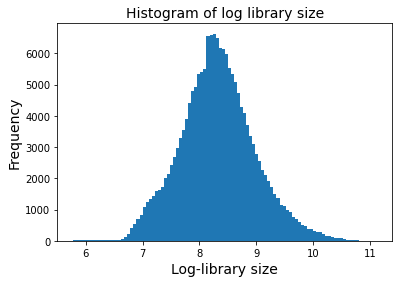

In [17]:
plt.hist(adataC.obs['log1p_total_counts'], bins = 100);
plt.xlabel('Log-library size', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.title('Histogram of log library size', fontsize = 14)

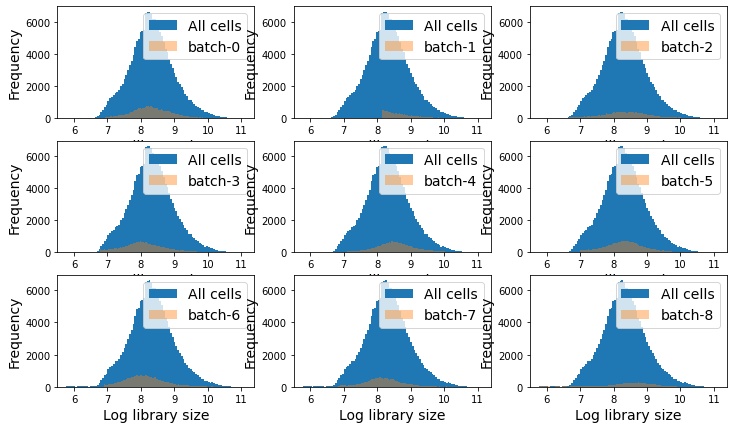

In [18]:
fig = plt.figure(figsize = (6*2, 7*1))
for j, item in enumerate(np.unique(adataC.obs['batch_id'])):
    ax = fig.add_subplot(3,3,j+1)
    ax.hist(adataC.obs['log1p_total_counts'],bins=100,label='All cells')
    ax.hist(adataC.obs['log1p_total_counts'][adataC.obs['batch_id']==item],bins=100,label='batch-'+item,alpha=0.4)
    ax.set_xlabel('Log library size',fontsize=14)
    ax.set_ylabel('Frequency',fontsize=14)
    ax.legend(fontsize=14)

Text(0, 0.5, 'Frequency')

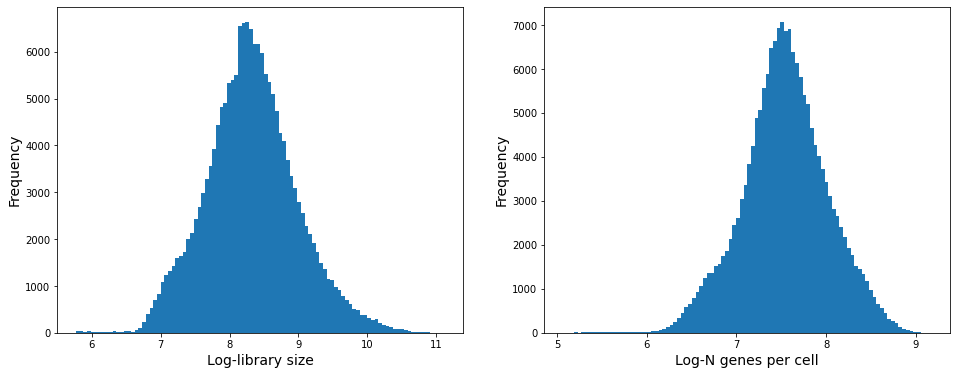

In [19]:
# Distribution of library size (total counts); number of genes per cell
fig = plt.figure(figsize = (8*2, 6*1))
ax = fig.add_subplot(1, 2, 1)
ax.hist(adataC.obs['log1p_total_counts'], 100)
ax.set_xlabel('Log-library size', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)

ax = fig.add_subplot(1, 2, 2)
ax.hist(adataC.obs['log1p_n_genes_by_counts'], 100)
ax.set_xlabel('Log-N genes per cell', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)

## Mito-content

In [24]:
# Identify MT-genes
mito_genes = adataC.var_names[adataC.var_names.str.startswith('MT-')]

In [25]:
index_mito_genes = [adataC.var_names.get_loc(j) for j in mito_genes]

In [26]:
#define mitochondrial fraction for each cell as the total mitochondrial RNA counts divided by the total counts in that cell.
mito_frac = np.asarray(np.sum(adataC.X[:, index_mito_genes], axis = 1)/np.sum(adataC.X, axis = 1)).squeeze() * 100

Text(0, 0.5, '% MT-content')

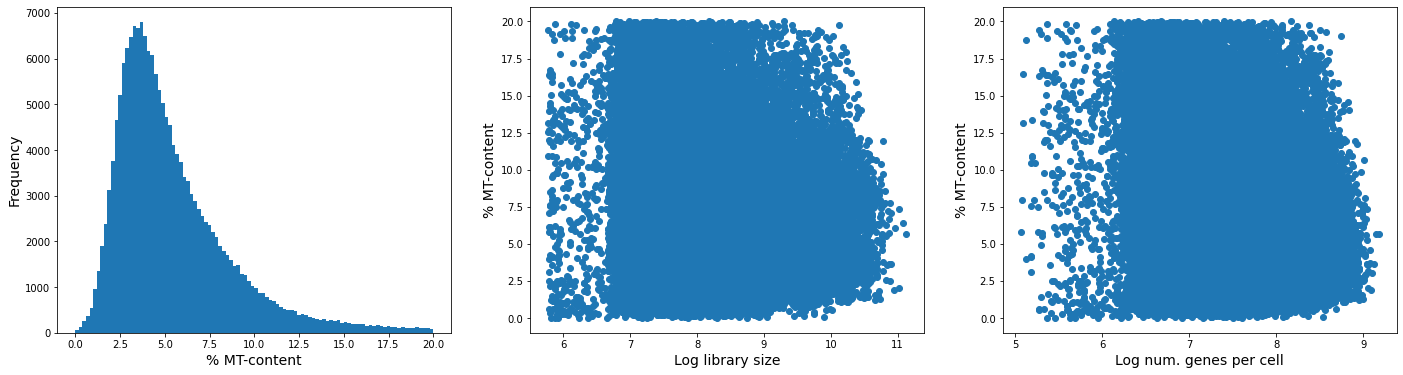

In [27]:
fig = plt.figure(figsize = (8*3, 6*1))
ax = fig.add_subplot(1, 3, 1)
ax.hist(mito_frac, 100);
ax.set_xlabel('% MT-content', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)

ax = fig.add_subplot(1, 3, 2)
ax.scatter(adataC.obs['log1p_total_counts'], mito_frac);
ax.set_xlabel('Log library size', fontsize = 14)
ax.set_ylabel('% MT-content', fontsize = 14)

ax = fig.add_subplot(1, 3, 3)
ax.scatter(adataC.obs['log1p_n_genes_by_counts'], mito_frac);
ax.set_xlabel('Log num. genes per cell', fontsize = 14)
ax.set_ylabel('% MT-content', fontsize = 14)

In [28]:
adataC.obs['mito_frac'] = mito_frac

In [29]:
id_low_mt_cells = adataC.obs.index[mito_frac < 45]
print(sum(mito_frac < 45))
print(len(id_low_mt_cells))

176566
176566


## Number of cells a gene is expressed in

(0.0, 1000.0)

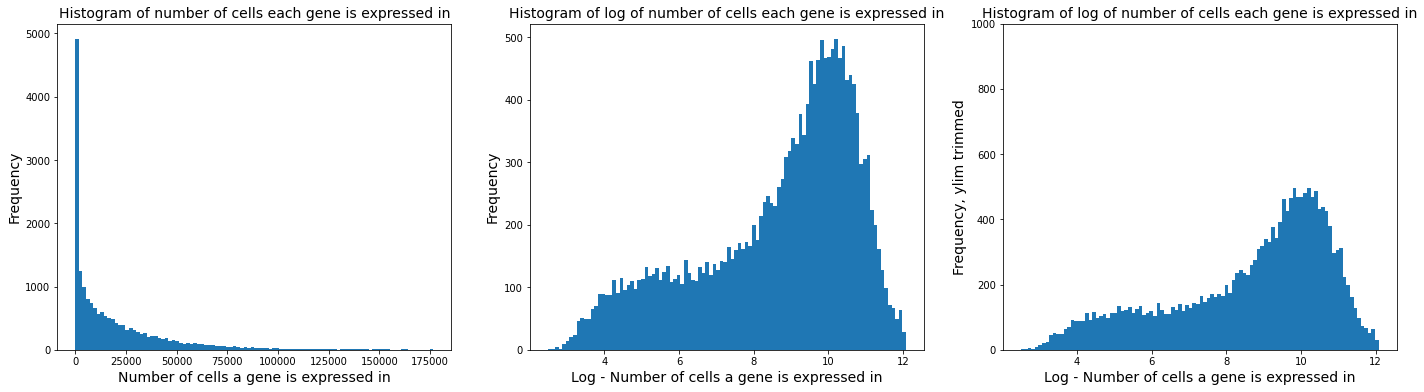

In [30]:
fig = plt.figure(figsize = (8*3, 6*1))
ax = fig.add_subplot(1, 3, 1)
ax.hist(adataC.var['n_cells_by_counts'], bins = 100);
ax.set_xlabel('Number of cells a gene is expressed in', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.set_title('Histogram of number of cells each gene is expressed in', fontsize = 14)

ax = fig.add_subplot(1, 3, 2)
ax.hist(np.log(adataC.var['n_cells_by_counts'] + 1), bins = 100);
ax.set_xlabel('Log - Number of cells a gene is expressed in', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.set_title('Histogram of log of number of cells each gene is expressed in', fontsize = 14)

ax = fig.add_subplot(1, 3, 3)
ax.hist(np.log(adataC.var['n_cells_by_counts'] + 1), bins = 100);
ax.set_xlabel('Log - Number of cells a gene is expressed in', fontsize = 14)
ax.set_ylabel('Frequency, ylim trimmed', fontsize = 14)
ax.set_title('Histogram of log of number of cells each gene is expressed in', fontsize = 14)
ax.set_ylim([0, 1000])

## Filter for low-quality genes

Filter cells with low number genes

In [31]:
#sc.pp.filter_genes(adata, min_cells = np.exp(1))
sc.pp.filter_genes(adataC, min_cells=np.exp(3))

Text(0.5, 0, 'Log library size')

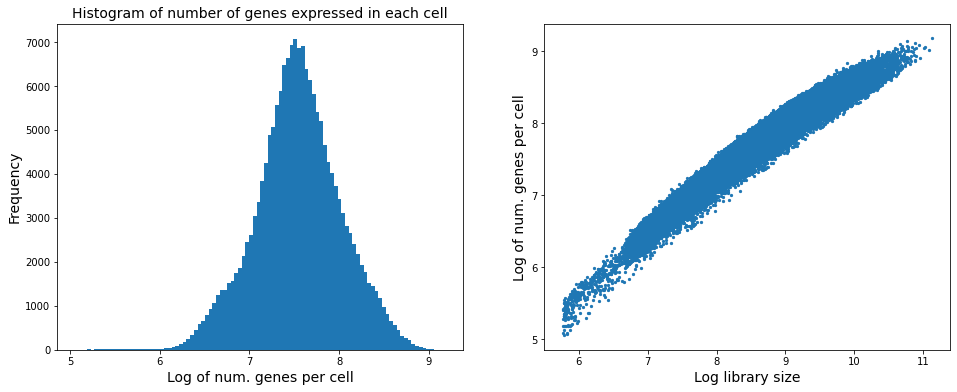

In [32]:
fig = plt.figure(figsize = (8*2, 6*1))
ax = fig.add_subplot(1, 2, 1)
ax.hist(adataC.obs['log1p_n_genes_by_counts'], bins = 100);
ax.set_xlabel('Log of num. genes per cell', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.set_title('Histogram of number of genes expressed in each cell', fontsize = 14)

ax = fig.add_subplot(1, 2, 2) 
ax.scatter(adataC.obs['log1p_total_counts'], adataC.obs['log1p_n_genes_by_counts'], s = 5);
ax.set_ylabel('Log of num. genes per cell', fontsize = 14)
ax.set_xlabel('Log library size', fontsize = 14)

In [33]:
rb_genes = adataC.var_names[adataC.var_names.str.startswith(('RPS','RPL','GM'))]

In [34]:
index_rb_genes = [adataC.var_names.get_loc(j) for j in rb_genes]

In [35]:
rb_frac = np.asarray(np.sum(adataC.X[:, index_rb_genes], axis = 1)/np.sum(adataC.X, axis = 1)).squeeze() * 100

Text(0, 0.5, '% RB-content')

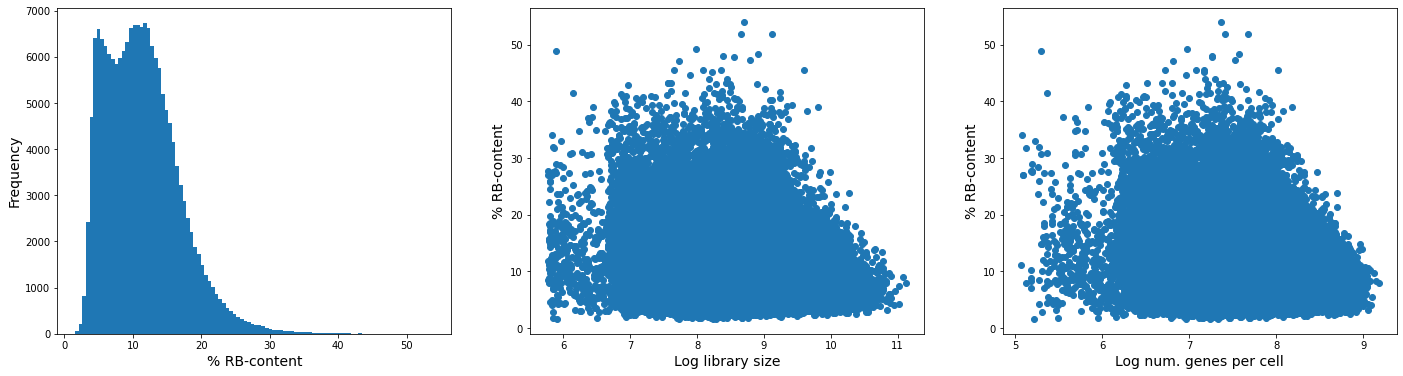

In [36]:
fig = plt.figure(figsize = (8*3, 6*1))
ax = fig.add_subplot(1, 3, 1)
ax.hist(rb_frac, 100);
ax.set_xlabel('% RB-content', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)

ax = fig.add_subplot(1, 3, 2)
ax.scatter(adataC.obs['log1p_total_counts'], rb_frac);
ax.set_xlabel('Log library size', fontsize = 14)
ax.set_ylabel('% RB-content', fontsize = 14)

ax = fig.add_subplot(1, 3, 3)
ax.scatter(adataC.obs['log1p_n_genes_by_counts'], rb_frac);
ax.set_xlabel('Log num. genes per cell', fontsize = 14)
ax.set_ylabel('% RB-content', fontsize = 14)




remove ribosomal genes

In [37]:
ribo_mk = np.in1d(adataC.var_names.values.astype(str), rb_genes)
adataC = adataC[:,~ribo_mk]

In [40]:
adataC

View of AnnData object with n_obs × n_vars = 176566 × 17583
    obs: 'barcode_sequence', 'hash_id', 'htoByMax', 'mouse', 'unmapped', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mito_frac'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

## Normalize, log transform

In [38]:
adataC.layers['raw_data'] = adataC.X.copy()
sc.pp.normalize_total(adataC, inplace = True)

In [39]:
adataC.layers['norm_counts'] = adataC.X.copy()

In [40]:
adataC.X = np.log2(adataC.X + 1)

In [41]:
adataC.layers['raw_data']

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Highly Variable Genes, PCA, Nearest Neighbors, UMAP

In [42]:
# HVG
sc.pp.highly_variable_genes(adataC, layer = 'raw_data', n_top_genes = 4000, flavor = 'seurat_v3')

In [43]:
adataC.uns['id_hvg'] = np.where(adataC.var['highly_variable'])[0]

In [44]:
# PCA
sc.tl.pca(adataC, n_comps=100, use_highly_variable=None)

In [45]:
# ensure that loadings of only HVG are kept track of
adataC.uns['loadings'] = adataC.varm['PCs'][adataC.var['highly_variable'], :]

In [46]:
#30 components enough to explain variance 
adataC.obsm['X_pca'] = adataC.obsm['X_pca'][:, 0:30]

# we want to update the loadings adata.uns['loadings'] and 
#adata.varm['PCs'] to reflect only the top 30 principal components
adataC.varm['PCs'] = adataC.varm['PCs'][:, 0:30]
adataC.uns['loadings'] = adataC.uns['loadings'][:, 0:30]

In [47]:
adataC

AnnData object with n_obs × n_vars = 176566 × 17002
    obs: 'barcode_sequence', 'hash_id', 'htoByMax', 'mouse', 'unmapped', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mito_frac'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'id_hvg', 'pca', 'loadings'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw_data', 'norm_counts'

In [48]:
sc.pp.neighbors(adataC, n_neighbors=30, use_rep='X_pca', metric='euclidean', key_added='neighbors_30')


In [49]:
# UMAP, FDL using the nearest neighbors
sc.tl.umap(adataC, neighbors_key = 'neighbors_30', min_dist=0.1)

/opt/anaconda3/envs/sc_analysis/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


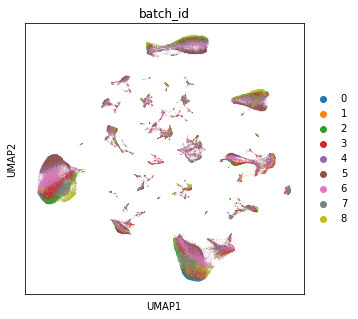

In [50]:
with plt.rc_context({'figure.figsize': (5, 5)}): 
    sc.pl.umap(adataC, color = ['batch_id'],show=False)

## Clustering

In [51]:
# Clustering using PhenoGraph
sc.external.tl.phenograph(adataC, clustering_algo='leiden', k=30, jaccard=True, primary_metric='euclidean', 
                          resolution_parameter = 0.1)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 14.243710041046143 seconds
Jaccard graph constructed in 8.017514944076538 seconds
Running Leiden optimization
Leiden completed in 23.1370530128479 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 49.72731113433838 seconds


In [52]:
adataC.obsp['pheno_jaccard_ig'] = scipy.sparse.csr_matrix(adataC.obsp['pheno_jaccard_ig'])

/opt/anaconda3/envs/sc_analysis/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


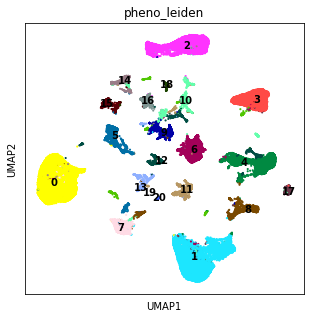

In [53]:
#%matplotlib inline
with plt.rc_context({'figure.figsize': (5, 5)}):  # Use this to set figure params like size and dpi
    sc.pl.umap(adataC, color = ['pheno_leiden'],s=18,legend_loc='on data',legend_fontsize = 10,palette = sc.pl.palettes.godsnot_102,show=False)

## Cell type identification

In [15]:
##label clusters with custom list 
toplot_markers = p.read_csv('/Users/andrea/Desktop/cp/CellTypesLinna.csv')
toplot_markers
cells = list(toplot_markers.columns.values)

toplot_dic = {}

for c in cells:
    cc = np.unique(np.array(toplot_markers[c].values.tolist()))
    toplot_dic[c] = [x for x in cc if str(x) != 'nan']

In [55]:
adataC.layers['zs_norm_log'] = scipy.stats.zscore(adataC.X)

In [191]:
color_set = ['#8c564b','#d62728','#1f77b4','#e377c2','#279e68','#ffbb78','#aec7e8','#b5bd61','#17becf','#aa40fc','#ff7f0e']
#'#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd','#8c564b', '#e377c2', '#7f7f7f','#bcbd22','#17becf','#fac205'
celltype_color_map = dict(zip(toplot_dic.keys(), color_set))

In [192]:
genes_color_map = {}
for item, value in toplot_dic.items():
    for k in value:
        genes_color_map[k] = celltype_color_map[item]
    
genes_color_map

{'ATP1B1': '#8c564b',
 'BASP1': '#8c564b',
 'BEX2': '#8c564b',
 'CDK5R1': '#8c564b',
 'CELF4': '#8c564b',
 'CIT': '#8c564b',
 'ELAVL3': '#8c564b',
 'GAP43': '#8c564b',
 'GNG3': '#8c564b',
 'MAP2': '#8c564b',
 'MEG3': '#8c564b',
 'MLLT11': '#8c564b',
 'NAP1L5': '#8c564b',
 'NCDN': '#8c564b',
 'NDRG4': '#8c564b',
 'NSF': '#8c564b',
 'NSG2': '#8c564b',
 'NTNG1': '#8c564b',
 'OLFM1': '#8c564b',
 'PCSK1N': '#8c564b',
 'PEG3': '#8c564b',
 'PGM2L1': '#8c564b',
 'RAB3C': '#8c564b',
 'RAB6B': '#8c564b',
 'RTN1': '#8c564b',
 'SLC17A6': '#8c564b',
 'SNAP25': '#8c564b',
 'SNCB': '#8c564b',
 'SNHG11': '#8c564b',
 'SNRPN': '#8c564b',
 'STMN3': '#8c564b',
 'SYP': '#8c564b',
 'SYT1': '#8c564b',
 'SYT7': '#8c564b',
 'TCF7L2': '#8c564b',
 'THY1': '#8c564b',
 'TTC3': '#8c564b',
 'UBE3A': '#8c564b',
 'YWHAG': '#8c564b',
 'YWHAZ': '#8c564b',
 'ZWINT': '#8c564b',
 'CCL3': '#d62728',
 'CCL4': '#d62728',
 'CCR6': '#d62728',
 'CMTM6': '#d62728',
 'CSF1R': '#d62728',
 'CX3CR1': '#d62728',
 'FAM105A': '#d62728',

In [193]:
# Get the gene ids
gene_ids = [adataC.var_names.get_loc(j) for j in genes_color_map.keys()]

# Create a data matrix with only genes of interest 
# can also use scaled/zscored data instead of norm_log
data_matrix = p.DataFrame(adataC.layers['zs_norm_log'][:, gene_ids], 
                          index = adataC.obs_names, 
                          columns = genes_color_map.keys())

# Add cluster labels to compute average
data_matrix['pheno_leiden'] = adataC.obs['pheno_leiden']

In [194]:
# Compute the average for each cluster
avg_matrix = data_matrix.groupby(['pheno_leiden']).mean()

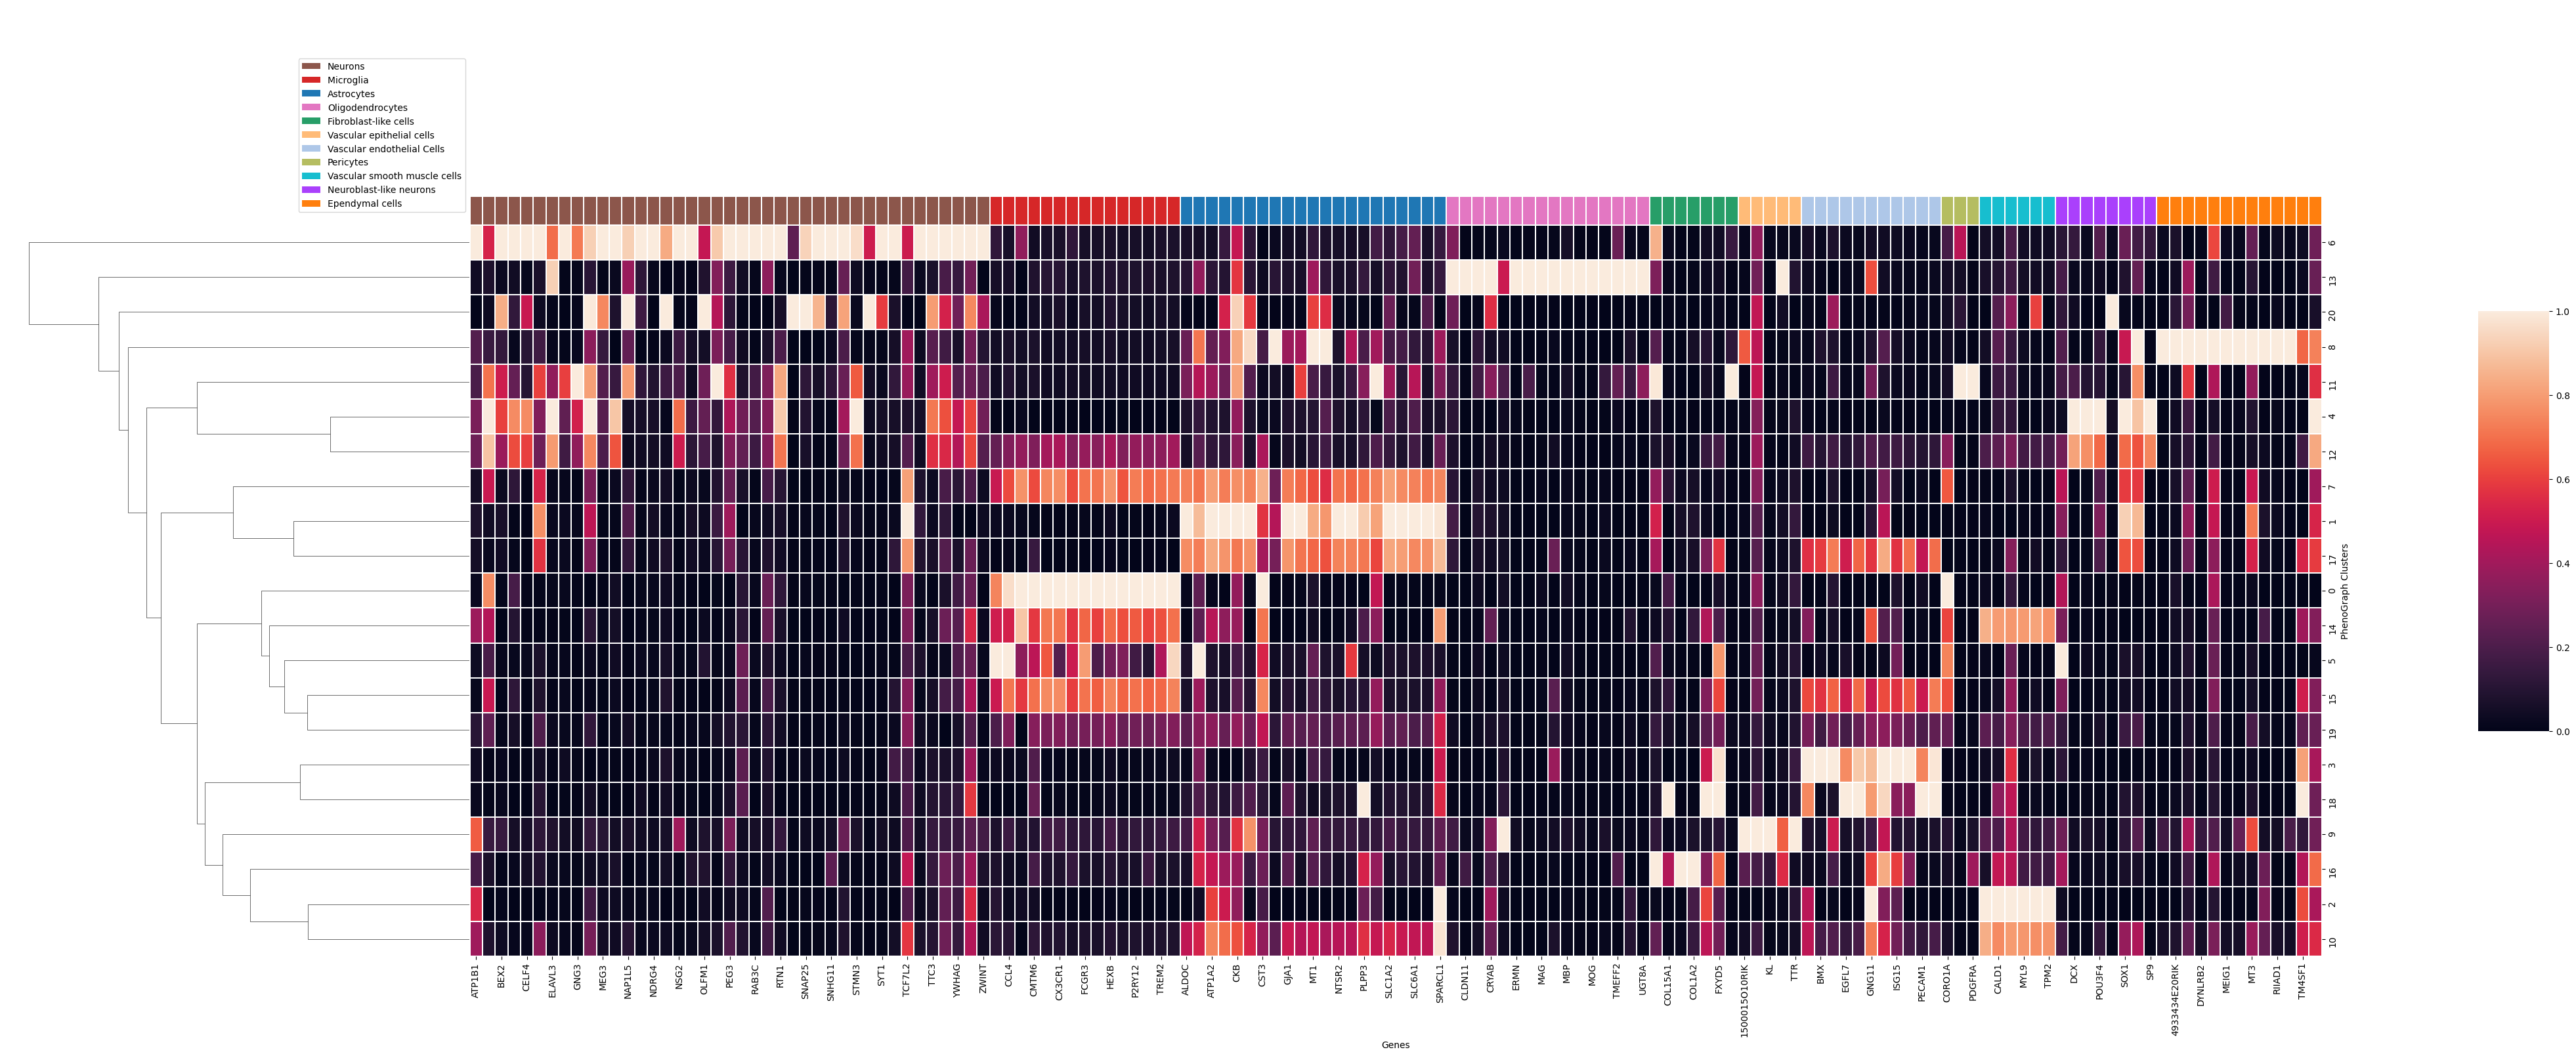

In [196]:
# Create a heatmap
plt.rcParams["axes.grid"] = False
g = sns.clustermap(avg_matrix, col_cluster = False, standard_scale = 1, cbar_pos=(1.05, .3, .03, .4), 
                   linewidth = 0.02, figsize = (36, 16), 
                   col_colors = [color_use for color_use in genes_color_map.values()])
g.ax_heatmap.set_xlabel('Genes')
g.ax_heatmap.set_ylabel('PhenoGraph Clusters')

# Draw the legend bar for the classes                 
for label in celltype_color_map.keys():
    g.ax_col_dendrogram.bar(0, 0, color=celltype_color_map[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(ncol=1, bbox_to_anchor = (0, 0.75))

#g.savefig('/Users/andrea/Desktop/illustrator/heatmapth.svg', dpi = 150, bbox_inches = 'tight')

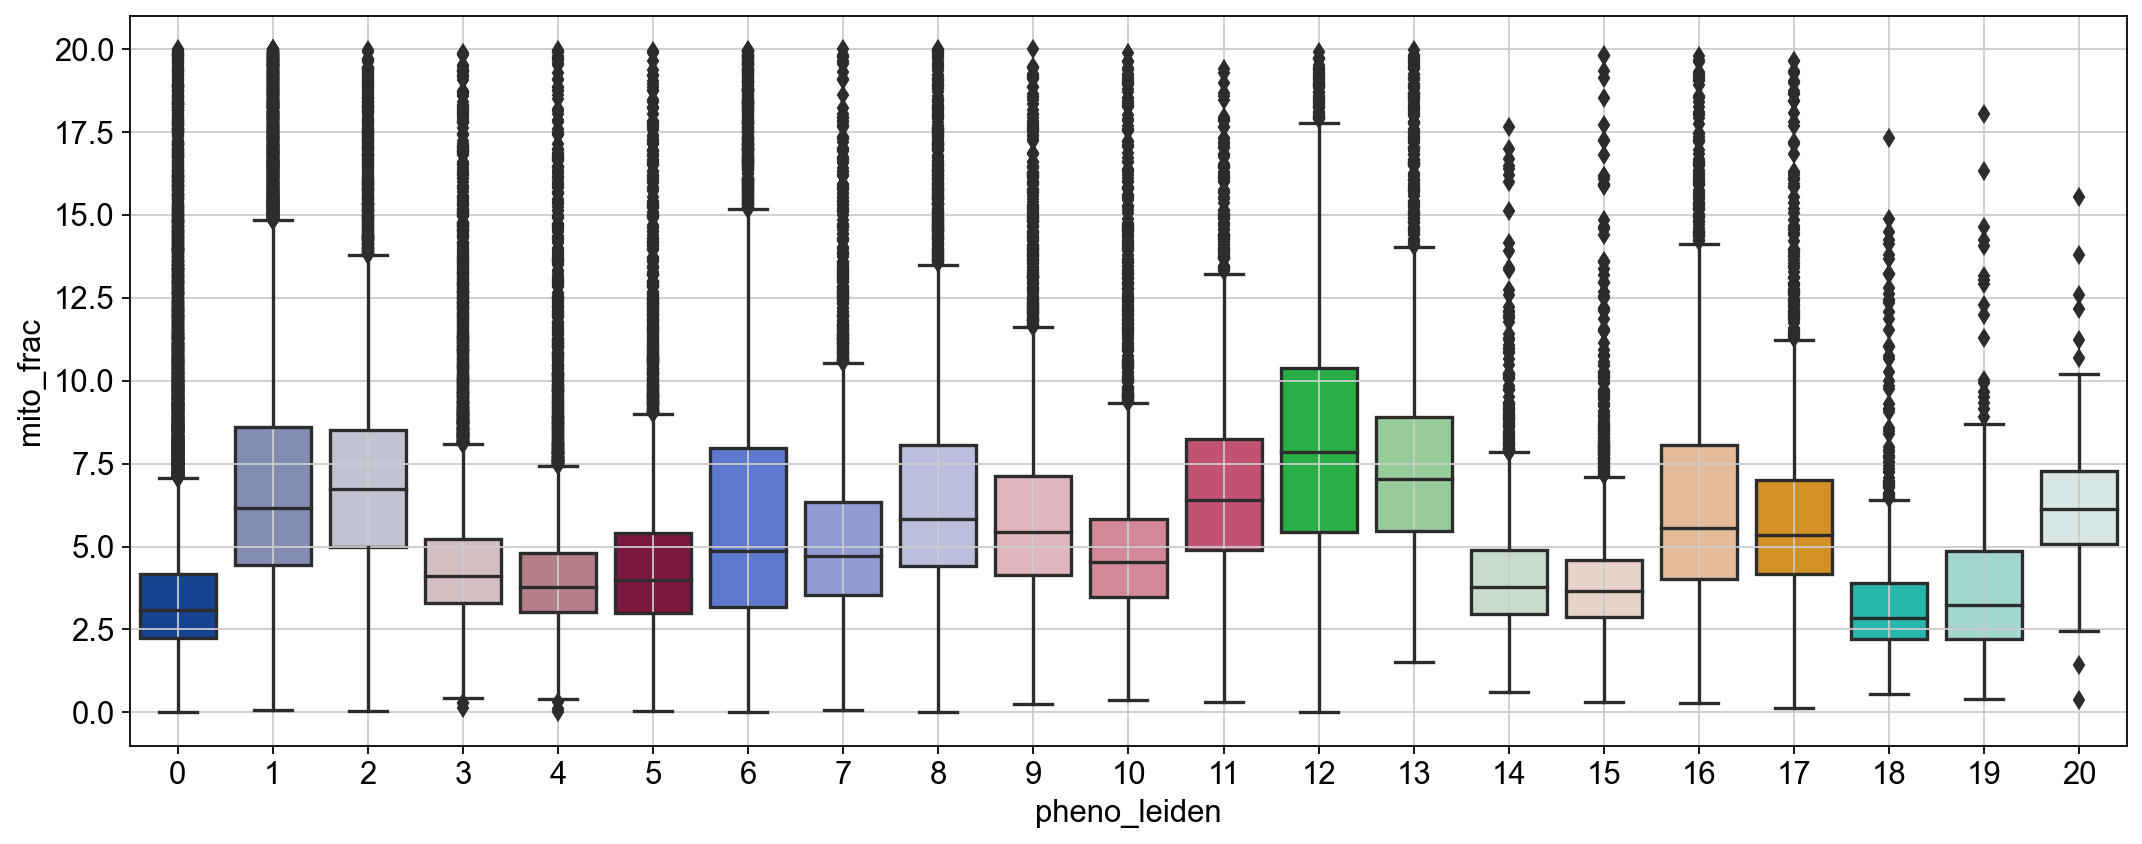

In [16]:
sc.set_figure_params(scanpy=True, fontsize = 14)
df_temp = adataC.obs[['mito_frac', 'pheno_leiden']]

import seaborn as sns
fig = plt.figure(figsize = (8*2, 6))
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x = "pheno_leiden", y = "mito_frac", data = df_temp, ax = ax, 
            palette = sc.pl.palettes.zeileis_28)
ax.grid('on')

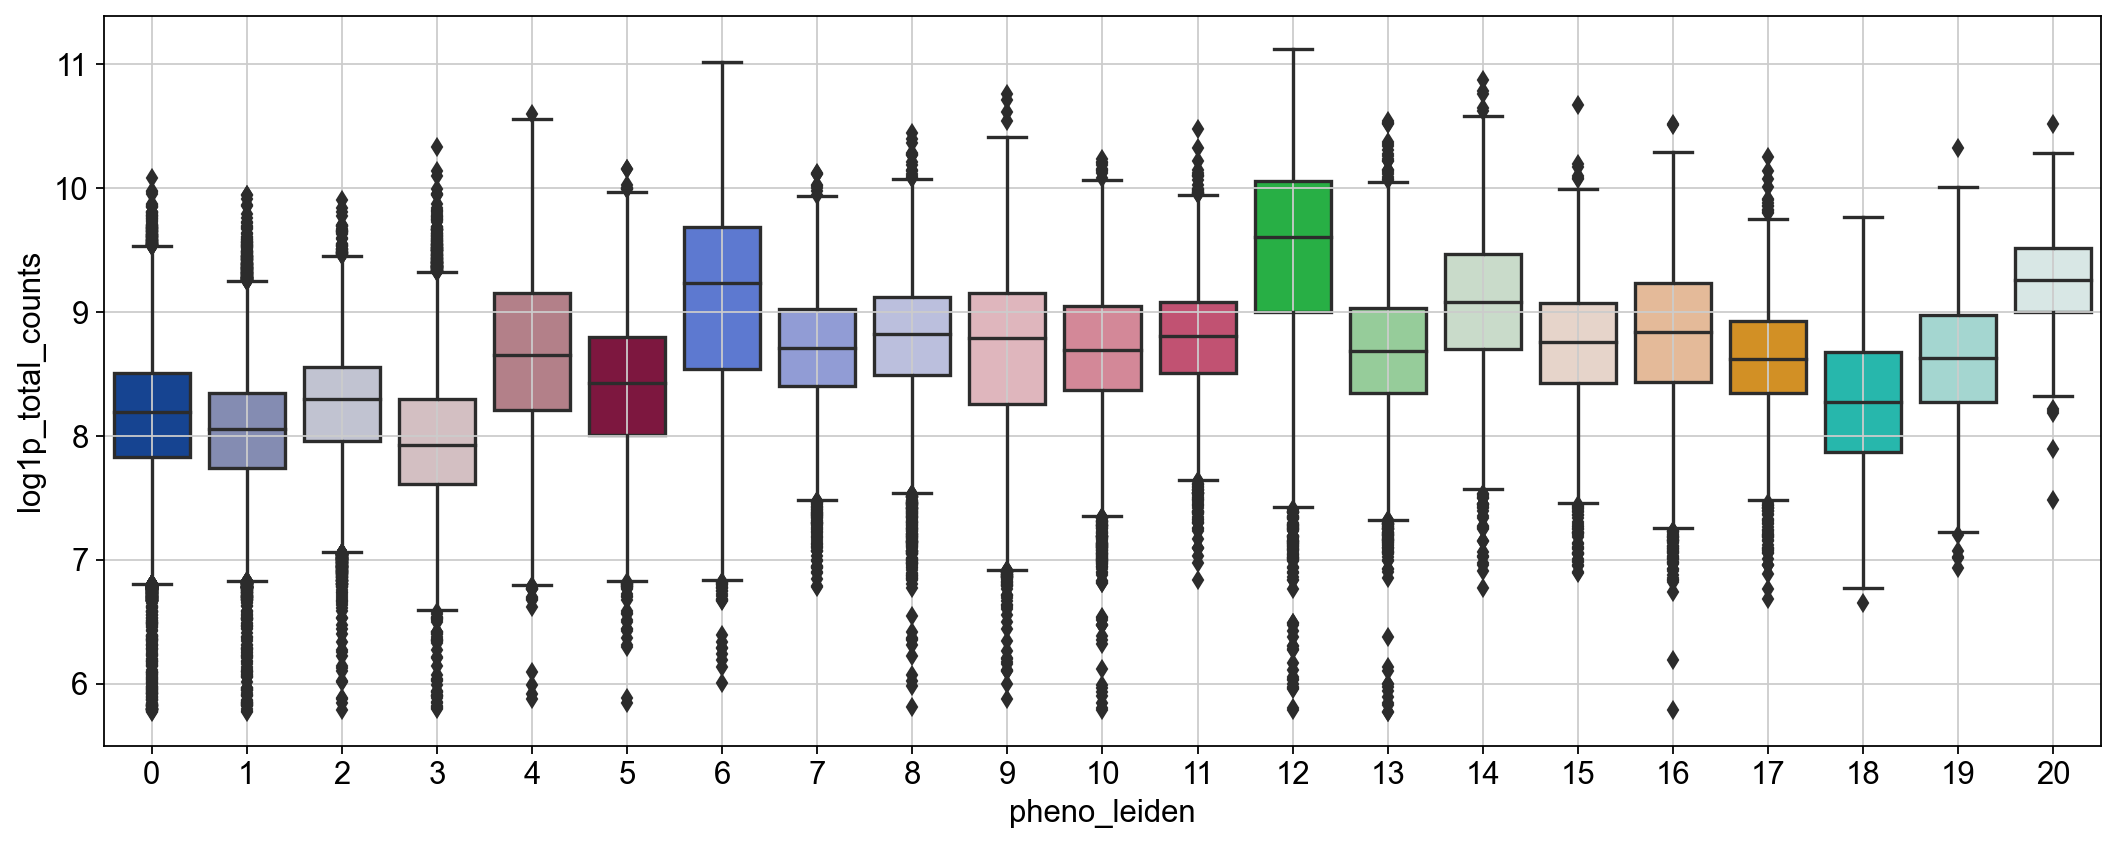

In [17]:
sc.set_figure_params(scanpy=True, fontsize = 14)
df_temp = adataC.obs[['log1p_total_counts', 'pheno_leiden']]

import seaborn as sns
fig = plt.figure(figsize = (8*2, 6))
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x = "pheno_leiden", y = "log1p_total_counts", data = df_temp, ax = ax, 
            palette = sc.pl.palettes.zeileis_28)
ax.grid('on')

Neurons


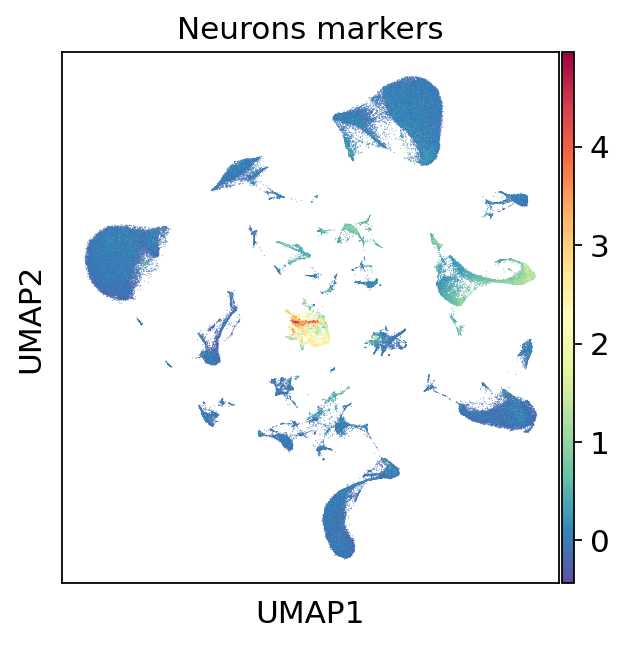

Microglia 


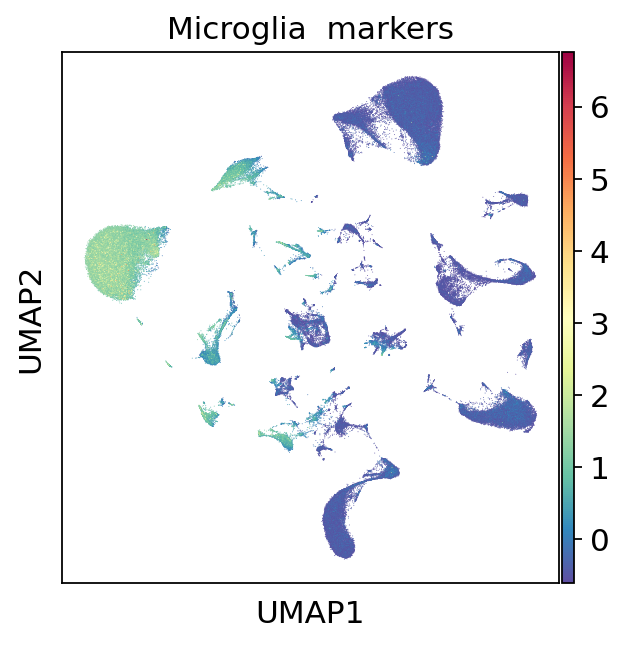

Astrocytes


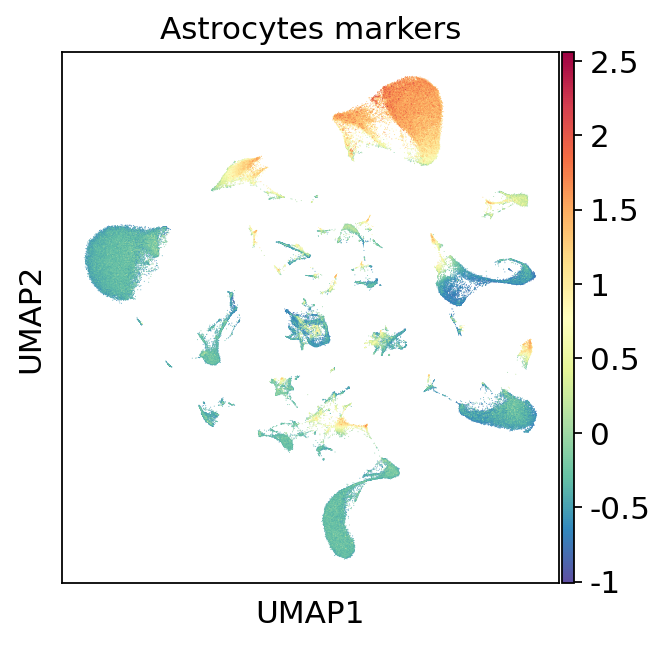

Oligodendrocytes


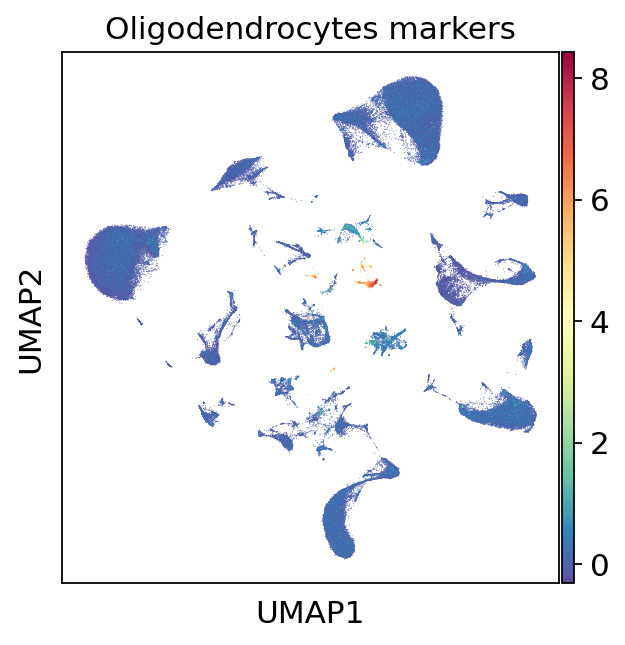

Fibroblast-like cells


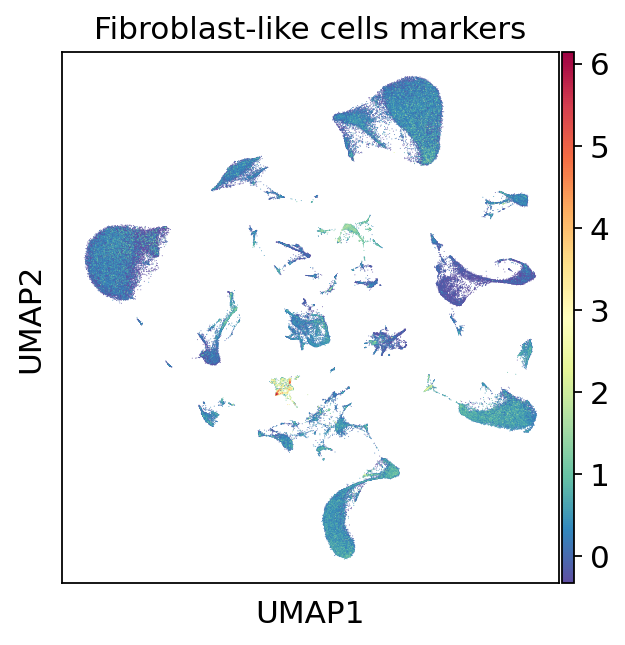

Vascular epithelial cells


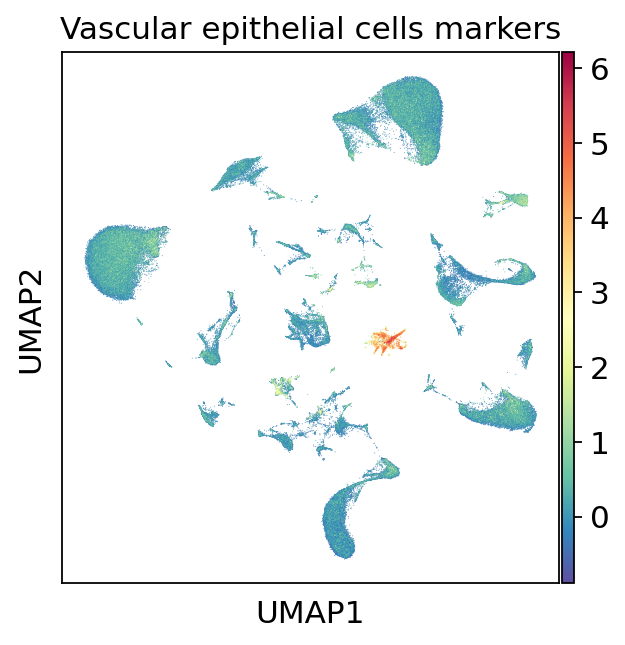

Vascular endothelial Cells


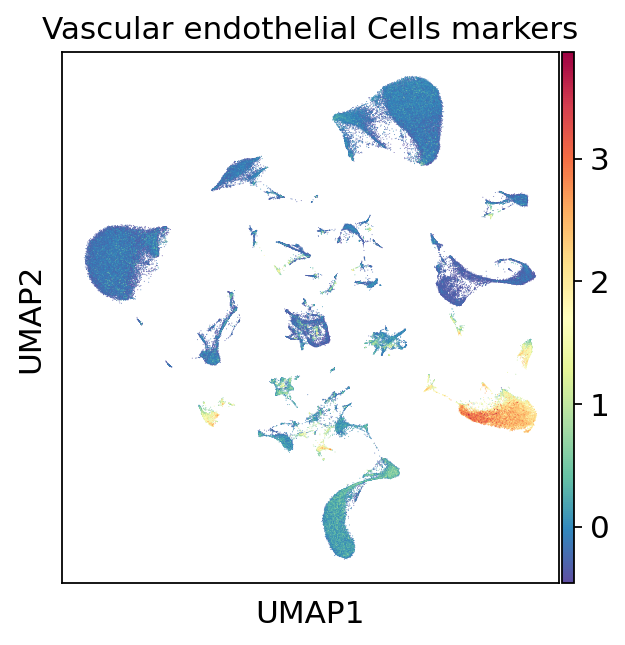

Pericytes


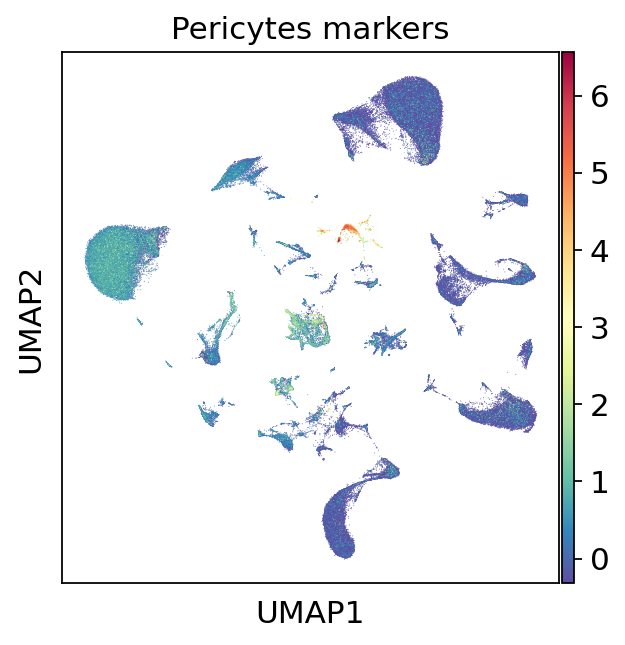

Vascular smooth muscle cells


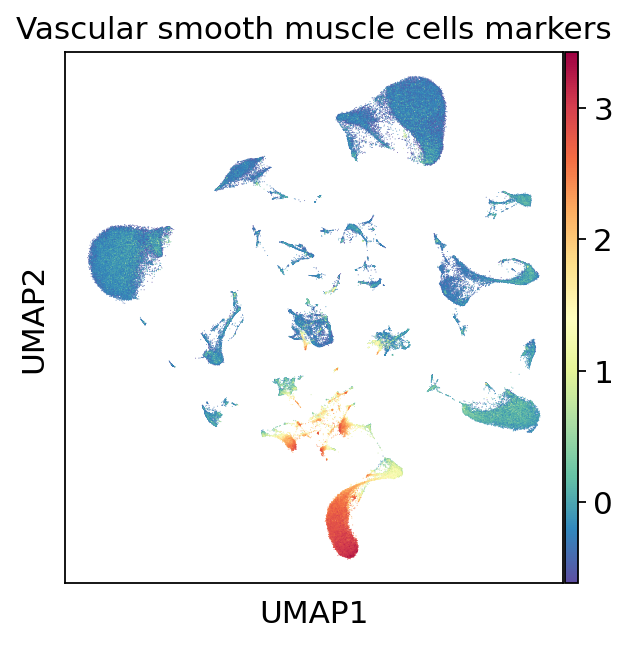

Neuroblast-like neurons


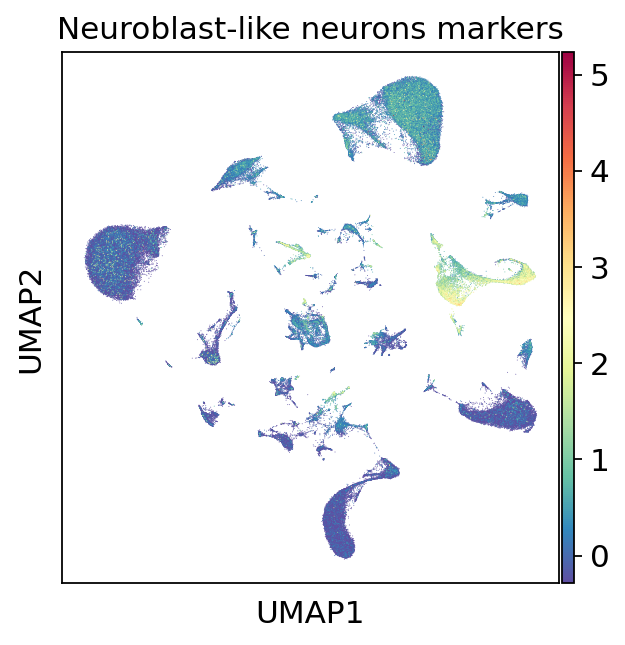

Ependymal cells


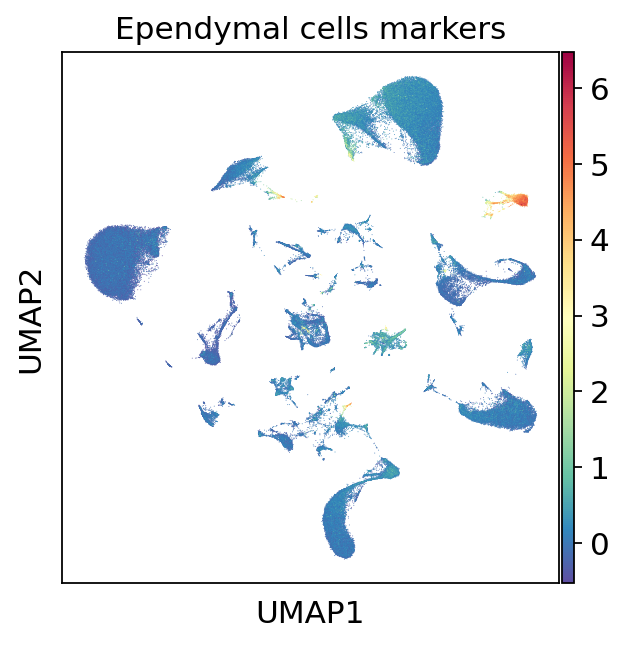

In [73]:
# toplot_dic
for i in toplot_dic.keys():
    print(i)
    genes = toplot_dic[i]
    genes_up = []
    for g in genes:
        genes_up = np.append(genes_up,g.upper())
    
    top_genes = np.intersect1d(adataC.var.index, genes_up)
    val = np.sum(adataC[:,top_genes].layers['zs_norm_log'],axis=1)
    val = np.array(val).flatten()
    label = "%s_markers"%(i)
    adataC.obs[label] = val/len(top_genes)
    
    sc.pl.scatter(adataC,color=label,legend_loc='none',basis='umap',color_map='Spectral_r')

In [78]:
#rank top expressed genes per cluster to identify unclear cell types
sc.tl.rank_genes_groups(adataC, groupby = 'pheno_leiden', method = 'wilcoxon')

/opt/anaconda3/envs/sc_analysis/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/anaconda3/envs/sc_analysis/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/anaconda3/envs/sc_analysis/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning:

In [86]:
sc.get.rank_genes_groups_df(adataC, group = '15').head(15)

names     scores  logfoldchanges  pvals  pvals_adj
0      FLT1  68.138809        4.812591    0.0        0.0
1     LY6C1  66.416237        4.511107    0.0        0.0
2     PTPRB  64.514709        3.925279    0.0        0.0
3      LY6A  64.326050        4.015500    0.0        0.0
4     CLDN5  63.915440        4.377818    0.0        0.0
5   SLCO1A4  62.102085        4.105753    0.0        0.0
6    ADGRF5  61.773605        3.598191    0.0        0.0
7     EGFL7  61.440781        3.451621    0.0        0.0
8     ITM2A  60.782642        3.779174    0.0        0.0
9    ABCB1A  60.624317        3.684315    0.0        0.0
10      BSG  60.488811        3.139689    0.0        0.0
11   SPOCK2  60.432396        3.608403    0.0        0.0
12    ABCG2  59.087875        3.173829    0.0        0.0
13   SPTBN1  58.744839        2.778095    0.0        0.0
14     PLTP  58.548786        3.171439    0.0        0.0

Assigning cell types

In [87]:
neuron_clusters = [6]
id_neuron_cells = np.isin(adataC.obs['pheno_leiden'], neuron_clusters)

micro_clusters = [0,5]
id_micro_cells = np.isin(adataC.obs['pheno_leiden'], micro_clusters)

astro_clusters = [1,7]
id_astro_cells = np.isin(adataC.obs['pheno_leiden'], astro_clusters)

endo_clusters = [3,17,18,15]
id_endo_cells = np.isin(adataC.obs['pheno_leiden'], endo_clusters)

olig_clusters = [13]
id_olig_cells = np.isin(adataC.obs['pheno_leiden'], olig_clusters)

smooth_muscle = [2,14,10,19]
id_muscle = np.isin(adataC.obs['pheno_leiden'], smooth_muscle)

blood_related = [11]
id_blood = np.isin(adataC.obs['pheno_leiden'], blood_related)

collagen_related = [16]
id_collagen = np.isin(adataC.obs['pheno_leiden'], collagen_related)
#mural cells have blood collagen and smooth cells

precursors = [4,12,20]
id_prec = np.isin(adataC.obs['pheno_leiden'], precursors)

epi = [9]
id_epi = np.isin(adataC.obs['pheno_leiden'], epi)

ependi = [8]
id_ependi = np.isin(adataC.obs['pheno_leiden'], ependi)

/opt/anaconda3/envs/sc_analysis/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


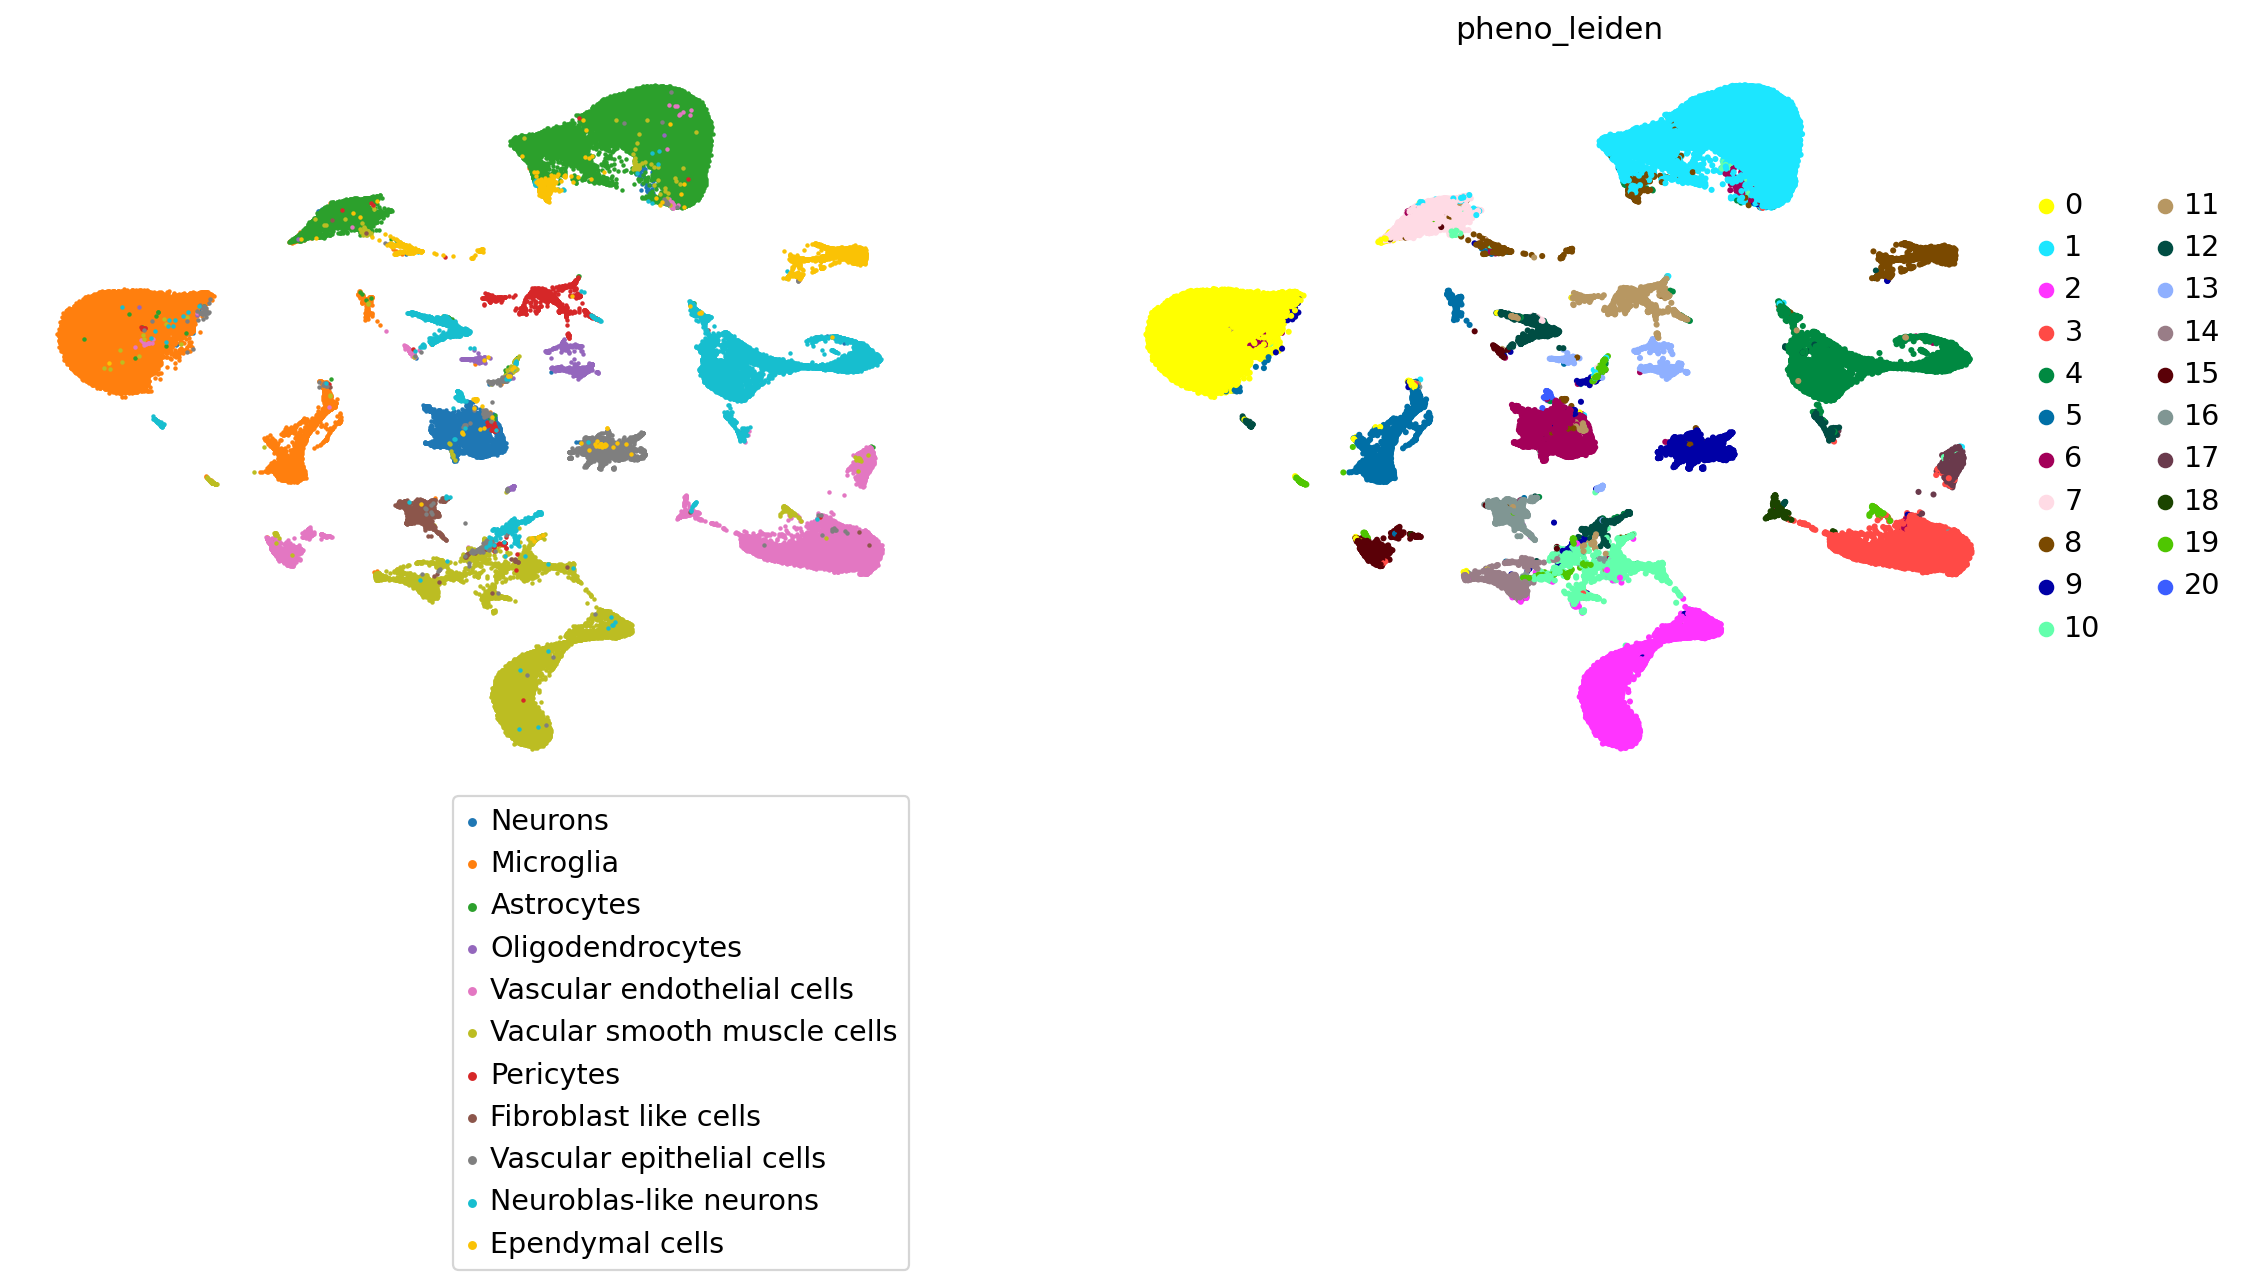

In [88]:
fig = plt.figure(figsize = (8*2, 6))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(adataC.obsm['X_umap'][id_neuron_cells, 0], adataC.obsm['X_umap'][id_neuron_cells, 1], s = 1, c = '#1f77b4', 
           label = 'Neurons')
ax.scatter(adataC.obsm['X_umap'][id_micro_cells, 0], adataC.obsm['X_umap'][id_micro_cells, 1], s = 1, c = '#ff7f0e', 
           label = 'Microglia')
ax.scatter(adataC.obsm['X_umap'][id_astro_cells, 0], adataC.obsm['X_umap'][id_astro_cells, 1], s = 1, c = '#2ca02c', 
           label = 'Astrocytes')
ax.scatter(adataC.obsm['X_umap'][id_olig_cells, 0], adataC.obsm['X_umap'][id_olig_cells, 1], s = 1, c = '#9467bd', 
           label = 'Oligodendrocytes')
ax.scatter(adataC.obsm['X_umap'][id_endo_cells, 0], adataC.obsm['X_umap'][id_endo_cells, 1], s = 1, c = '#e377c2', 
           label = 'Vascular endothelial cells')
ax.scatter(adataC.obsm['X_umap'][id_muscle, 0], adataC.obsm['X_umap'][id_muscle, 1], s = 1, c = '#bcbd22', 
           label = 'Vacular smooth muscle cells')
ax.scatter(adataC.obsm['X_umap'][id_blood, 0], adataC.obsm['X_umap'][id_blood, 1], s = 1, c = '#d62728', 
           label = 'Pericytes')
ax.scatter(adataC.obsm['X_umap'][id_collagen, 0], adataC.obsm['X_umap'][id_collagen, 1], s = 1, c = '#8c564b', 
           label = 'Fibroblast like cells')
ax.scatter(adataC.obsm['X_umap'][id_epi, 0], adataC.obsm['X_umap'][id_epi, 1], s = 1, c = '#7f7f7f', 
           label = 'Vascular epithelial cells')
ax.scatter(adataC.obsm['X_umap'][id_prec, 0], adataC.obsm['X_umap'][id_prec, 1], s = 1, c = '#17becf', 
           label = 'Neuroblas-like neurons')
ax.scatter(adataC.obsm['X_umap'][id_ependi, 0], adataC.obsm['X_umap'][id_ependi, 1], s = 1, c = '#fac205', 
           label = 'Ependymal cells')

ax.axis('off')
ax.legend(markerscale = 3, loc='upper right',bbox_to_anchor=(1, 0))


ax = fig.add_subplot(1, 2, 2)
sc.pl.umap(adataC, color = ['pheno_leiden'],size = 30, ncols = 1, wspace=0.2, ax = ax, frameon=False)


In [99]:
celltype = []
for i in range(0,176566):
    if adataC.obs['pheno_leiden'][i] == 1 or adataC.obs['pheno_leiden'][i] == 7:
        celltype.append('Astrocytes') 
     
    elif adataC.obs['pheno_leiden'][i] == 0 or adataC.obs['pheno_leiden'][i] == 5:
        celltype.append('Microglia')
    
    elif adataC.obs['pheno_leiden'][i] == 6:
        celltype.append('Neurons')    
    elif adataC.obs['pheno_leiden'][i] == 13:
        celltype.append('Oligodendrocytes') 
       
    elif adataC.obs['pheno_leiden'][i] == 16:
        celltype.append('Fibroblast-like')      
    elif adataC.obs['pheno_leiden'][i] == 3 or adataC.obs['pheno_leiden'][i] == 17:
        celltype.append('Vascular endothelial')
    elif adataC.obs['pheno_leiden'][i] == 18 or adataC.obs['pheno_leiden'][i] == 15:
        celltype.append('Vascular endothelial')
    elif adataC.obs['pheno_leiden'][i] == 9:
        celltype.append('Vascular epithelial cells')
    elif adataC.obs['pheno_leiden'][i] == 11:
        celltype.append('Perycites')      
    elif adataC.obs['pheno_leiden'][i] ==2 or adataC.obs['pheno_leiden'][i] == 14:
        celltype.append('Vascular Smooth Muscle')
    elif  adataC.obs['pheno_leiden'][i]==10 or adataC.obs['pheno_leiden'][i] == 19:
        celltype.append('Vascular Smooth Muscle')
    elif  adataC.obs['pheno_leiden'][i]==4 or adataC.obs['pheno_leiden'][i] == 12:
        celltype.append('Neuroblas-like neurons')
    elif  adataC.obs['pheno_leiden'][i]==20: 
        celltype.append('Neuroblas-like neurons')
    elif  adataC.obs['pheno_leiden'][i]==8:    
        celltype.append('Ependymal cells')
    else:
        celltype.append('na')

adataC.obs['Cell Type']= celltype

/Users/andrea/anaconda3/envs/sc_analysis/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


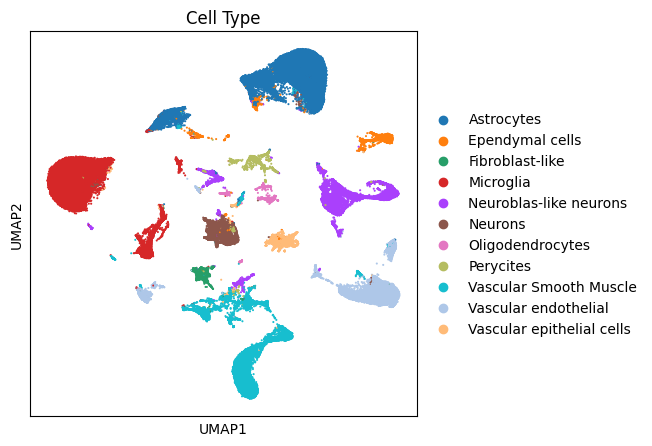

In [58]:
with plt.rc_context({'figure.figsize': (5, 5)}): # Use this to set figure params like size and dpi
    sc.pl.umap(adataC, color = ['Cell Type'],size = 9,show=False)#save='clusterumap.png')
    

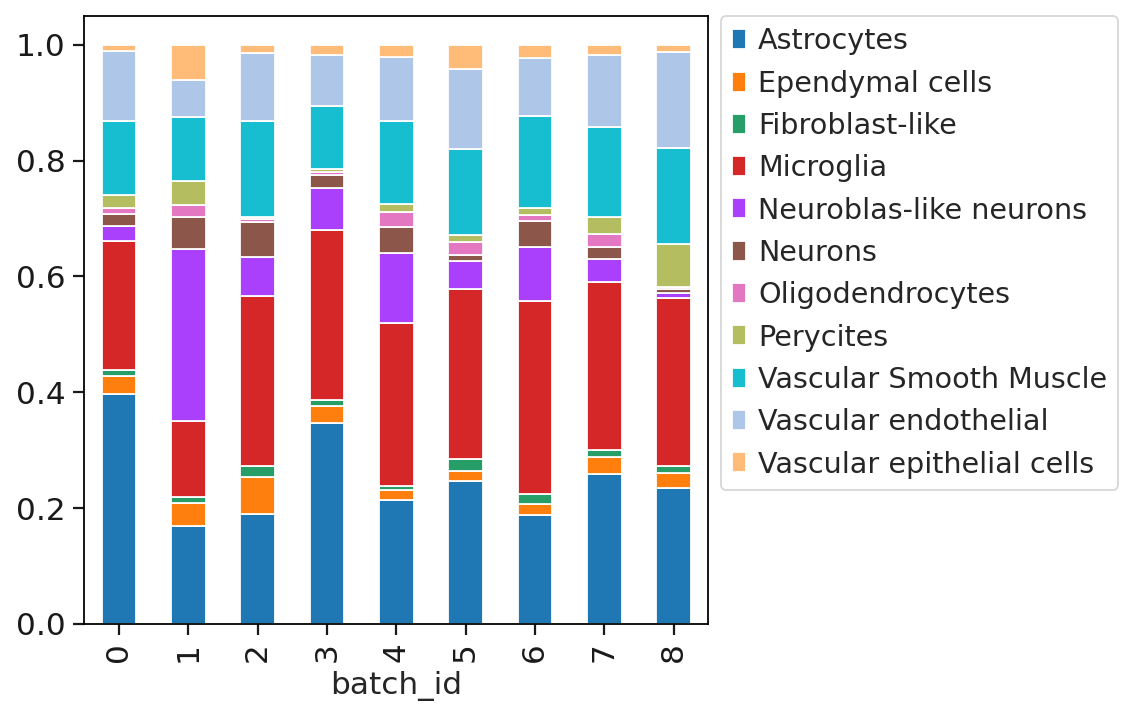

In [1322]:
import pandas as p
tmp1 = p.crosstab(adataC.obs['batch_id'],adataC.obs['Cell Type'], normalize='index')

with plt.rc_context({'figure.figsize': (5, 5)}):  # Use this to set figure params like size and dpi
    tmp1.plot.bar(stacked=True)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    #plt.xticks(rotation=45)
    plt.grid(False)

harmomy

In [64]:
import scanpy.external as sce

In [65]:
sce.pp.harmony_integrate(adataC, 'batch_id')

2023-09-17 13:54:19,617 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-09-17 13:54:35,406 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-09-17 13:54:36,057 - harmonypy - INFO - Iteration 1 of 10
2023-09-17 13:55:34,346 - harmonypy - INFO - Iteration 2 of 10
2023-09-17 13:56:32,391 - harmonypy - INFO - Iteration 3 of 10
2023-09-17 13:57:19,732 - harmonypy - INFO - Iteration 4 of 10
2023-09-17 13:58:04,136 - harmonypy - INFO - Iteration 5 of 10
2023-09-17 13:58:21,495 - harmonypy - INFO - Iteration 6 of 10
2023-09-17 13:58:38,973 - harmonypy - INFO - Iteration 7 of 10
2023-09-17 13:58:56,439 - harmonypy - INFO - Iteration 8 of 10
2023-09-17 13:59:13,673 - harmonypy - INFO - Iteration 9 of 10
2023-09-17 13:59:30,941 - harmonypy - INFO - Converged after 9 iterations


In [66]:
'X_pca_harmony' in adataC.obsm

True

In [67]:
adataC

AnnData object with n_obs × n_vars = 176566 × 17002
    obs: 'barcode_sequence', 'hash_id', 'htoByMax', 'mouse', 'unmapped', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mito_frac', 'pheno_leiden', 'Neurons_markers', 'Microglia _markers', 'Astrocytes_markers', 'Oligodendrocytes_markers', 'Fibroblast-like cells_markers', 'Vascular epithelial cells_markers', 'Vascular endothelial Cells_markers', 'Pericytes_markers', 'Vascular smooth muscle cells_markers', 'Neuroblast-like neurons_markers', 'Ependymal cells_markers'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'id_hvg', 'pca', 'loadings', 'neighbors_30', 'umap', 'batch_id_col

In [68]:
sc.pp.neighbors(adataC, n_neighbors=30, use_rep='X_pca_harmony', metric='euclidean', 
                key_added='neighbors_30_corrected')

In [69]:
sc.tl.umap(adataC, neighbors_key = 'neighbors_30_corrected', min_dist=0.1)

/opt/anaconda3/envs/sc_analysis/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/anaconda3/envs/sc_analysis/lib/python3.8/site-packages/scanpy/plotting/_utils.py:314: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


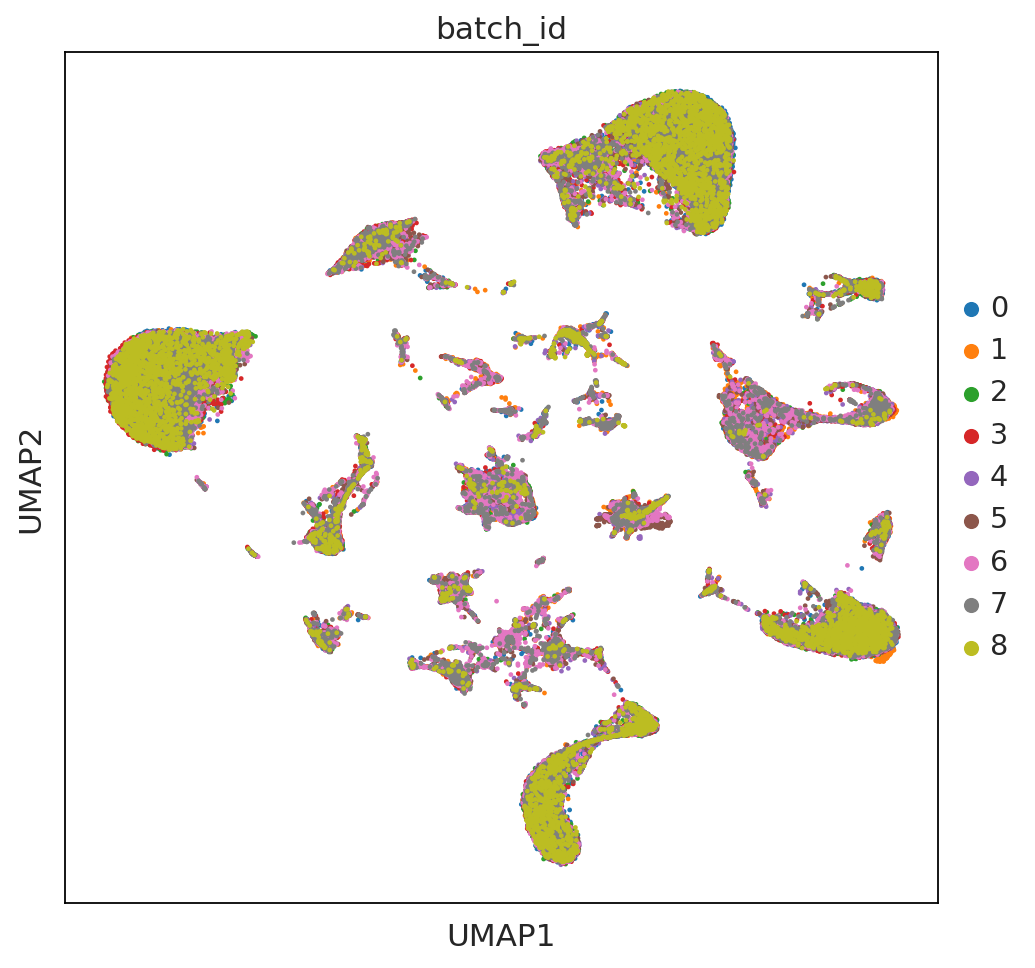

In [426]:
with plt.rc_context({'figure.figsize': (7, 7)}):
    sc.pl.umap(adataC, color = ['batch_id'],size=18)

/opt/anaconda3/envs/sc_analysis/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/anaconda3/envs/sc_analysis/lib/python3.8/site-packages/scanpy/plotting/_utils.py:314: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


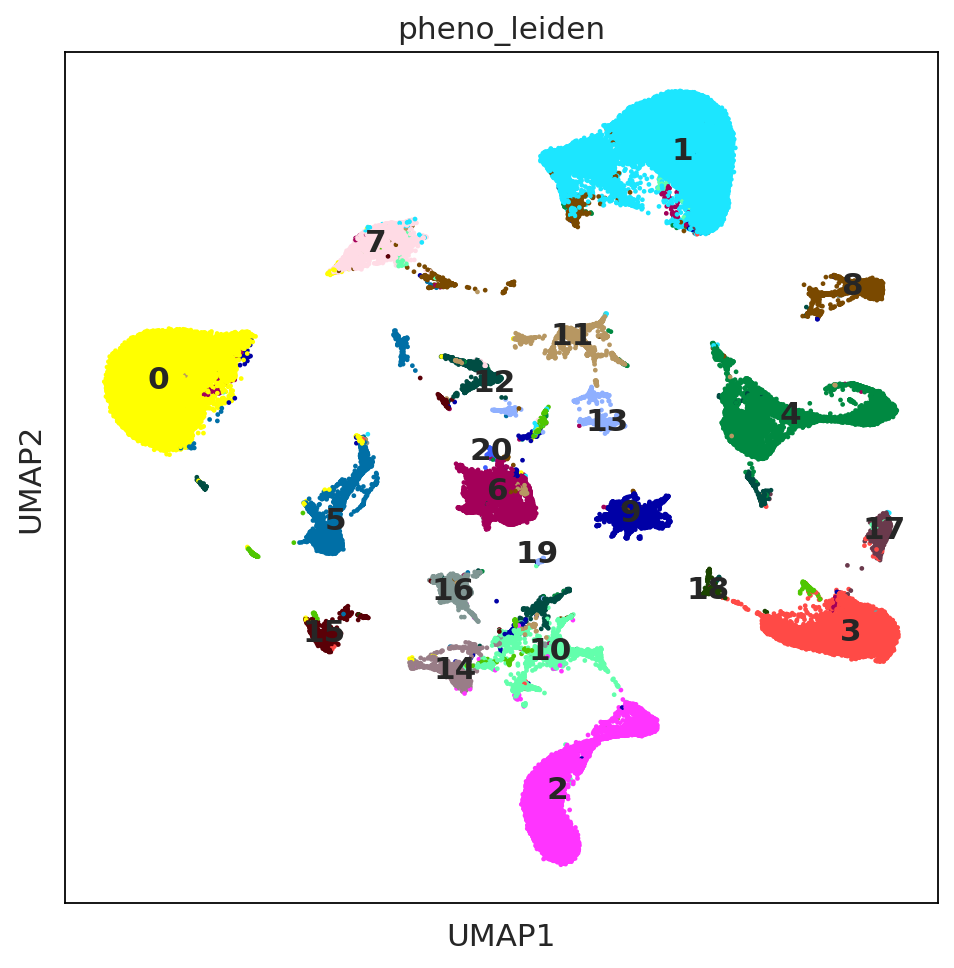

In [427]:
with plt.rc_context({'figure.figsize': (7, 7)}):
    sc.pl.umap(adataC, color = ['pheno_leiden'],size=18,legend_loc='on data')

# Isolate neuron cluster

In [102]:
nonzero_genes = np.sum(adataC.X[id_neuron_cells, :], axis = 0) != 0

In [28]:
neuron_clusters = [6]
id_neuron_cells = np.isin(adataC.obs['pheno_leiden'], neuron_clusters)

In [103]:
adataN = sc.AnnData(adataC.X[id_neuron_cells, :][:, nonzero_genes].copy(), 
                            obs = adataC.obs.loc[id_neuron_cells, :], 
                            var = adataC.var.loc[nonzero_genes, :])

adataN.layers['norm_counts'] = adataC.layers['norm_counts'][id_neuron_cells, :][:, nonzero_genes].copy()
adataN.layers['raw_data'] = adataC.layers['raw_data'][id_neuron_cells, :][:, nonzero_genes].copy()
adataN.layers['zs_norm_log'] = adataC.layers['zs_norm_log'][id_neuron_cells, :][:, nonzero_genes].copy()

In [1544]:
adataN

AnnData object with n_obs × n_vars = 5535 × 16025
    obs: 'barcode_sequence', 'hash_id', 'htoByMax', 'mouse', 'unmapped', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mito_frac', 'pheno_leiden', 'Neurons_markers', 'Microglia _markers', 'Astrocytes_markers', 'Oligodendrocytes_markers', 'Fibroblast-like cells_markers', 'Vascular epithelial cells_markers', 'Vascular endothelial Cells_markers', 'Pericytes_markers', 'Vascular smooth muscle cells_markers', 'Neuroblast-like neurons_markers', 'Ependymal cells_markers', 'Cell Type', 'anterior', 'posterior', 'glu', 'gad2', 'Neurotranstmitter', 'remoteChen', 'earlyRao', 'lateRao', 't2', 't6', 'r21', 'r22', 'r81', 'r82', 'r151', 'r152', 'cc'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_c

## Remove genes with 'RIK'

In [105]:
rk_genes = adataN.var_names[adataN.var_names.str.endswith('RIK')]

In [106]:
index_rk_genes = [adataN.var_names.get_loc(j) for j in rk_genes]

In [107]:
rk_g = np.in1d(adataN.var_names.values.astype(str), rk_genes)
adataN = adataN[:,~rk_g]

## HVG, PCA, UMAP, Clustering

In [108]:
#Determine highly variable genes
sc.pp.highly_variable_genes(adataN, layer = 'raw_data', n_top_genes = 2100, flavor = 'seurat_v3')

/opt/anaconda3/envs/sc_analysis/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [109]:
adataN.uns['id_hvg'] = np.where(adataN.var['highly_variable'])[0]

In [110]:
# PCA
sc.tl.pca(adataN, n_comps=100, use_highly_variable=None)

In [111]:
# ensure that loadings of only HVG are kept track of
adataN.uns['loadings'] = adataN.varm['PCs'][adataN.var['highly_variable'], :]#'highly_variable'

In [112]:
#30 components enough to explain variance 
adataN.obsm['X_pca'] = adataN.obsm['X_pca'][:, 0:25]

# we want to update the loadings adata.uns['loadings'] and 
#adata.varm['PCs'] to reflect only the top 30 principal components
adataN.varm['PCs'] = adataN.varm['PCs'][:, 0:25]
adataN.uns['loadings'] = adataN.uns['loadings'][:, 0:25]

In [113]:
sc.pp.neighbors(adataN, n_neighbors=30, use_rep='X_pca', metric='euclidean', key_added='neighbors_30')

In [114]:
# UMAP, FDL using the nearest neighbors
sc.tl.umap(adataN, neighbors_key = 'neighbors_30', min_dist=0.15)

/Users/andrea/anaconda3/envs/sc_analysis/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


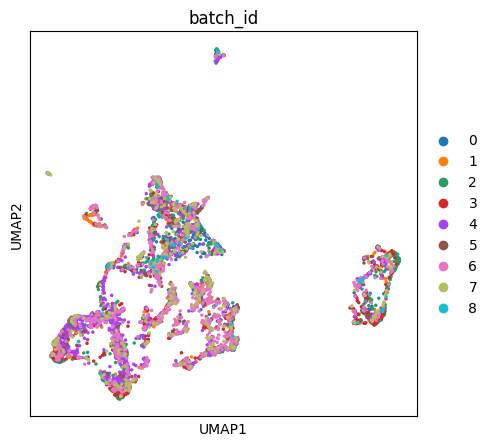

In [8]:
#%matplotlib inline
with plt.rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adataN, color = 'batch_id',s=25,show=False)

/opt/anaconda3/envs/sc_analysis/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


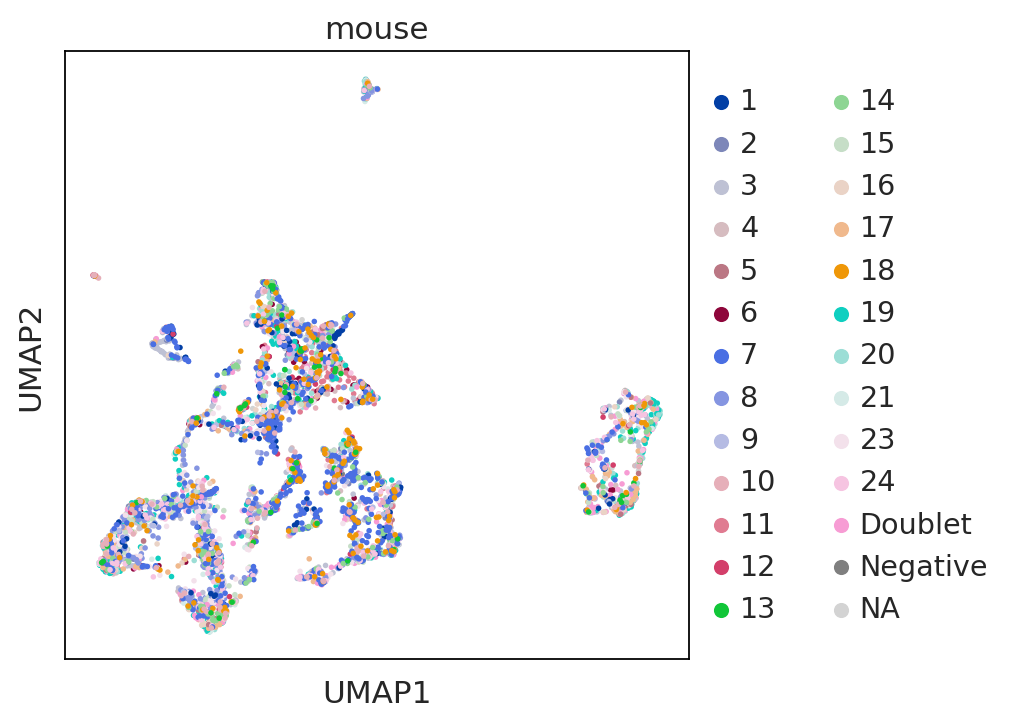

In [423]:
with plt.rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adataN, color = 'mouse',s=25,show=False)

In [118]:
#clustering
sc.external.tl.phenograph(adataN, clustering_algo='leiden', k=30, jaccard=True, primary_metric='euclidean', 
                          resolution_parameter = 0.1)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.06069517135620117 seconds
Jaccard graph constructed in 1.7581539154052734 seconds
Running Leiden optimization
Leiden completed in 0.11426496505737305 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 3.0785181522369385 seconds


In [119]:
adataN.obsp['pheno_jaccard_ig'] = scipy.sparse.csr_matrix(adataN.obsp['pheno_jaccard_ig'])

/opt/anaconda3/envs/sc_analysis/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


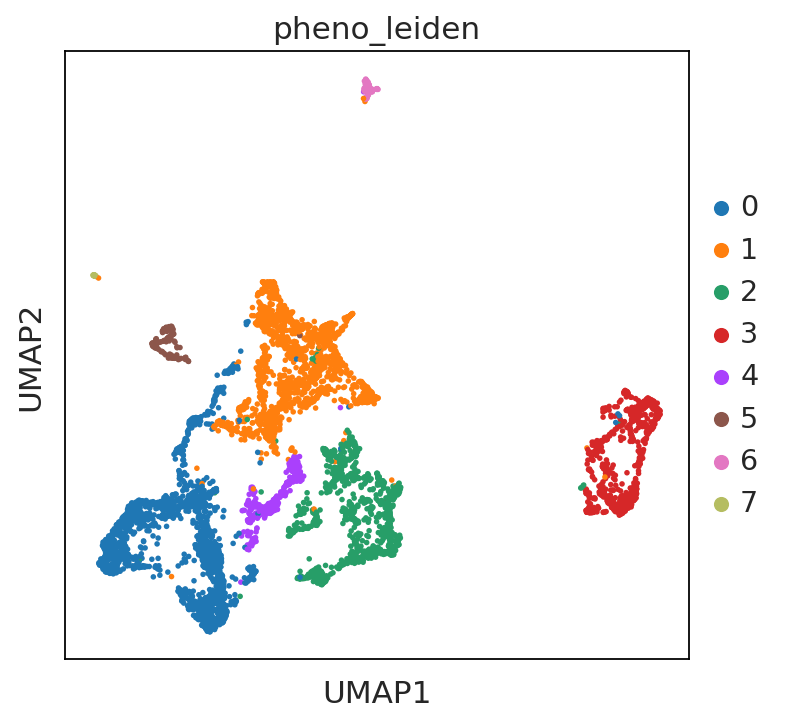

In [422]:
with plt.rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adataN, color = ['pheno_leiden'],s=25,show=False)

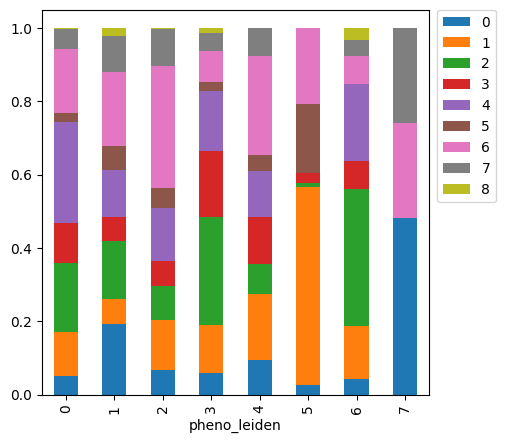

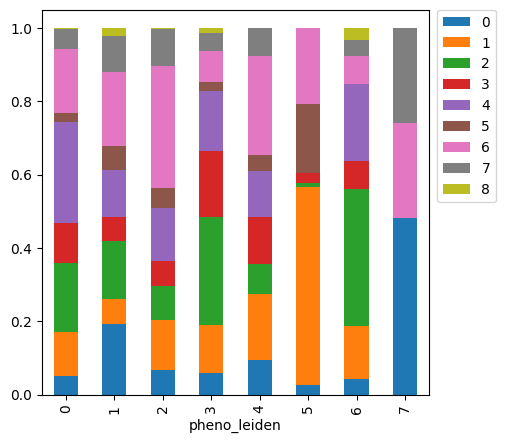

In [13]:
tmp2 = p.crosstab(adataN.obs['pheno_leiden'],adataN.obs['batch_id'], normalize='index')

with plt.rc_context({'figure.figsize': (5, 5)}):  # Use this to set figure params like size and dpi
    tmp2.plot.bar(stacked=True)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    #plt.xticks(rotation=45)
    plt.grid(False)
    plt.show()

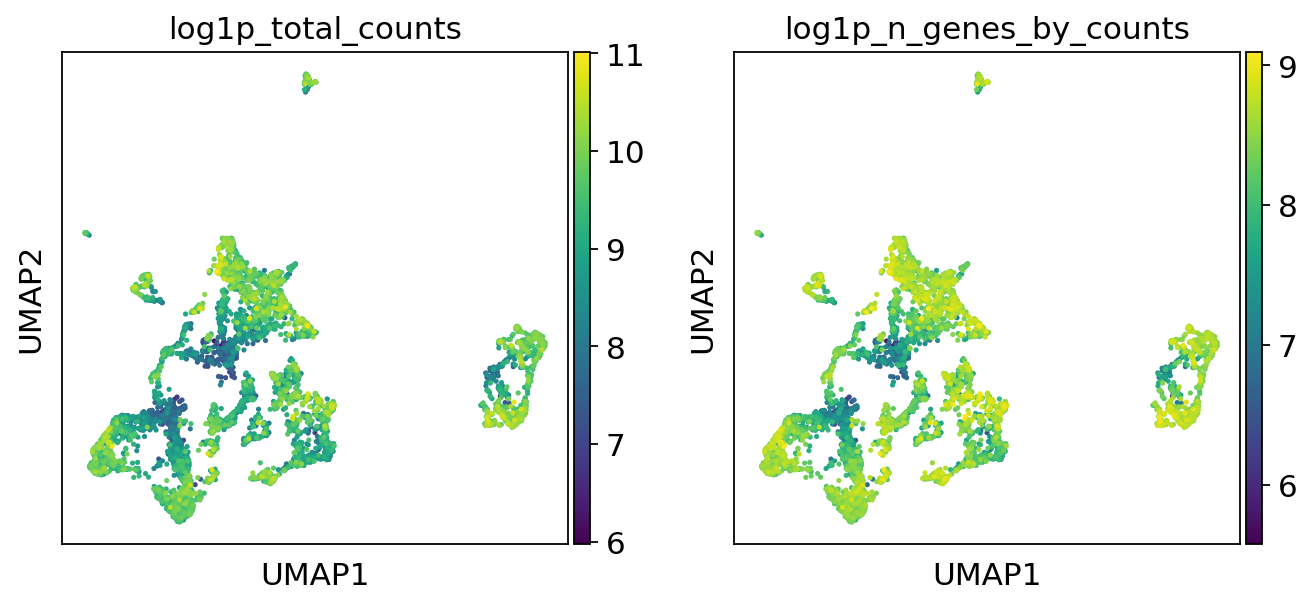

In [122]:
sc.pl.umap(adataN, color = ['log1p_total_counts', 'log1p_n_genes_by_counts'], cmap = 'viridis')

UMAP by PCA

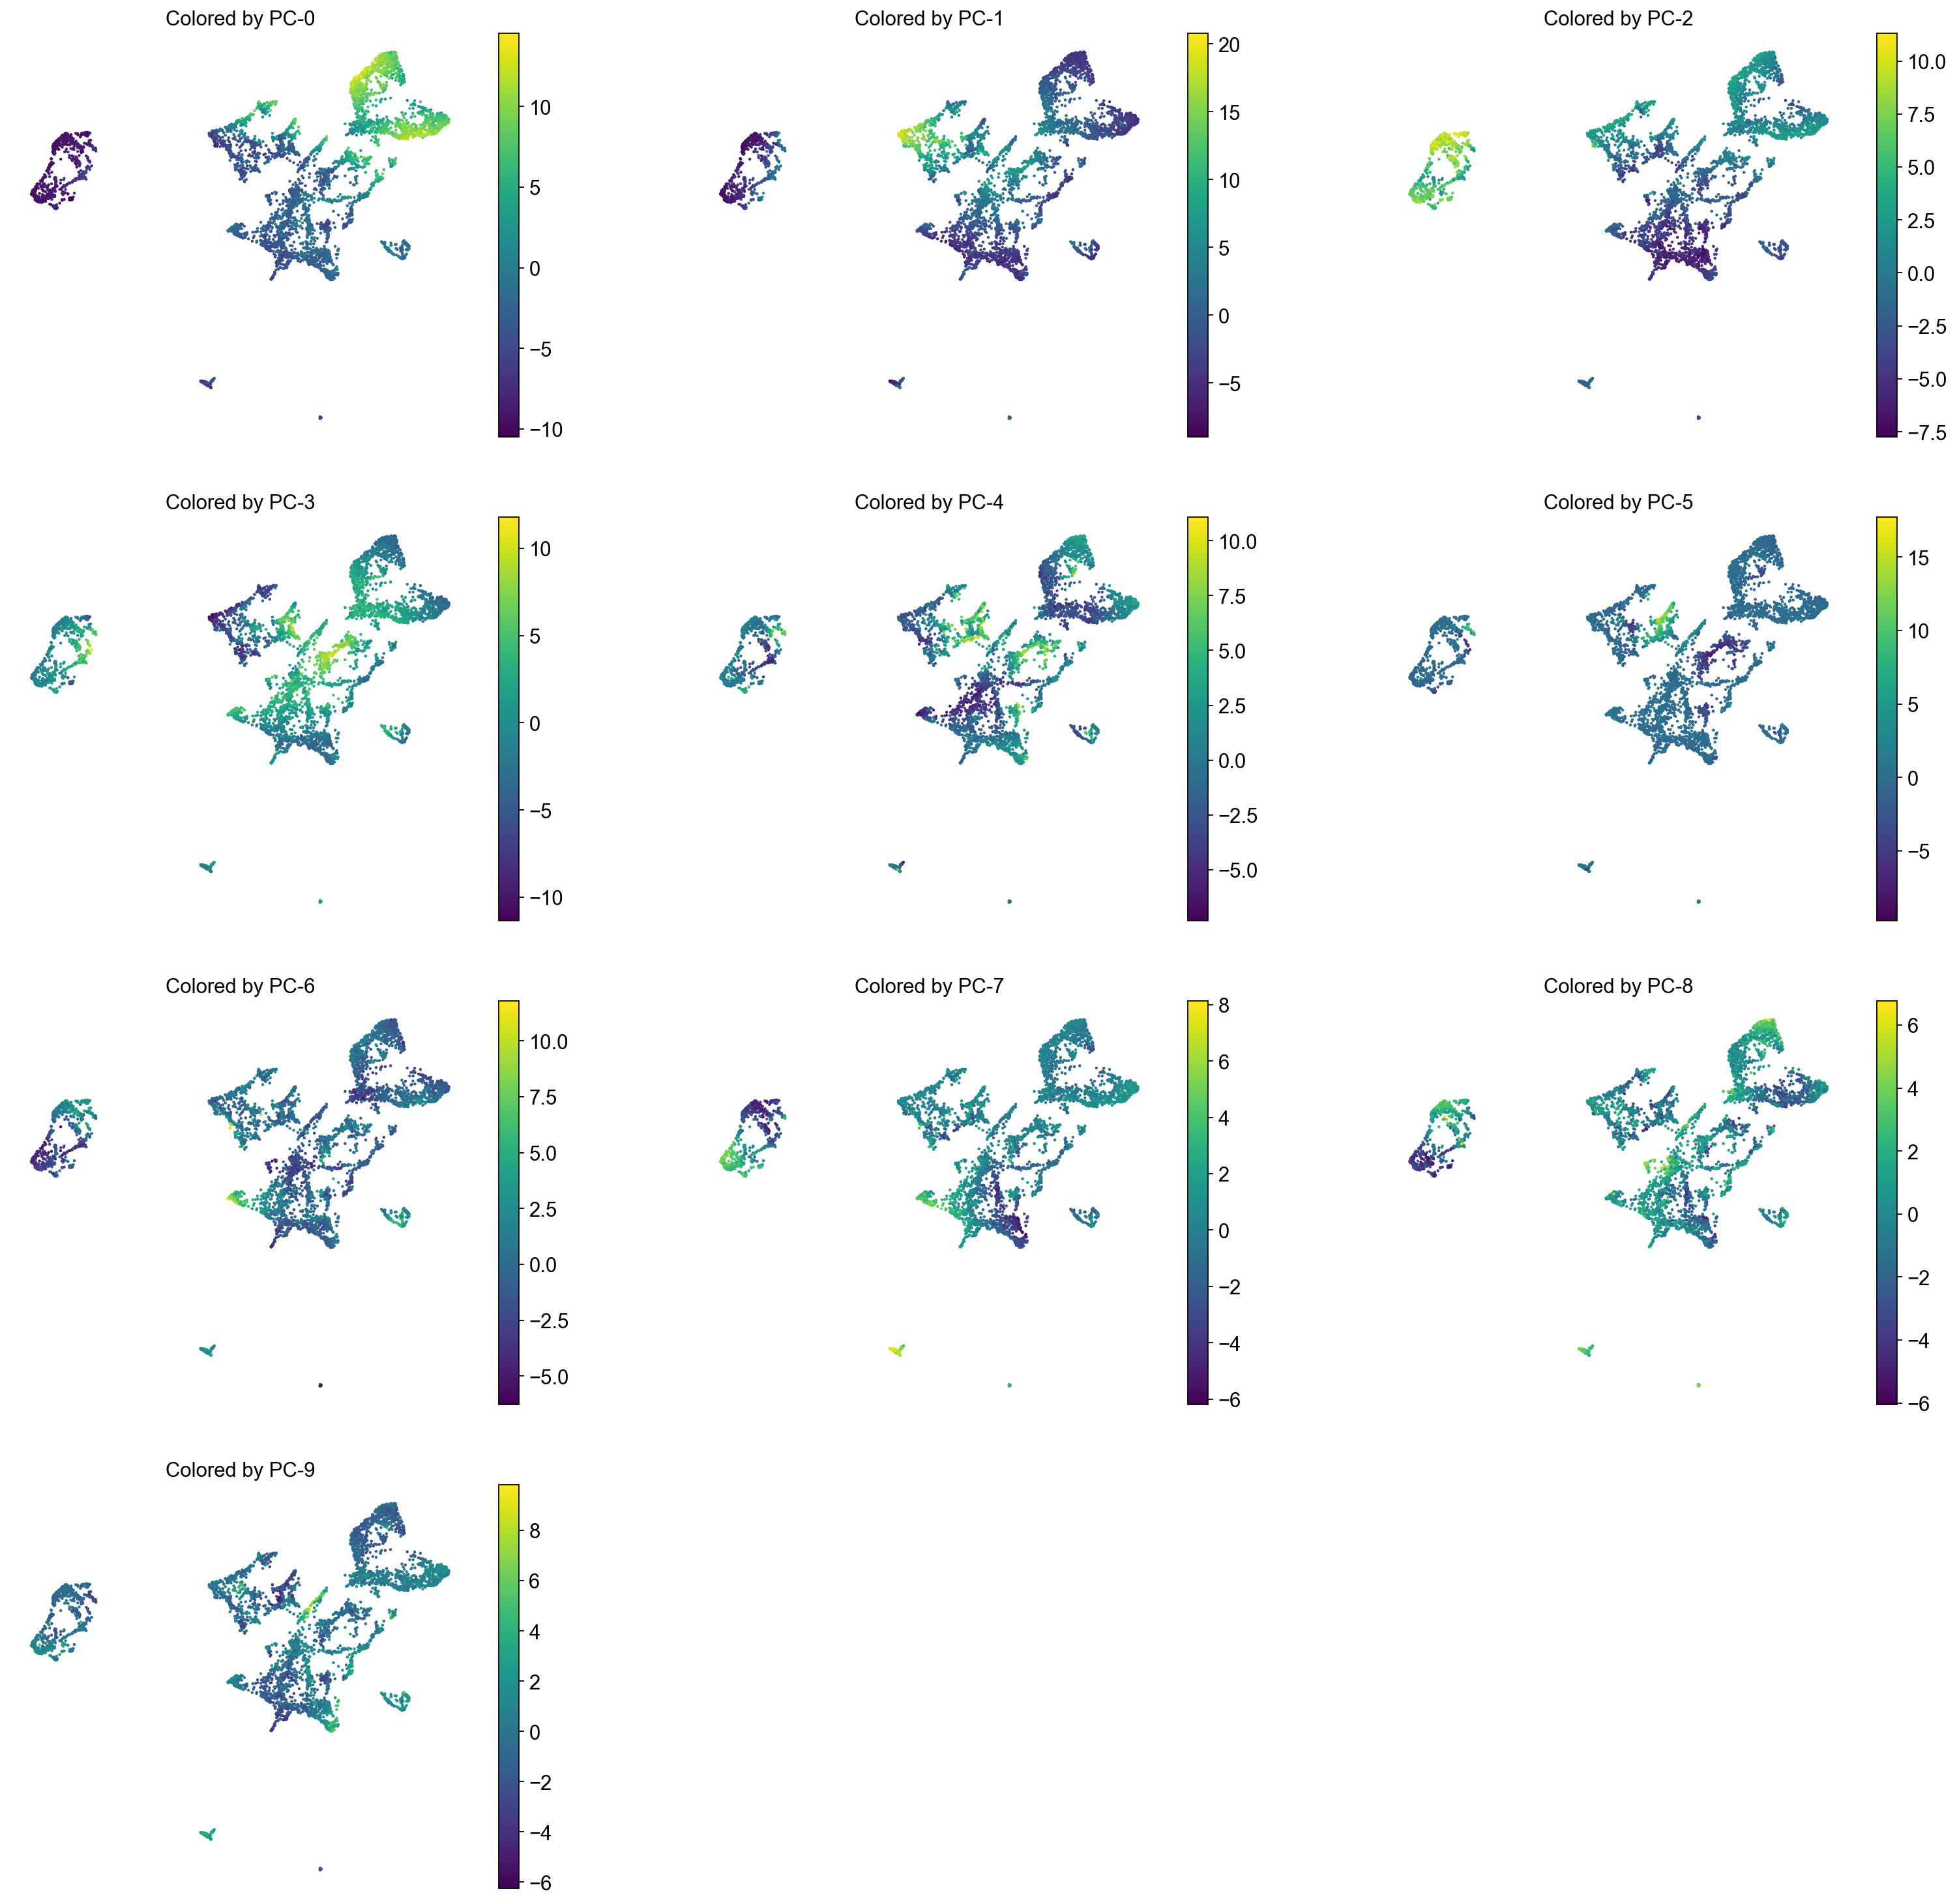

In [103]:
nrows = 10
ncols = 3
fig = plt.figure(figsize = (8*ncols, 6*nrows))
for j in range(10):
    ax = fig.add_subplot(nrows, ncols, j+1)
    im1 = ax.scatter(adataN.obsm['X_umap'][:, 0], adataN.obsm['X_umap'][:, 1], s = 1, 
                     c = adataN.obsm['X_pca'][:, j])
    ax.axis('off')
    fig.colorbar(im1)
    ax.set_title('Colored by PC-' + str(j))

In [104]:
df_loadings = p.DataFrame(adataN.uns['loadings'], 
                           index = adataN.var_names[adataN.var['highly_variable']], 
                           columns = ['PC-' + str(j) for j in range(25)])

In [105]:
#genes explain pcs variability 
np.abs(df_loadings).sort_values(by = 'PC-0', ascending = False)['PC-0'].head(10)

ARPP21     0.231264
PPP3CA     0.193878
PDE10A     0.173667
ATP2B1     0.164620
PENK       0.149625
PPP1R1B    0.146201
GPR88      0.143188
MEIS2      0.139632
FOXP1      0.137899
RGS9       0.123183
Name: PC-0, dtype: float64

## Plot cells per batch

In [123]:
categories = np.unique(adataN.obs['batch_id'])

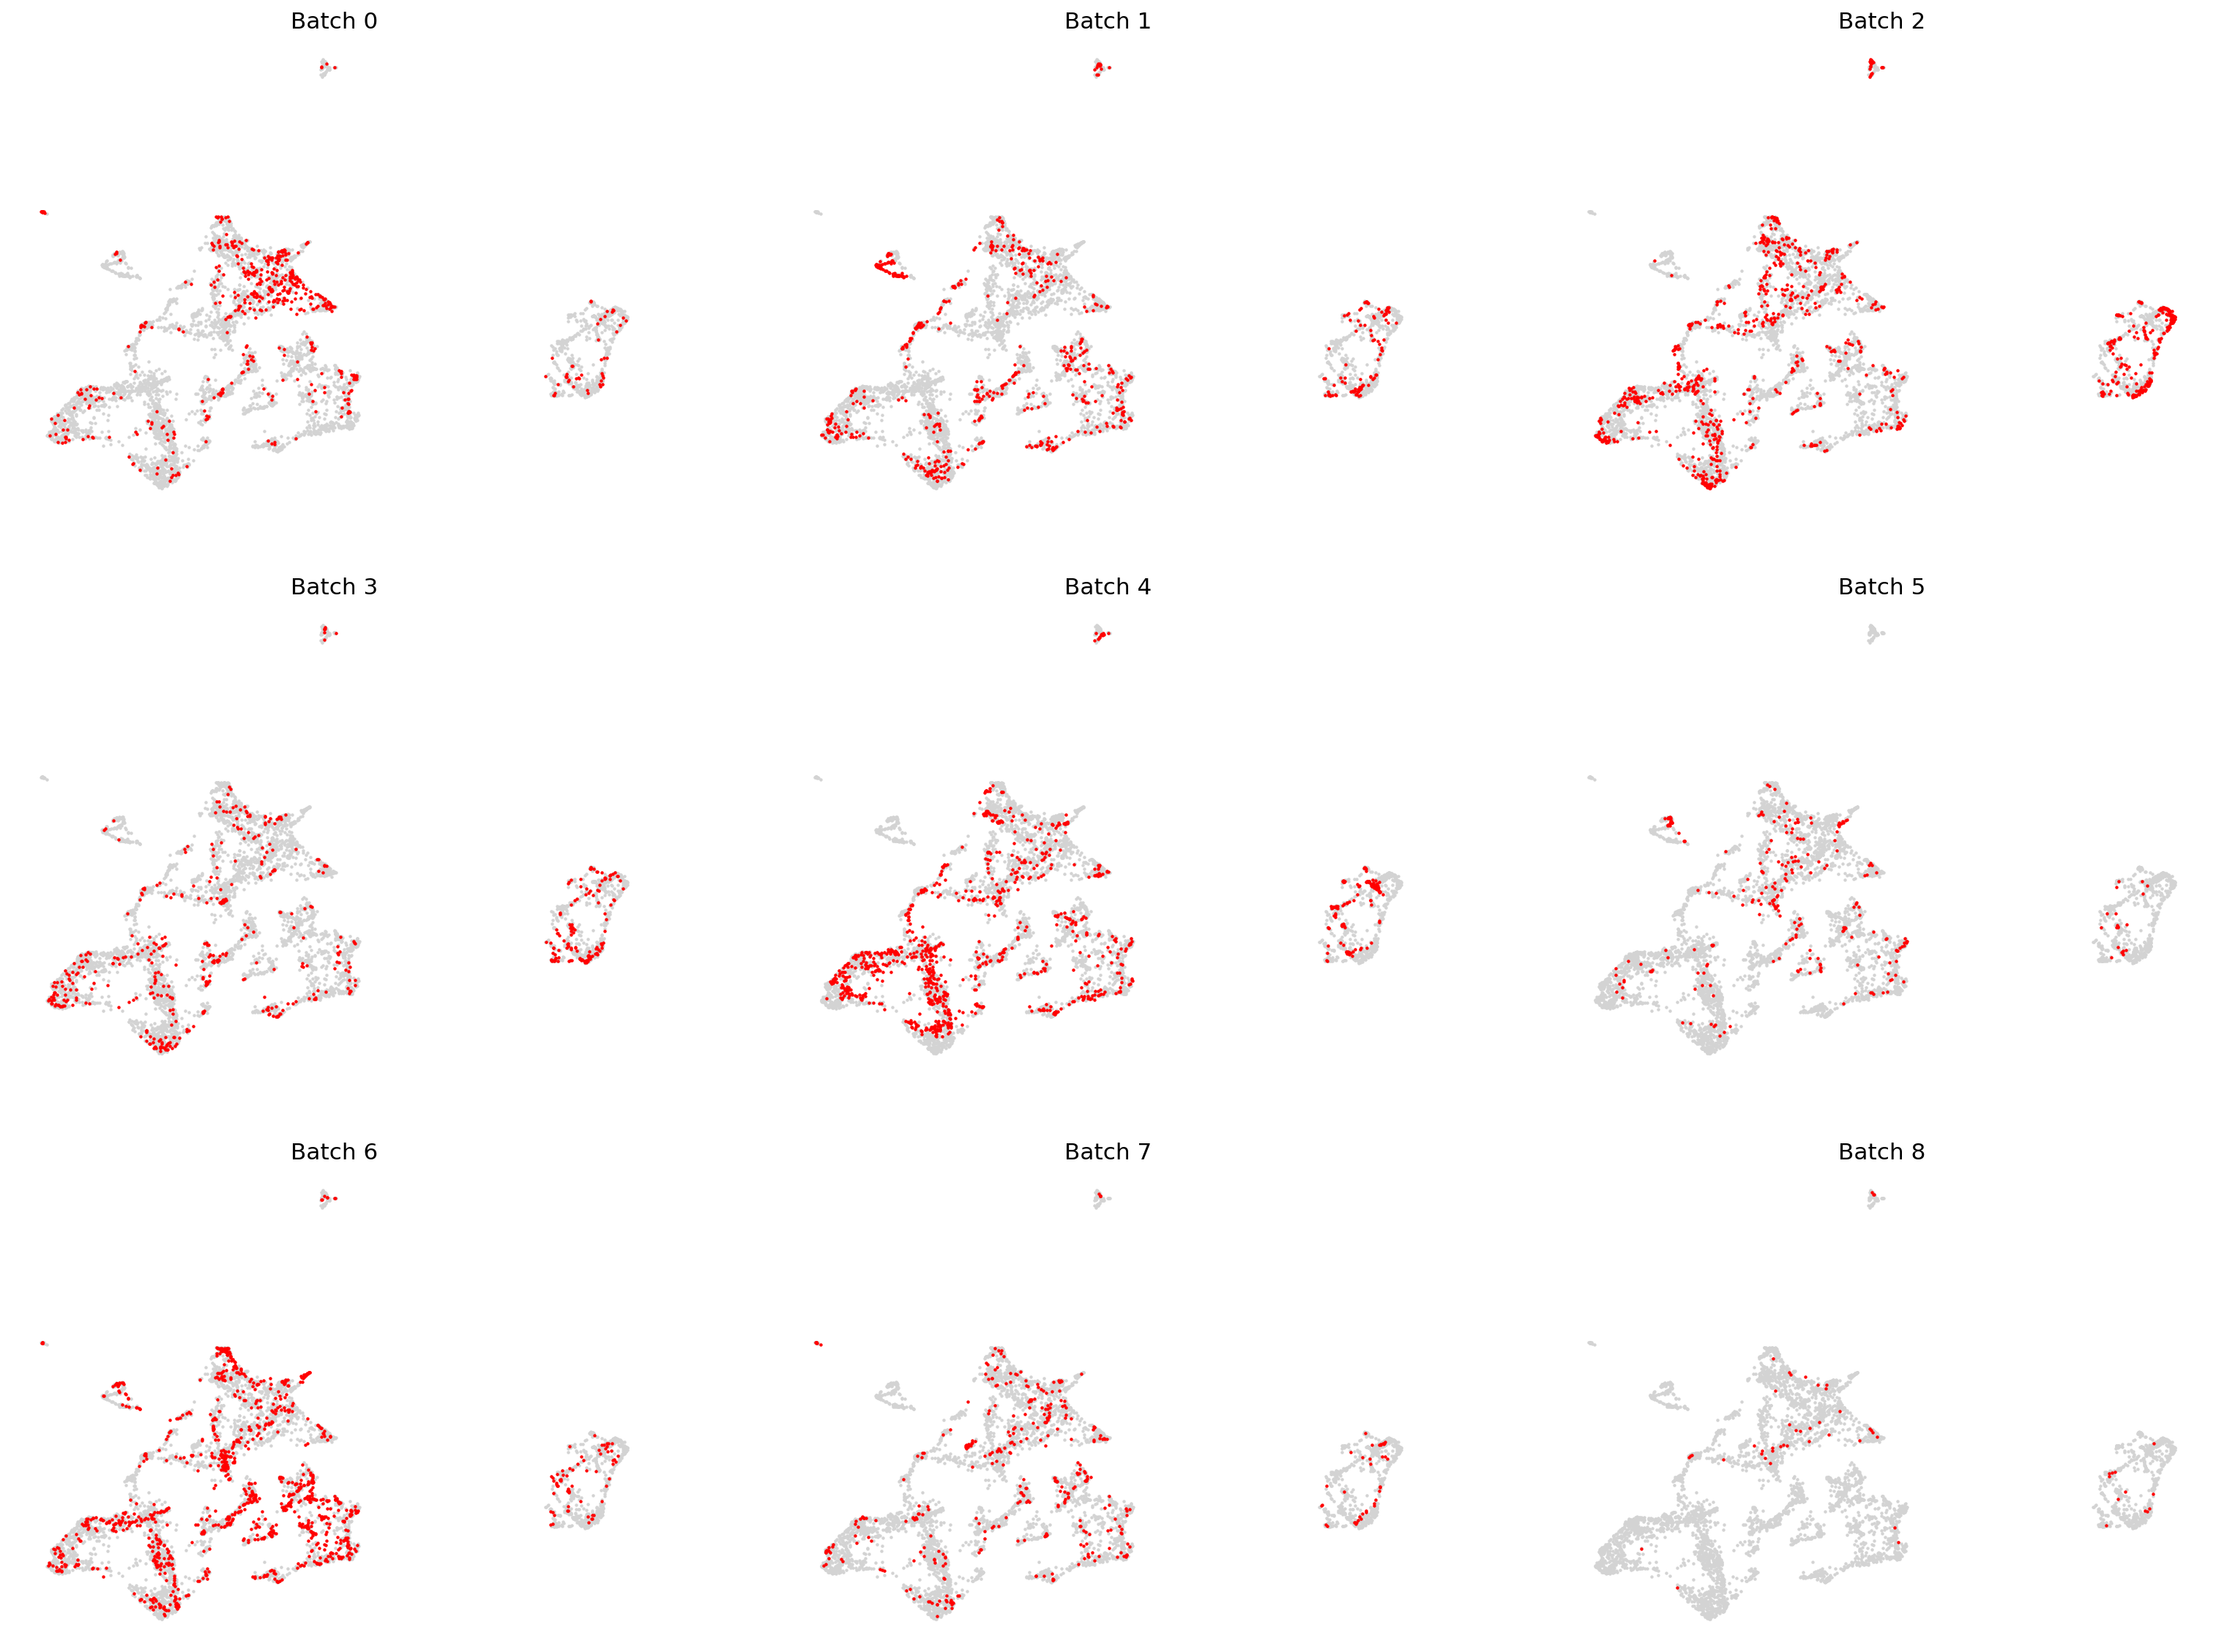

In [128]:
nrows = np.ceil(len(categories)/3)
fig = plt.figure(figsize = (8*3, 6*nrows))
for j, item in enumerate(categories):
    ax = fig.add_subplot(int(nrows), 3, j+1)
    cells_select = adataN.obs['batch_id'] == item
    ax.scatter(adataN.obsm['X_umap'][~cells_select, 0], adataN.obsm['X_umap'][~cells_select, 1], s = 1, c = 'lightgray')
    ax.scatter(adataN.obsm['X_umap'][cells_select, 0], adataN.obsm['X_umap'][cells_select, 1], s = 1, c = 'r')
    ax.axis('off')
    ax.set_title('Batch ' + str(item), fontsize = 14)

## UMAP density graph -  see patterns?

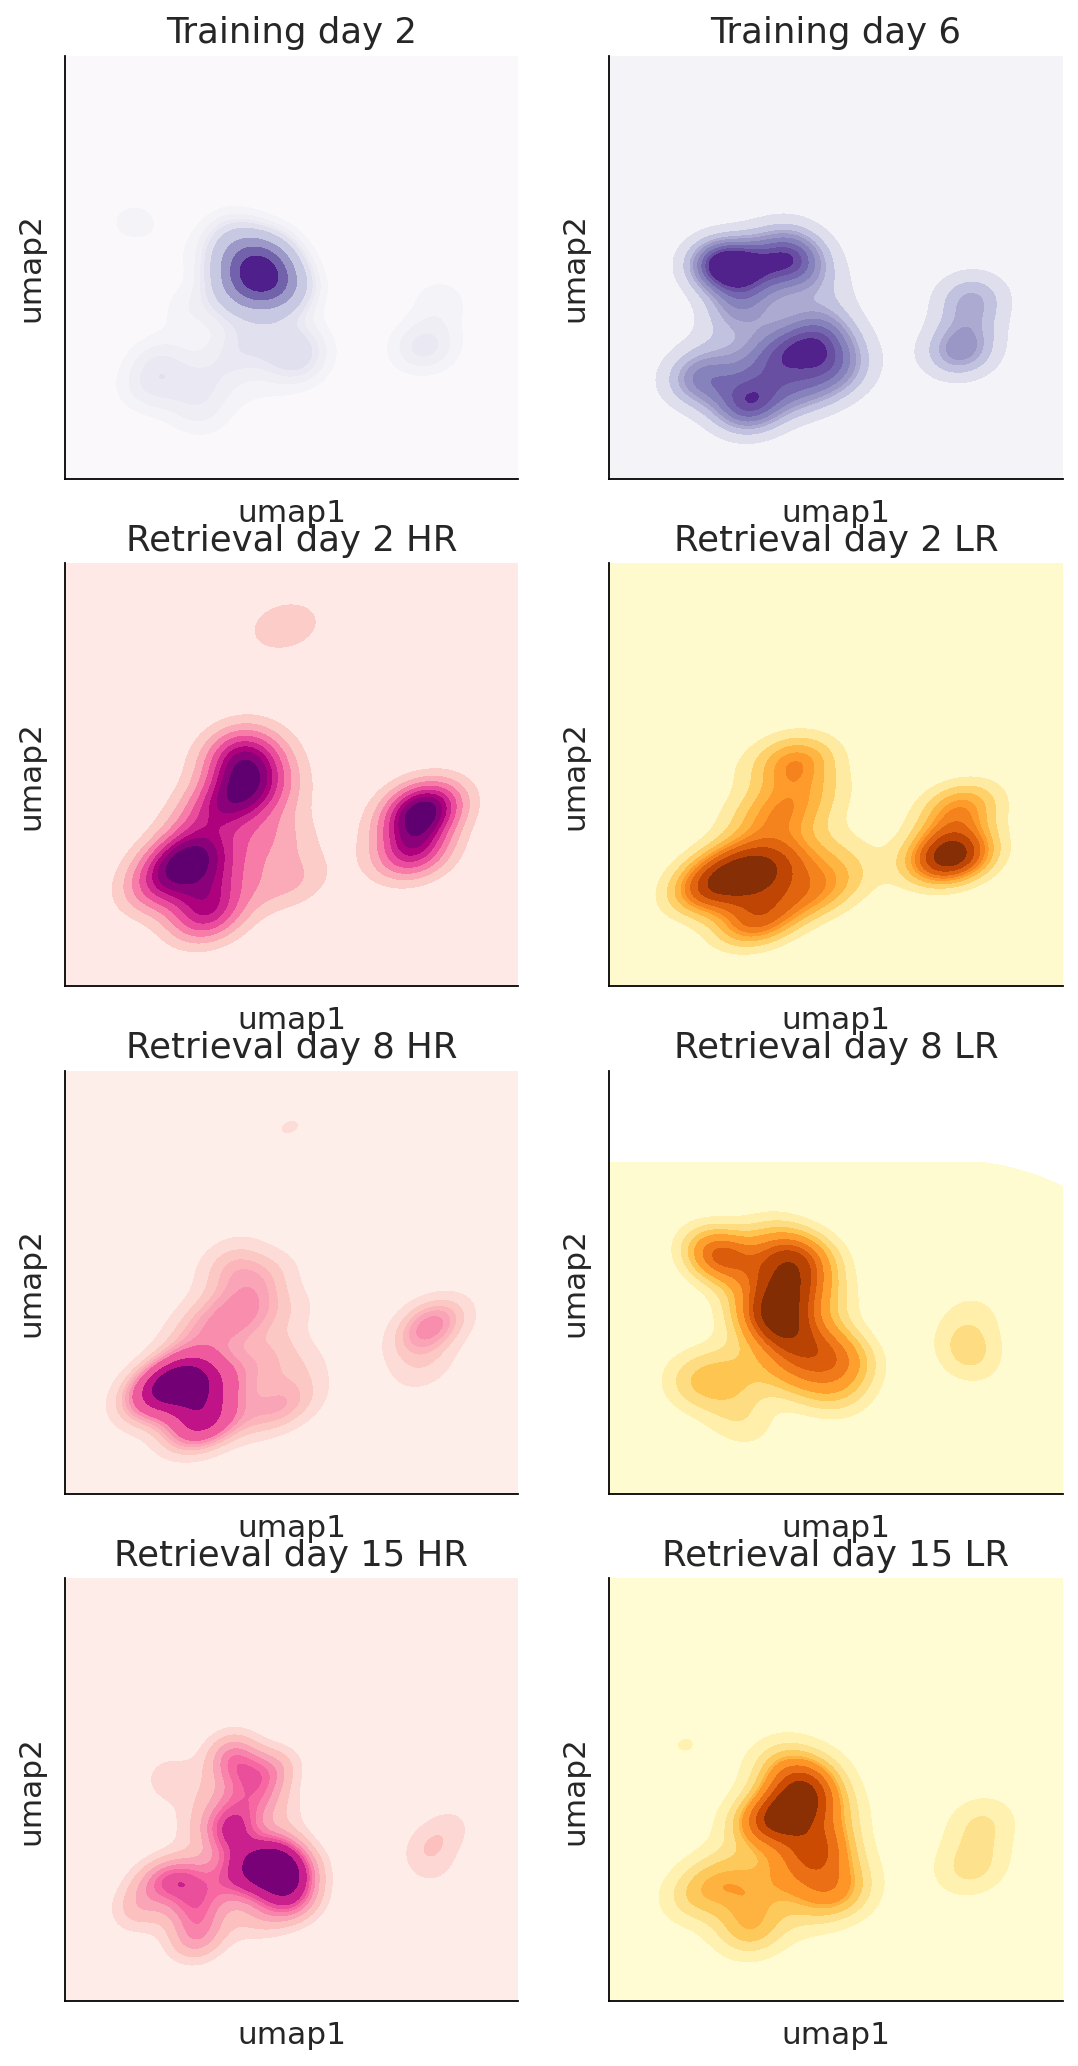

In [1324]:
import seaborn as sns
df_temp = p.DataFrame({'umap_1': adataN.obsm['X_umap'][:, 0],
                        'umap_2': adataN.obsm['X_umap'][:, 1],
                        'batch_id': adataN.obs['batch_id']}, index = adataN.obs.index)


fig = plt.figure(figsize = (4*2, 16))
ax = fig.add_subplot(4,2,1)
sns.kdeplot(data=df_temp[df_temp['batch_id'] == '0'], x="umap_1", y="umap_2",
    fill=True, thresh=0, levels=10, cmap="Purples", ax = ax)
ax.scatter(adataN.obsm['X_umap'][:, 0], adataN.obsm['X_umap'][:, 1], s = 0)
ax.set_xticks([]);
ax.set_yticks([]);
ax.set_title('Training day 2', fontsize = 16)
ax.set_xlabel('umap1')
ax.set_ylabel('umap2')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax = fig.add_subplot(4,2,2)
sns.kdeplot(data=df_temp[df_temp['batch_id'] == '1'], x="umap_1", y="umap_2",
    fill=True, thresh=0, levels=10, cmap="Purples", ax = ax)
ax.scatter(adataN.obsm['X_umap'][:, 0], adataN.obsm['X_umap'][:, 1], s = 0)
ax.set_xticks([]);
ax.set_yticks([]);
ax.set_title('Training day 6', fontsize = 16)
ax.set_xlabel('umap1')
ax.set_ylabel('umap2')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax = fig.add_subplot(4,2,3)
sns.kdeplot(data=df_temp[df_temp['batch_id'] == '2'], x="umap_1", y="umap_2",
    fill=True, thresh=0, levels=10, cmap="RdPu", ax = ax)
ax.scatter(adataN.obsm['X_umap'][:, 0], adataN.obsm['X_umap'][:, 1], s = 0)
ax.set_xticks([]);
ax.set_yticks([]);
ax.set_title('Retrieval day 2 HR', fontsize = 16)
ax.set_xlabel('umap1')
ax.set_ylabel('umap2')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax = fig.add_subplot(4,2,4)
sns.kdeplot(data=df_temp[df_temp['batch_id'] == '3'], x="umap_1", y="umap_2",
    fill=True, thresh=0, levels=10, cmap="YlOrBr", ax = ax)
ax.scatter(adataN.obsm['X_umap'][:, 0], adataN.obsm['X_umap'][:, 1], s = 0)
ax.set_xticks([]);
ax.set_yticks([]);
ax.set_title('Retrieval day 2 LR', fontsize = 16)
ax.set_xlabel('umap1')
ax.set_ylabel('umap2')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax = fig.add_subplot(4,2,5)
sns.kdeplot(data=df_temp[df_temp['batch_id'] == '4'], x="umap_1", y="umap_2",
    fill=True, thresh=0, levels=10, cmap="RdPu", ax = ax)
ax.scatter(adataN.obsm['X_umap'][:, 0], adataN.obsm['X_umap'][:, 1], s = 0)
ax.set_xticks([]);
ax.set_yticks([]);
ax.set_title('Retrieval day 8 HR', fontsize = 16)
ax.set_xlabel('umap1')
ax.set_ylabel('umap2')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax = fig.add_subplot(4,2,6)
sns.kdeplot(data=df_temp[df_temp['batch_id'] == '5'], x="umap_1", y="umap_2",
    fill=True, thresh=0, levels=10, cmap="YlOrBr", ax = ax)
ax.scatter(adataN.obsm['X_umap'][:, 0], adataN.obsm['X_umap'][:, 1], s = 0)
ax.set_xticks([]);
ax.set_yticks([]);
ax.set_title('Retrieval day 8 LR', fontsize = 16)
ax.set_xlabel('umap1')
ax.set_ylabel('umap2')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax = fig.add_subplot(4,2,7)
sns.kdeplot(data=df_temp[df_temp['batch_id'] == '6'], x="umap_1", y="umap_2",
    fill=True, thresh=0, levels=10, cmap="RdPu", ax = ax)
ax.scatter(adataN.obsm['X_umap'][:, 0], adataN.obsm['X_umap'][:, 1], s = 0)
ax.set_xticks([]);
ax.set_yticks([]);
ax.set_title('Retrieval day 15 HR', fontsize = 16)
ax.set_xlabel('umap1')
ax.set_ylabel('umap2')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


ax = fig.add_subplot(4,2,8)
sns.kdeplot(data=df_temp[df_temp['batch_id'] == '7'], x="umap_1", y="umap_2",
    fill=True, thresh=0, levels=10, cmap="YlOrBr", ax = ax)
ax.scatter(adataN.obsm['X_umap'][:, 0], adataN.obsm['X_umap'][:, 1], s = 0)
ax.set_xticks([]);
ax.set_yticks([]);
ax.set_title('Retrieval day 15 LR', fontsize = 16)
ax.set_xlabel('umap1')
ax.set_ylabel('umap2')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('/Users/raja/Desktop/imagesMSK/illustrator/DensitiesUmap.svg',bbox_inches="tight")

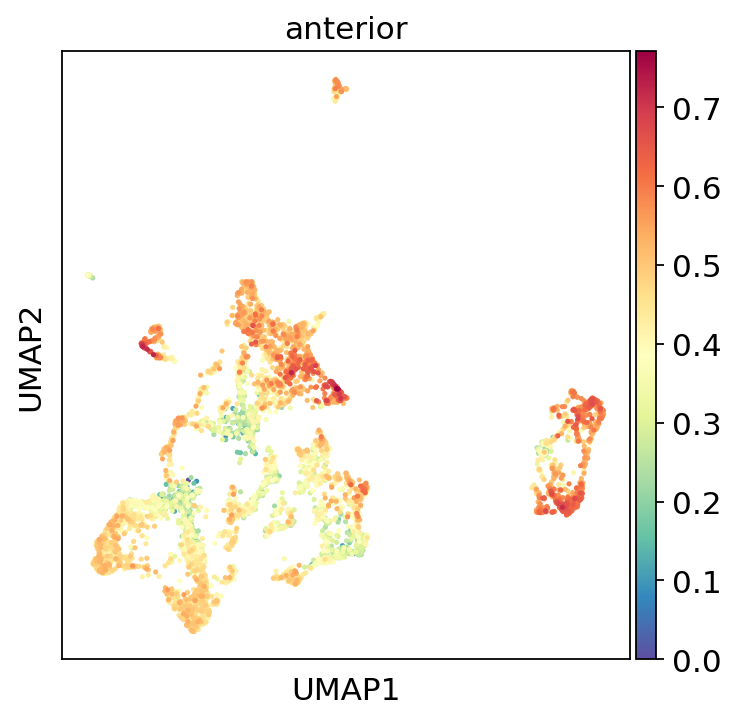

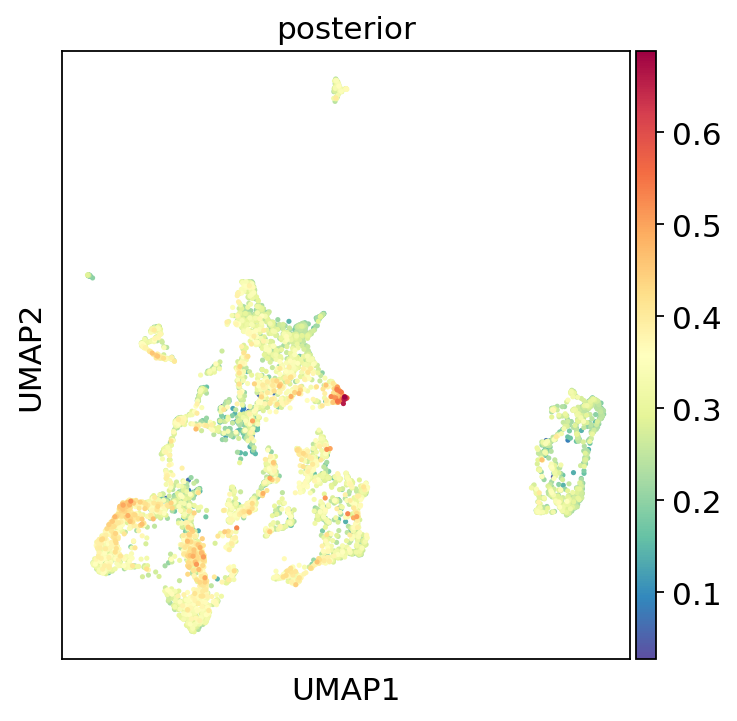

In [138]:
##label clusters with custom list 
neuron_markers = p.read_csv('/Users/raja/Desktop/cp/antpost.csv')
neuron_list = list(neuron_markers.columns.values)

neuron_dic = {}

for c in neuron_list:
    cc = np.unique(np.array(neuron_markers[c].values.tolist()))
    neuron_dic[c] = [x for x in cc if str(x) != 'nan']


# toplot_dic
for i in neuron_dic.keys():
    neu = neuron_dic[i]
    genes_neu = []
    for g in neu:
        genes_neu = np.append(genes_neu,g.upper())
    
    top_genesNeu = np.intersect1d(adataN.var.index, genes_neu)
    #val = np.sum(adataN[:,top_genesNeu].layers['zs_norm_log'],axis=1)
    val = np.sum(adataN[:,top_genesNeu].X,axis=1)
    val = np.array(val).flatten()
    label = "%s"%(i)
    adataN.obs[label] = val/len(top_genesNeu)
    with plt.rc_context({'figure.figsize': (5, 5)}):
        sc.pl.umap(adataN, color = label, color_map='Spectral_r')#,vmin= '0',vmax='1')

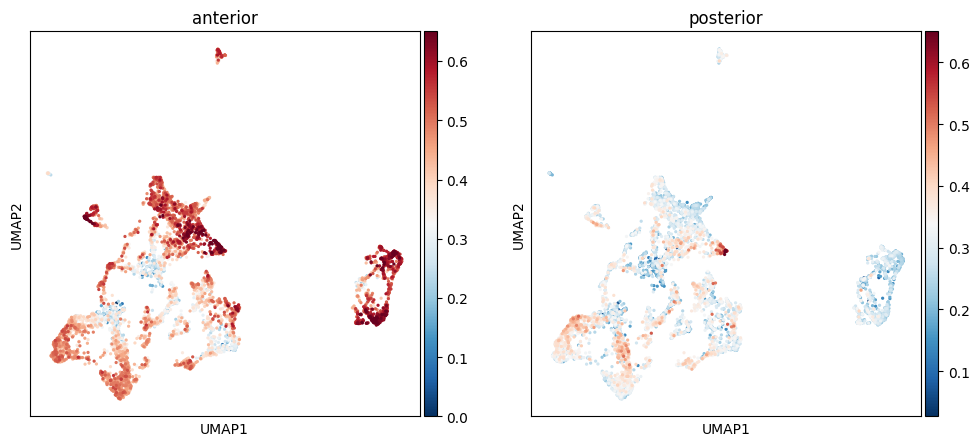

In [168]:
with plt.rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adataN, color = ['anterior','posterior'],color_map='RdBu_r',show=False,vmax=0.65)

In [80]:
#top genes per cluster
sc.tl.rank_genes_groups(adataN, groupby = 'pheno_leiden', method = 'wilcoxon')

In [447]:
sc.get.rank_genes_groups_df(adataN, group = '1').head(15)

names     scores  logfoldchanges         pvals     pvals_adj
0    PABPC1  15.776785        0.957987  4.495059e-56  1.298098e-52
1      SAFB  15.722190        0.898303  1.065751e-55  2.638037e-52
2     SKP1A  15.250600        1.043983  1.631272e-52  3.533131e-49
3    SNRPD3  14.577810        0.996890  3.887890e-48  6.124133e-45
4      CBX3  13.579470        0.841329  5.300893e-42  7.654048e-39
5    HP1BP3  12.906623        0.716821  4.130195e-38  5.504915e-35
6    TIMM22  11.466223        1.204082  1.949865e-30  1.987371e-27
7      NFIB  11.448179        1.192265  2.401356e-30  2.311572e-27
8     VDAC1  11.341249        0.755455  8.196543e-30  7.474816e-27
9       NCL  11.276397        0.649076  1.716328e-29  1.486940e-26
10    PHPT1  10.611632        0.886513  2.631117e-26  2.170922e-23
11    HMGB1  10.553999        0.676296  4.867986e-26  3.833982e-23
12  PHYHIPL  10.472502        0.845252  1.155477e-25  8.342062e-23
13  DENND4A  10.401361        0.805848  2.444152e-25  1.693993e-22
14    ZMAT2  10.378190        0.698400  3.116279e-25  2.076760e-22

## Map thalamus markers 

In [611]:
mark_thalamus = {'Neurons':['SNAP25','SYT1'],
                 'Excitatory neurons':['SYNPO2','SLC17A6','SLC17A7','FOXP2','CBLN4','SHOX2','SLC1A1','SLC1A6'],
                'Inhibitory neurons':['SIX3','ST8SIA4','PKIB','GAD1','GAD2','SLC32A1','SLC6A1','GABRG1']}

/opt/anaconda3/envs/sc_analysis/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


Text(0, 0.5, 'Clusters')

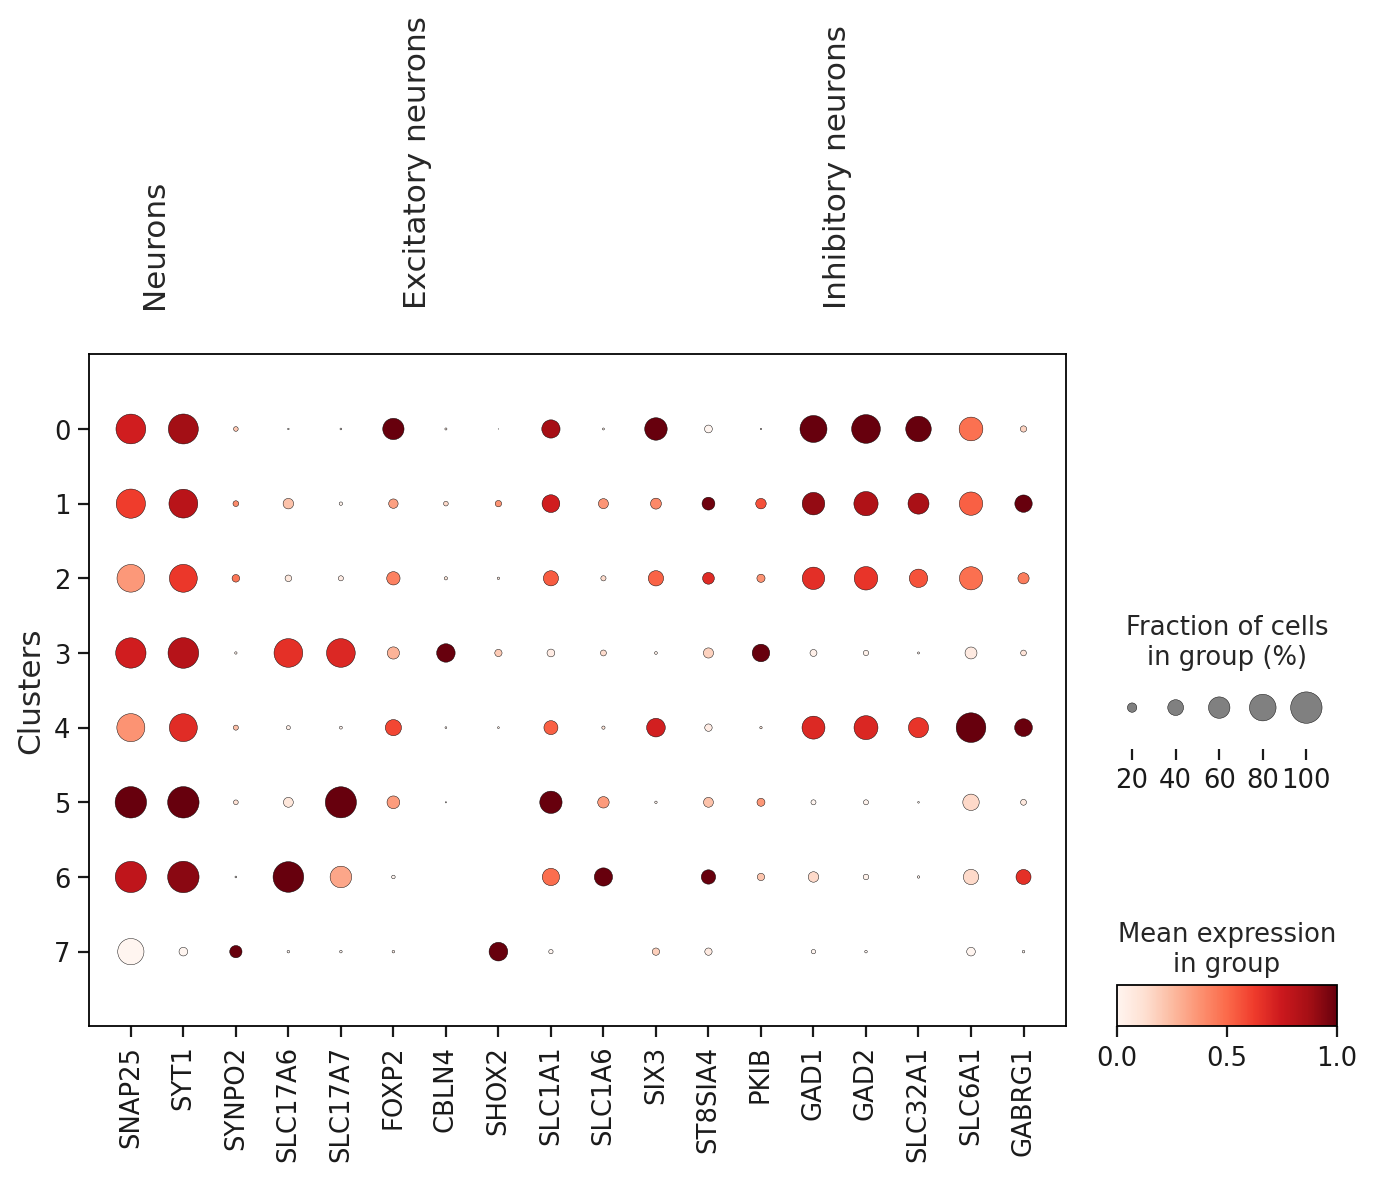

In [613]:
sc.set_figure_params(scanpy=True, fontsize = 14)

fig = plt.figure(figsize = (5*2, 5*1.5))
ax1 = fig.add_subplot(1, 1, 1)
ac = sc.pl.dotplot(adataN, mark_thalamus, groupby = 'pheno_leiden', log=True, 
                   show = False, ax = ax1,standard_scale = 'var')
ac['mainplot_ax'].set_ylabel('Clusters')

In [143]:
sc.tl.rank_genes_groups(adataN, groupby = 'pheno_leiden', method = 'wilcoxon')

/opt/anaconda3/envs/sc_analysis/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


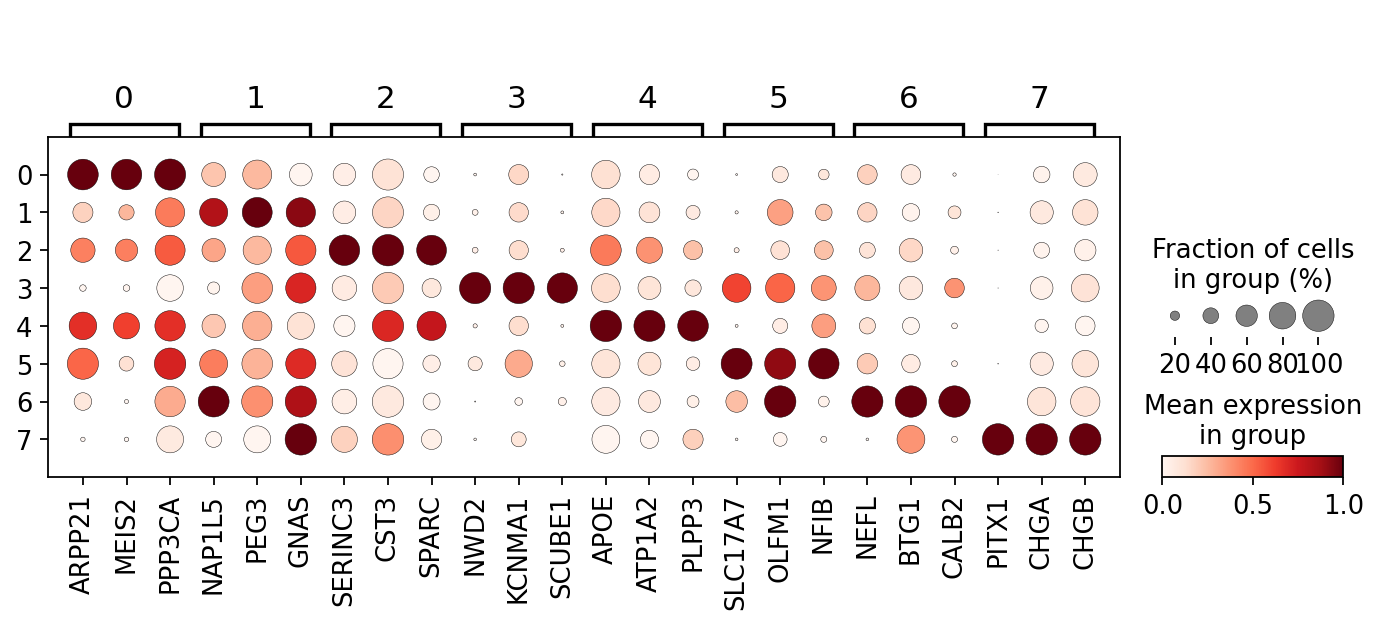

In [144]:
sc.pl.rank_genes_groups_dotplot(adataN,n_genes=3,dendrogram=False,standard_scale = 'var')

In [146]:
#Some glutamatergic cells are in inhbitory cluster so separate cell types by expression levels
geneR = 'SLC17A6'
gene_columnGl = adataN.var_names.get_loc(geneR)

geneG = 'SLC32A1'
gene_columnG = adataN.var_names.get_loc(geneG)

geneC = 'SLC18A3'
gene_columnC = adataN.var_names.get_loc(geneC)

geneg='SLC17A7'
gene_columng = adataN.var_names.get_loc(geneg)

In [147]:
adataN.obs['glu'] = (adataN.X[:, gene_columnGl]>0) & (adataN.X[:, gene_columnG]<0.03)

adataN.obs['gad2'] = (adataN.X[:, gene_columnG]>0.1) & (adataN.X[:, gene_columnGl]<0.03)

#adataN.obs['ach'] = (adataN.X[:, gene_columnC]>0.05)

In [158]:
type_c = []
for i in range(0,5535):
    #print(i)
    if adataN.X[i, gene_columnG]>0.1:
        type_c.append('GABA')        
    elif adataN.X[i, gene_columnC]>0:
        type_c.append('Acetylcholine')
    #elif adataN.X[i, gene_columnGl]>0 and adataN.X[i, gene_columng]>0:   
        #type_c.append('Glutamate(VGLUT2,GLUT1)')
    
    elif adataN.X[i, gene_columnGl]>0: 
        type_c.append('Glutamate')
    elif adataN.X[i, gene_columng]>0: 
        type_c.append('Glutamate')
    else:
        type_c.append('na')

In [159]:
adataN.obs['Neurotranstmitter']=type_c

DEGS heatmap

In [155]:
toplot_markers = p.read_csv('/Users/andrea/Desktop/cp/DEGtimpoints_CoefTH2.csv')
toplot_markers
cells = list(toplot_markers.columns.values)

toplot_dic = {}

for c in cells:
    cc = np.unique(np.array(toplot_markers[c].values.tolist()))
    toplot_dic[c] = [x for x in cc if str(x) != 'nan']

In [156]:
from sklearn.cluster import KMeans

In [157]:
allgenes =list(toplot_markers.values.flatten(order='F'))
allgenesgroup = []
for j in toplot_markers.columns:
    allgenesgroup = allgenesgroup + [j]*toplot_markers.shape[0]
    
print(len(allgenes))
print(len(allgenesgroup))

1782
1782


In [158]:
uniquegenegroups, origindex = np.unique(allgenesgroup, return_index = True)
uniquegenegroups = uniquegenegroups[np.argsort(origindex)]

In [159]:
allgenesnew = [allgenes[j].upper()+ '--' + allgenesgroup[j] for j in range(len(allgenes))
               if isinstance(allgenes[j],str)]


In [160]:
allgenesuse = [item for item in allgenesnew if item[0:item.index('--')] in adataN.var_names]

In [161]:
mypalette = dict(zip(uniquegenegroups,sc.pl.palettes.default_20))
allgenegroupsonly = [item[(item.index('--')+2):]for item in allgenesuse]
col_colors = [mypalette[j] for j in allgenegroupsonly]

In [162]:
df_stats = p.DataFrame(index = ['Batch-' + str(j) for j in np.unique(adataN.obs['batch_id'])])

for item in allgenesuse:
    geneid = adataN.var_names.get_loc(item[0:item.index('--')])
    
    summarydata =[]
    for ct in np.unique(adataN.obs['batch_id']):
        ids = np.where(adataN.obs['batch_id'] ==ct)[0]
        summarydata.append(np.mean(adataN.X[ids,geneid],axis=0))
    df_stats[item] = summarydata

/var/folders/_n/3lfp5q711_10b97h8w6jcl4h0000gn/T/ipykernel_1737/3996977408.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stats[item] = summarydata
/var/folders/_n/3lfp5q711_10b97h8w6jcl4h0000gn/T/ipykernel_1737/3996977408.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stats[item] = summarydata
/var/folders/_n/3lfp5q711_10b97h8w6jcl4h0000gn/T/ipykernel_1737/3996977408.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

<ipython-input-573-25e1f620aaf1>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stats[item] = summarydata
<ipython-input-573-25e1f620aaf1>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stats[item] = summarydata
<ipython-input-573-25e1f620aaf1>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy

<ipython-input-573-25e1f620aaf1>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stats[item] = summarydata
<ipython-input-573-25e1f620aaf1>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stats[item] = summarydata
<ipython-input-573-25e1f620aaf1>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy

<ipython-input-573-25e1f620aaf1>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stats[item] = summarydata
<ipython-input-573-25e1f620aaf1>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stats[item] = summarydata
<ipython-input-573-25e1f620aaf1>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy

<ipython-input-573-25e1f620aaf1>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stats[item] = summarydata
<ipython-input-573-25e1f620aaf1>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stats[item] = summarydata
<ipython-input-573-25e1f620aaf1>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy

<ipython-input-573-25e1f620aaf1>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stats[item] = summarydata
<ipython-input-573-25e1f620aaf1>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stats[item] = summarydata
<ipython-input-573-25e1f620aaf1>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy

<ipython-input-573-25e1f620aaf1>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stats[item] = summarydata
<ipython-input-573-25e1f620aaf1>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stats[item] = summarydata
<ipython-input-573-25e1f620aaf1>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy

<ipython-input-573-25e1f620aaf1>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stats[item] = summarydata
<ipython-input-573-25e1f620aaf1>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stats[item] = summarydata
<ipython-input-573-25e1f620aaf1>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy

<ipython-input-573-25e1f620aaf1>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stats[item] = summarydata
<ipython-input-573-25e1f620aaf1>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stats[item] = summarydata
<ipython-input-573-25e1f620aaf1>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy

<ipython-input-573-25e1f620aaf1>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stats[item] = summarydata
<ipython-input-573-25e1f620aaf1>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stats[item] = summarydata
<ipython-input-573-25e1f620aaf1>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy

<ipython-input-573-25e1f620aaf1>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stats[item] = summarydata
<ipython-input-573-25e1f620aaf1>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stats[item] = summarydata
<ipython-input-573-25e1f620aaf1>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy

<ipython-input-573-25e1f620aaf1>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stats[item] = summarydata
<ipython-input-573-25e1f620aaf1>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stats[item] = summarydata
<ipython-input-573-25e1f620aaf1>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy

<ipython-input-573-25e1f620aaf1>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stats[item] = summarydata
<ipython-input-573-25e1f620aaf1>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stats[item] = summarydata
<ipython-input-573-25e1f620aaf1>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy

In [163]:
columnsorig = df_stats.columns
columnsarranged = []
for item in uniquegenegroups:
    id_use = [s for s in range(len(df_stats.columns)) if item in df_stats.columns[s]]
    df_sub = df_stats[df_stats.columns[id_use]]
    nc = max([np.ceil(df_sub.shape[1]/1.5).astype(int),2])
    res = KMeans(n_clusters = nc, random_state = 7).fit(df_sub.T)
    columnsarranged.extend(df_sub.columns[np.argsort(res.labels_)])
    
df_stats_arranged = df_stats[columnsarranged]

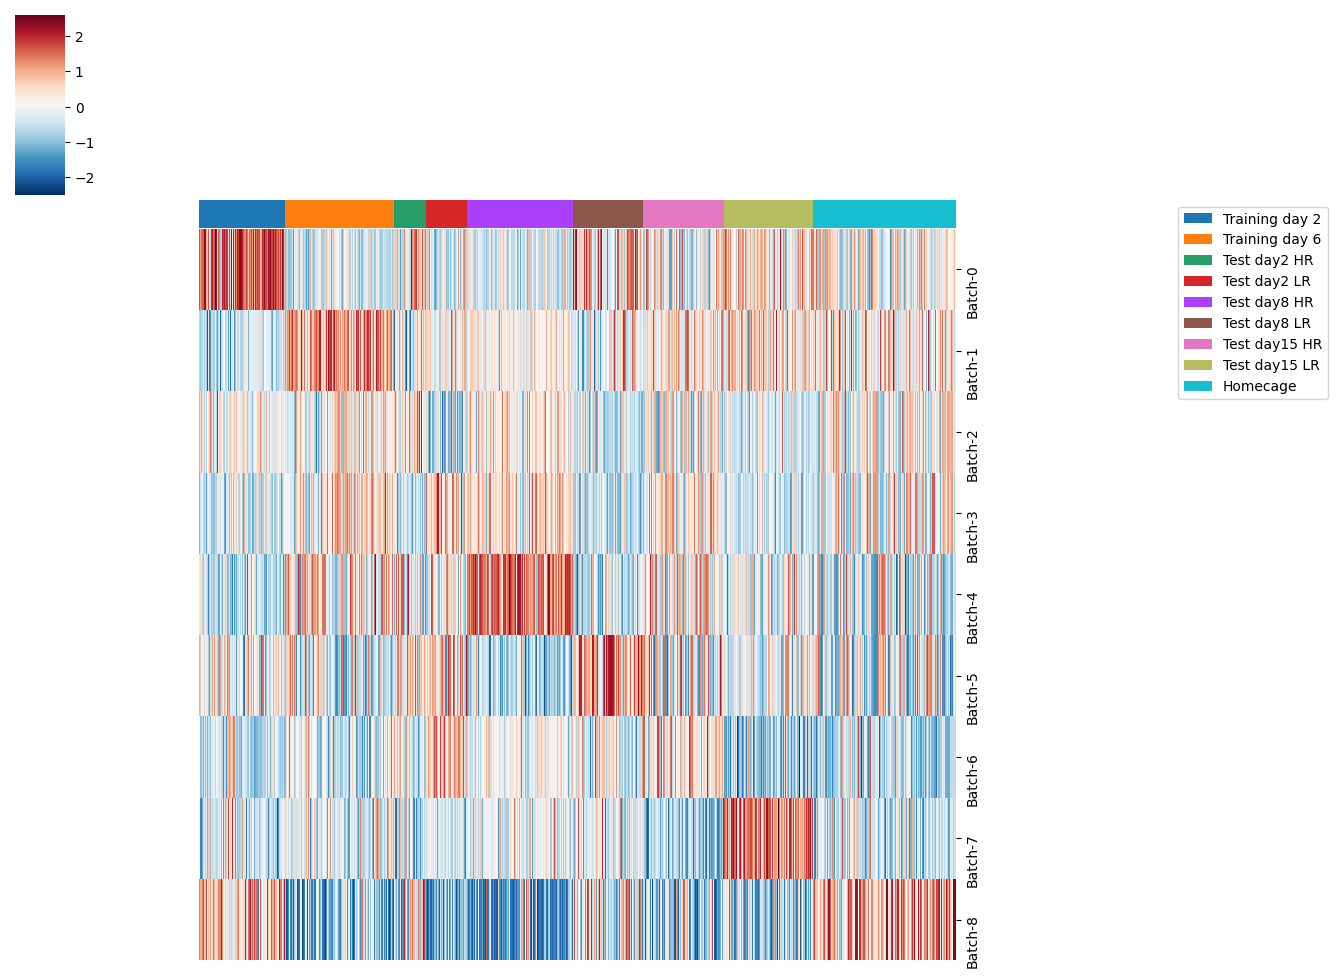

In [164]:
plt.rcParams["figure.figsize"] = (14,20)
g = sns.clustermap(df_stats_arranged, z_score =1, col_colors = col_colors, col_cluster = False,
                  xticklabels = False,row_cluster = False,cmap='RdBu_r')
for label in uniquegenegroups:
    g.ax_col_dendrogram.bar(0,0,color=mypalette[label],label=label)
g.ax_col_dendrogram.legend(loc='best',ncol=1,bbox_to_anchor=(1,0.,0.5,0))
g.savefig('/Users/andrea/Desktop/imagesMSK/illustrator/degsthv2.svg', dpi = 150, bbox_inches = 'tight')

In [ ]:
adata1= adataN[adataN.obs['batch_id'].isin(['0','1','2','4','6'])]
adata2= adataN[adataN.obs['batch_id'].isin(['0','1','3','5','7'])]

In [8]:
#plot expression TFs over samples
TF1 = 'CAMTA1'
TF2 = 'MYT1L'
TF7 = 'TCF4'
TF3 = 'MEF2C'
TF8 = 'CREB1'
TF6 = 'UBE2A'


gene_column1 = adataN.var_names.get_loc(TF1)
gene_column2 = adataN.var_names.get_loc(TF2)
gene_column6 = adataN.var_names.get_loc(TF6)
gene_column7 = adataN.var_names.get_loc(TF7)
gene_column8 = adataN.var_names.get_loc(TF8)

In [9]:
df = p.DataFrame({'CAMTA1': adata1.X[:, gene_column1],'MYT1L': adata1.X[:, gene_column2], 
                  'MEF2C':adata1.X[:, gene_column3],                 
                   'TCF4': adata1.X[:, gene_column7],'CREB1':adata1.X[:, gene_column8]
                 },
                 index = adata1.obs['time'])
                                                                       

In [10]:
df['time'] = df.index

In [11]:
df

CAMTA1     MYT1L     MEF2C      TCF4     CREB1 time
time                                                       
-2    1.414169  0.307855  0.000000  0.777029  0.000000   -2
-2    0.000000  0.000000  3.128910  1.316117  0.000000   -2
-2    2.134813  0.000000  0.000000  0.000000  0.000000   -2
-2    2.020681  0.688449  0.000000  0.688449  0.688449   -2
-2    0.751846  1.097550  0.000000  1.986871  0.155738   -2
...        ...       ...       ...       ...       ...  ...
15    0.821597  1.607057  0.000000  0.821597  0.000000   15
15    1.310479  1.310479  1.985674  1.793715  0.000000   15
15    1.857156  1.208807  0.000000  0.000000  0.000000   15
15    2.102471  2.430979  1.069116  0.000000  0.000000   15
15    1.103318  0.000000  0.000000  2.152329  0.000000   15

[4277 rows x 6 columns]

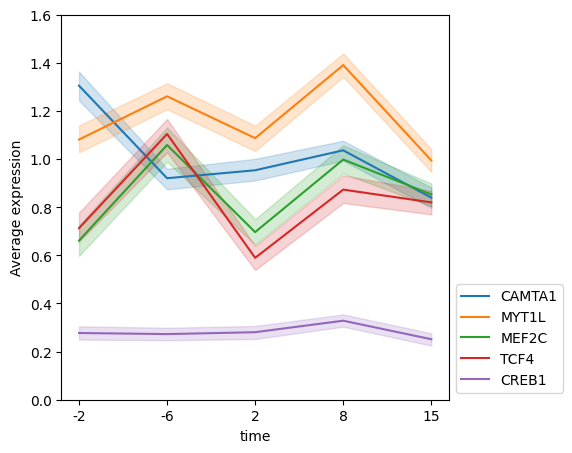

In [15]:
fig = plt.figure(figsize = (5, 5))
h = sns.lineplot(data= p.melt(df,['time']), x='time',y='value', hue='variable')#,palette = sc.pl.palettes.godsnot_102) 
plt.legend(loc='lower left',bbox_to_anchor=(1, 0))
#plt.xticks([0,1, 2, 4,6])
plt.grid(False)
plt.ylabel('Average expression')
h.set(ylim=(0,1.6))#yticks=[0,0.5,1,1.5] xlim=(0,7),xticks=[0,1,2,3,4,5,6,7]

Line plot for TF targets

In [100]:
crebmodule = ['CREB1','PENK', 'NPTX2', 'GADD45B', 'SORCS3', 'ATF3', 'GPNMB', 'INHBA',
       'CDKN1A', 'NPAS4', 'SCG2', 'ARC', 'BDNF','MAPK4', 'STAT3']

In [243]:
#calculate avg targets
genes_of_interest = crebmodule
avg_exp =adata1[:, genes_of_interest].X.mean(axis=1)

avg_exp2 =adata2[:, genes_of_interest].X.mean(axis=1)

In [234]:
dfcreb = p.DataFrame({'CREB1':adata1.X[:, gene_column8],'CrebModule':avg_exp},   
                 index = adata1.obs['time'])

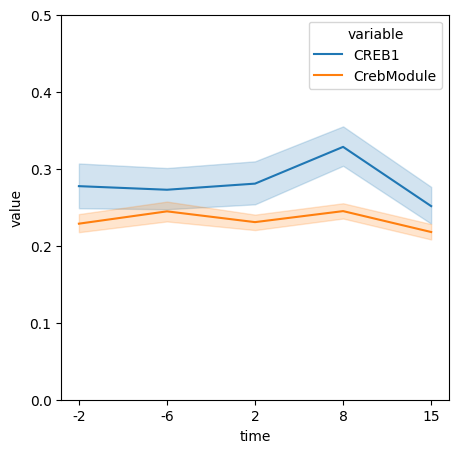

In [242]:
fig = plt.figure(figsize = (5, 5))
h = sns.lineplot(data= p.melt(dfcreb,['time']), x='time',y='value', hue='variable') 
h.set(ylim=(0,0.5))#,xticks=[0,1,2,4,6])

In [101]:
camtamodule=['CCND2','SOX4','MEF2C','TPM1','FOXP1','RTN4','EGR1','BCL11B','DCLK1',
             'CELF2','PHACTR1','YWHAZ','ZEB2','GAS7','NFIX','ATP2B1','MEIS2','NFIB']

In [84]:
genes_of_interest = camtamodule
avg_exp =adata1[:, genes_of_interest].X.mean(axis=1)

In [85]:
dfcam = p.DataFrame({'synapModule':avg_exp},   
                 index = adata1.obs['batch_id'])

In [86]:
dfcam['time'] = dfcam.index

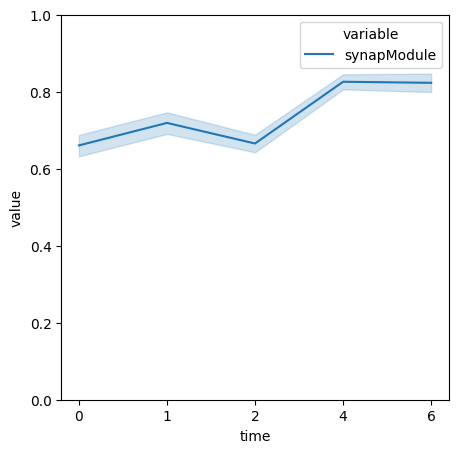

In [87]:
fig = plt.figure(figsize = (5, 5))
h = sns.lineplot(data= p.melt(dfcam,['time']), x='time',y='value', hue='variable') 
h.set(ylim=(0,1))#,xticks=[0,1,2,4,6])

In [152]:
tcfmodule = ['CCND2','SOX1','RTN4','EGR1','PLK2','DCLK1',
             'CELF2','PMEPA1','ETV1','ZEB2','GAS7','NFIX','ATP2B1','MEIS2','NFIB','KLF9'4','TLE4','MEF2C','TPM1','FOXP']

In [253]:
genes_of_interest = tcfmodule
avg_exp =adata1[:, genes_of_interest].X.mean(axis=1)
avg_exp2 =adata2[:, genes_of_interest].X.mean(axis=1)

In [256]:
dftc = p.DataFrame({'TCF4': adata1.X[:, gene_column7],'TCF4Module':avg_exp},   
                 index = adata1.obs['time'])

In [257]:
dftc['time'] = dftc.index

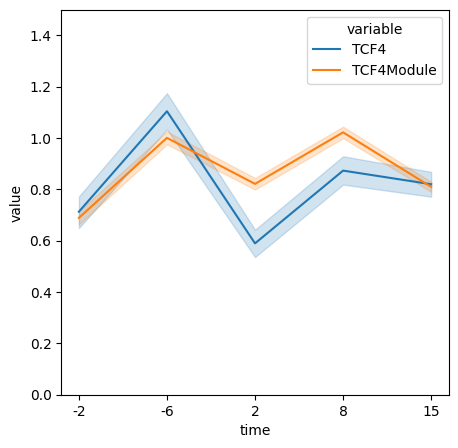

In [258]:
fig = plt.figure(figsize = (5, 5))
h = sns.lineplot(data= p.melt(dftc,['time']), x='time',y='value', hue='variable') 
h.set(ylim=(0,1.5))#,xticks=[0,1,2,4,6])

In [102]:
mytmodule = ['STMN2','DPYSL2','PRKCE','ADGRB3','GRIA1','GRIA2','CACNA1B','KALRN','ABR','CAMTA1','CADM1','GRIN2B','NBEA',
             'ELAVL4','CELF4','ELAVL2','GRM5','DLGAP1','MAPT','NRXN3','NCAM1','GAD1','SORBS2','CDK5R1']

In [261]:
genes_of_interest = mytmodule
avg_exp =adata1[:, genes_of_interest].X.mean(axis=1)
avg_exp2 =adata2[:, genes_of_interest].X.mean(axis=1)

In [262]:
dfmyt = p.DataFrame({'MYT1L': adata1.X[:, gene_column2],'Myt1lModule':avg_exp},   
                 index = adata1.obs['time'])

In [263]:
dfmyt['time'] = dfmyt.index


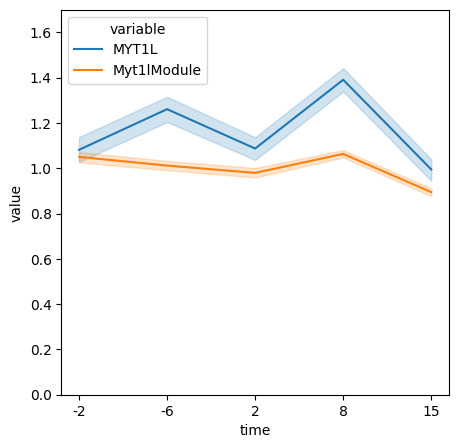

In [264]:
fig = plt.figure(figsize = (5, 5))
h = sns.lineplot(data= p.melt(dfmyt,['time']), x='time',y='value', hue='variable') 
h.set(ylim=(0,1.7))#,xticks=[0,1,2,4,6])

In [169]:
mefmodule = ['RORA','PRKACB','IGFBP5','PRNP','CADM1','NR2F2','GNAS','TIMP2','CAMK2D','GNG2','TCF7L2']

In [268]:
genes_of_interest = mefmodule
avg_exp =adata1[:, genes_of_interest].X.mean(axis=1)
avg_exp2 =adata2[:, genes_of_interest].X.mean(axis=1)

In [269]:
dfmef = p.DataFrame({'MEF2C':adata1.X[:, gene_column3],'Mef2cModule':avg_exp},   
                 index = adata1.obs['time'])

In [270]:
dfmef['time'] = dfmef.index


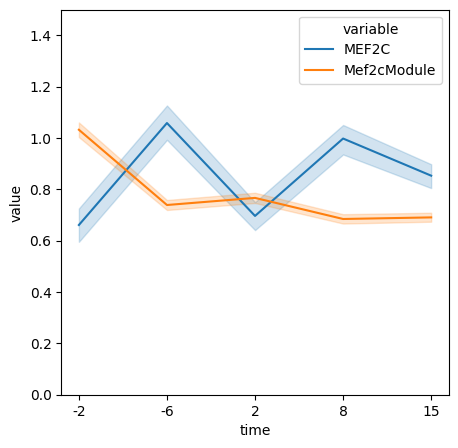

In [271]:
fig = plt.figure(figsize = (5, 5))
h = sns.lineplot(data= p.melt(dfmef,['time']), x='time',y='value', hue='variable') 
h.set(ylim=(0,1.5))#,xticks=[0,1,2,4,6])

Volcano plot

In [88]:
csv_file = p.read_csv('/Users/andrea/Desktop/NeuronsTH/Coefbatch_6_vs_batch7.csv',index_col = 0) 

In [39]:
ml = p.read_csv('/Users/andrea/Desktop/cp/TF.csv')
markeradrenergic = list(ml['tif'])


In [89]:
markeradrenergic = ['SNAP25','KCNA1','CACNA1E','CPLX1','CDH8','GRM3','PENK','MAPK1','DRD2','ERC2','DLGAP2','GABRD','GRIA3','UNC13C',
 'GABBR1','HOMER1','KCND2','SLC32A1','SYT1','HTR1B','GRIN1','CACNB2','CACNB4','DLG2','AKAP9','PDE7B','SCN2B']
#dnedirte morph['CAMK2B','EPHA4','RELN','SIPA1L1','LRRK2','NGEF','LZTS3','CDK5R1']
#synaptic trans['SNAP25','KCNA1','CACNA1E','CPLX1','CDH8','GRM3','PENK','MAPK1','DRD2','ERC2','DLGAP2','GABRD','GRIA3','UNC13C',
 #'GABBR1','HOMER1','KCND2','SLC32A1','SYT1','HTR1B','GRIN1','CACNB2','CACNB4','DLG2','AKAP9','PDE7B','SCN2B']

#splice['SNRPD2','CELF1','CELF2','CELF3','SNRPG','RSRP1','CELF5','SNRPE','SNRPF','SRSF5','SNRPB']
#prune['C1QB','CX3CR1','TREM2','CX3CL1','C1QC','C1QA','AIF1','CLU','SNCA','TREM2','GPM6A','GRM5','NRXN2','SLC6A1']

In [304]:
mar_org=[]


In [90]:
file_clean = csv_file[~csv_file['coef'].isnull()]


In [91]:
log_fold_change = file_clean['coef'].values
log_p_vals = np.log10(file_clean['fdr']).values
log_p_vals[log_p_vals == -np.inf] = np.min(log_p_vals[log_p_vals!= -np.inf])


In [92]:
id_sig = np.where((log_p_vals < -2) & (log_fold_change > 0.2))[0]
#(np.abs(log_fold_change) > 0.2))[0]

In [93]:
#id_g = np.where(file_clean['primerid']=='SKP1A')[0]

In [94]:
id_top = p.DataFrame(file_clean['primerid'])#.head(10))

In [95]:
len(id_top)

16025

In [96]:
id_g = []
#for i in id_top['primerid']:
    #print(i)
    #temp = np.where(file_clean['primerid']== i)[0]
    #print(temp)
    #id_g.append(temp)
    
for i in markeradrenergic:
    temp = np.where(file_clean['primerid']== i)[0]
    id_g.append(temp)

In [273]:
id2=[]

for i in mar_org:
    temp = np.where(file_clean['primerid']== i)[0]
    id2.append(temp)

In [97]:
id_g2=[]
for i in range(0,27):
    for n in id_g[i]:
        id_g2.append(n)


In [96]:
id_g3=[]
for i in range(0,14):
    for n in id2[i]:
        id_g3.append(n)

In [1076]:
id_ga = []
#for i in id_top['primerid']:
    #print(i)
    #temp = np.where(file_clean['primerid']== i)[0]
    #print(temp)
    #id_g.append(temp)
    
for i in markergaba:
    temp = np.where(file_clean['primerid']== i)[0]
    id_ga.append(temp)

NameError: name 'markergaba' is not defined

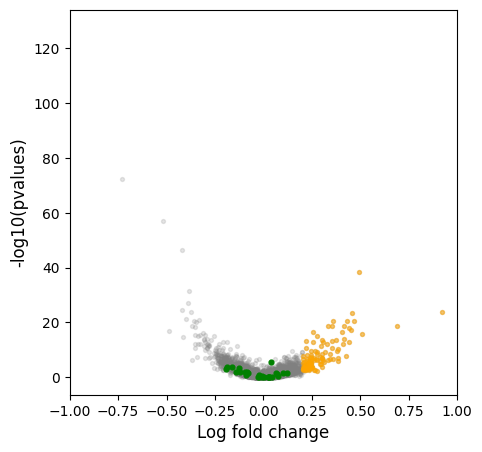

In [99]:
#%matplotlib inline
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1)
ax.scatter(log_fold_change, -log_p_vals, s=8, c = 'grey',alpha=0.2)

ax.scatter(log_fold_change[id_sig], -log_p_vals[id_sig], s=8, c = 'orange',alpha=0.5)


#for i in range(len(id_ga)): 
    #ax.scatter(log_fold_change[id_ga[i]],-log_p_vals[id_ga[i]],s=6,c='blue')
    

for i in id_g2:
    ax.scatter(log_fold_change[i],-log_p_vals[i],s=12,c='green')


#for i in id_g2:
    #ax.annotate(id_top['primerid'].iloc[i],(log_fold_change[i],-log_p_vals[i]),fontsize=6) 
           
#ax.legend(fontsize = 12, markerscale = 5)
ax.grid(False)
ax.set_xlabel('Log fold change',fontsize=12)
ax.set_ylabel('-log10(pvalues)',fontsize =12)
ax.set_xlim(-1,1)
fig.savefig('/Users/andrea/Desktop/imagesMSK/illustrator/volcanoSynapticModule6vs7.svg')

In [ ]:
#plot GO modules as line plot

In [129]:
adata1= adataN[adataN.obs['batch_id'].isin(['0','1','2','4','6'])]

In [141]:
synaptictrans=['SNAP25','KCNA1','CACNA1E','CPLX1','CDH8','GRM3','PENK','MAPK1','DRD2','ERC2','DLGAP2','GABRD','GRIA3','UNC13C',
                 'GABBR1','HOMER1','KCND2','SLC32A1','SYT1','HTR1B','GRIN1','CACNB2','CACNB4','DLG2','AKAP9','PDE7B','SCN2B']
glutsig=['GRM3','GRM5','HOMER1','KCNB1','PLCB1','GRIA3','GRIN1','CDK5R1']
neuroproj =['CAMK2B','EPHA4','GSK3B','NDRG4','CDKL5','TENM3','CAMK1D','LRRK2','SEZ6','CX3CL1','SIPA1L1',
            'RELN','LRRC7','CHN1','NPTN','LRRC4C','MARK2','LZTS3','CDK5R1']
spinemorpho = ['CAMK2B','EPHA4','RELN','SIPA1L1','LRRK2','NGEF','LZTS3','CDK5R1']

histbinding = ['BRD3','KMT2A','ZMYND8','PHIP','TAF1','KMT2E','KMT2D','SETD5','DOT1L','KDM5A','ZMYND8','MTF2','BPTF']

In [142]:
#calculate avg targets
genes_of_interest1 = synaptictrans
genes_of_interest2 = glutsig
genes_of_interest3=neuroproj
genes_of_interest4=spinemorpho
genes_of_interest5=histbinding

avg_exp1 =adata1[:, genes_of_interest1].X.mean(axis=1)# average across genes for each cell 
avg_exp2 =adata1[:, genes_of_interest2].X.mean(axis=1)
avg_exp3 =adata1[:, genes_of_interest3].X.mean(axis=1)
avg_exp4 =adata1[:, genes_of_interest4].X.mean(axis=1)
avg_exp5 =adata1[:, genes_of_interest5].X.mean(axis=1)

In [151]:
dfmod

synaptictrans   glutsig  neuroproj  spinemorpho  histbinding time
batch_id                                                                   
0              0.565292  0.458693   0.438913     0.444483     0.473621    0
0              0.104490  0.047035   0.137265     0.047035     0.796359    0
0              0.502158  0.536538   0.338269     0.178846     0.712767    0
0              0.743370  0.952079   0.591026     0.563689     0.487522    0
0              0.837526  0.548859   0.498147     0.162681     0.458137    0
...                 ...       ...        ...          ...          ...  ...
6              0.633210  0.625759   0.474942     0.366825     0.258942    6
6              0.673150  0.448429   0.575583     0.388024     0.443009    6
6              0.527899  0.383245   0.670338     0.151101     0.421813    6
6              0.636738  0.739638   0.448272     0.267279     0.778619    6
6              0.878458  0.568200   0.645728     0.766801     0.732491    6

[4277 rows x 6 columns]

In [149]:
dfmod = p.DataFrame({'synaptictrans':avg_exp1, 'glutsig':avg_exp2,'neuroproj':avg_exp3,'spinemorpho':avg_exp4,'histbinding':avg_exp5},   
                 index = adata1.obs['batch_id'])
dfmod['time'] = dfmod.index

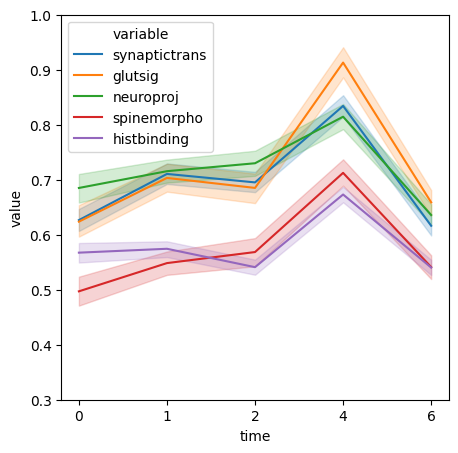

In [152]:
fig = plt.figure(figsize = (5, 5))
h = sns.lineplot(data= p.melt(dfmod,['time']), x='time',y='value', hue='variable') 
h.set(ylim=(0.3,1))#,xticks=[0,1,2,4,6])
plt.savefig('/Users/andrea/Desktop/imagesMSK/illustrator/GOoduleGseaTH_HR.svg')

metagenes for DEGs

In [108]:
deglist = p.read_csv('/Users/andrea/Desktop/cp/DEGtimpoints_CoefTH2.csv')

t2=list(set(list(deglist['Training day 2'])).intersection(set(adataN.var_names)))

t6=list(set(list(deglist['Training day 6'])).intersection(set(adataN.var_names)))

r21=list(set(list(deglist['Test day2 HR'])).intersection(set(adataN.var_names)))

r22=list(set(list(deglist['Test day2 LR'])).intersection(set(adataN.var_names)))

r81=list(set(list(deglist['Test day8 HR'])).intersection(set(adataN.var_names)))

r82=list(set(list(deglist['Test day8 LR'])).intersection(set(adataN.var_names)))

r151=list(set(list(deglist['Test day15 HR'])).intersection(set(adataN.var_names)))

r152=list(set(list(deglist['Test day15 LR'])).intersection(set(adataN.var_names)))

cc=list(set(list(deglist['Homecage'])).intersection(set(adataN.var_names)))

In [109]:
id_t2 = [adataN.var_names.get_loc(j) for j in t2]
id_t6 = [adataN.var_names.get_loc(j) for j in t6]
id_r21 = [adataN.var_names.get_loc(j) for j in r21]
id_r22 = [adataN.var_names.get_loc(j) for j in r22]
id_r81 = [adataN.var_names.get_loc(j) for j in r81]
id_r82 = [adataN.var_names.get_loc(j) for j in r82]
id_r151 = [adataN.var_names.get_loc(j) for j in r151]
id_r152 = [adataN.var_names.get_loc(j) for j in r152]
id_cc = [adataN.var_names.get_loc(j) for j in cc]

In [394]:
mergedeg= id_t2+id_t6+id_r21+id_r22+id_r81+id_r82+id_r151+id_r152+id_cc

In [110]:
adataN.obs['t2']=np.sum(adataN.X[:,id_t2],axis=1)
adataN.obs['t6']=np.sum(adataN.X[:,id_t6],axis=1)
adataN.obs['r21']=np.sum(adataN.X[:,id_r21],axis=1)
adataN.obs['r22']=np.sum(adataN.X[:,id_r22],axis=1)
adataN.obs['r81']=np.sum(adataN.X[:,id_r81],axis=1)
adataN.obs['r82']=np.sum(adataN.X[:,id_r82],axis=1)
adataN.obs['r151']=np.sum(adataN.X[:,id_r151],axis=1)
adataN.obs['r152']=np.sum(adataN.X[:,id_r152],axis=1)
adataN.obs['cc']=np.sum(adataN.X[:,id_cc],axis=1)

In [404]:
adatameta2 = sc.AnnData(adataN.obs[['t2','t6','r21','r22','r81','r82','r151','r152','cc']].values,
            obs=adataN.obs, var=p.DataFrame(index= ['st2','st6','sr21','sr22','sr81','sr82','sr151','sr152','ccc']))

In [405]:
adatameta2

AnnData object with n_obs × n_vars = 5535 × 9
    obs: 'barcode_sequence', 'hash_id', 'htoByMax', 'mouse', 'unmapped', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mito_frac', 'pheno_leiden', 'Neurons_markers', 'Microglia _markers', 'Astrocytes_markers', 'Oligodendrocytes_markers', 'Fibroblast-like cells_markers', 'Vascular epithelial cells_markers', 'Vascular endothelial Cells_markers', 'Pericytes_markers', 'Vascular smooth muscle cells_markers', 'Neuroblast-like neurons_markers', 'Ependymal cells_markers', 'Cell Type', 'anterior', 'posterior', 'glu', 'gad2', 'Neurotranstmitter', 'remoteChen', 'earlyRao', 'lateRao', 't2', 't6', 'r21', 'r22', 'r81', 'r82', 'r151', 'r152', 'cc'

In [406]:
mergelistdeg = ['st2','st6','sr21','sr22','sr81','sr82','sr151','sr152','ccc']

/opt/anaconda3/envs/sc_analysis/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


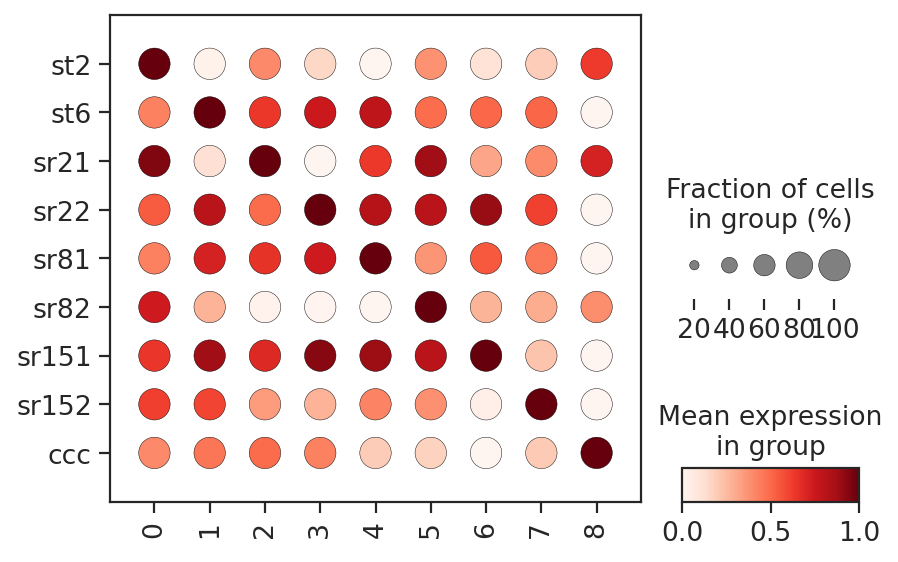

In [407]:
with plt.rc_context():
    sc.pl.dotplot(adatameta2, mergelistdeg, groupby = 'batch_id', log=True, 
                    standard_scale = 'var',show=False,figsize=(6,4),swap_axes=True)#vmin=0.5
    #plt.savefig('/Users/raja/Desktop/imagesMSK/illustrator/MetaGenesDotplot.svg',bbox_inches="tight")

In [113]:
palantir_obj.obs['t2'] = adataN.obs['t2']
palantir_obj.obs['t6']=adataN.obs['t6']
palantir_obj.obs['r21'] =adataN.obs['r21']
palantir_obj.obs['r22']=adataN.obs['r22']
palantir_obj.obs['r81'] = adataN.obs['r81']
palantir_obj.obs['r82'] = adataN.obs['r82']
palantir_obj.obs['r151'] = adataN.obs['r151']
palantir_obj.obs['r152'] = adataN.obs['r152']
palantir_obj.obs['cc'] = adataN.obs['cc']

## MAST by timepoint

In [73]:
import rpy2
import anndata2ri
import os
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Resources'
os.environ['R_USER'] = '/Library/Frameworks/R.framework/Resources'

# anndata2ri interconverts AnnData and Single Cell Experiment objects
anndata2ri.activate()
#%load_ext rpy2.ipython
%reload_ext rpy2.ipython

During startup - Warning messages:
1: package "methods" in options("defaultPackages") was not found 
2: package ‘utils’ in options("defaultPackages") was not found 
3: package ‘grDevices’ in options("defaultPackages") was not found 
4: package ‘graphics’ in options("defaultPackages") was not found 
5: package ‘stats’ in options("defaultPackages") was not found 
6: package ‘methods’ in options("defaultPackages") was not found 
R[write to console]: Error in dyn.load(file, DLLpath = DLLpath, ...) : 
  unable to load shared object '/Library/Frameworks/R.framework/Versions/4.1/Resources/library/methods/libs/methods.so':
  dlopen(/Library/Frameworks/R.framework/Versions/4.1/Resources/library/methods/libs/methods.so, 0x0006): tried: '/Library/Frameworks/R.framework/Versions/4.1/Resources/library/methods/libs/methods.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64')), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Versions/4.1/Resources/l

RRuntimeError: Error in dyn.load(file, DLLpath = DLLpath, ...) : 
  unable to load shared object '/Library/Frameworks/R.framework/Versions/4.1/Resources/library/methods/libs/methods.so':
  dlopen(/Library/Frameworks/R.framework/Versions/4.1/Resources/library/methods/libs/methods.so, 0x0006): tried: '/Library/Frameworks/R.framework/Versions/4.1/Resources/library/methods/libs/methods.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64')), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Versions/4.1/Resources/library/methods/libs/methods.so' (no such file), '/Library/Frameworks/R.framework/Versions/4.1/Resources/library/methods/libs/methods.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64'))


In [701]:
# Since we want to compute differentially expressed genes comparing a cluster to rest of the data,
# we supply the cluster labels as part of sce_v2

sce_v4 = ad.AnnData(X = datactive.X, 
                 obs = p.DataFrame({'batch_label': datactive.obs['batch_id'].astype('int')}, 
                                    index = datactive.obs.index),
                 var = p.DataFrame(index = datactive.var.index))

In [702]:
%%capture
%R library(scuttle)
%R library(scran)
%R library(MAST)
%R library(data.table)

In [703]:
# -i implies we are supplying sce_v2 as an input to R
%R -i sce_v4

%R counts(sce_v4) <- assay(sce_v4, "X"); 
print("Finished Setup")

Finished Setup


In [703]:
# For illustration, we will show how to run MAST to compare batch 0 with batch 1:
# identify cells belonging to batch 0:
%R id_cells_C2 <- which(colData(sce_v4)$batch_label ==0)
# identify cells belonging to batch 1:
%R id_cells_C3 <- which(colData(sce_v4)$batch_label == 1)

# Create two dataframes: one with cells from C0 and one with rest of the cells
%R df1 <- t(data.frame(counts(sce_v4)[, id_cells_C2])) # transpose because in sce genes are rows
%R df2 <- t(data.frame(counts(sce_v4)[, id_cells_C3])) # transpose because in sce genes are rows

# We will use the function provided (see README for more details):
%R source("/Users/andrea/Desktop/downloadsRaja/run_MAST.r")

# Syntax: pairwise_de(dataframe1, dataframe2, 'output_filename', 'output_folder')
%R pairwise_de(df1, df2, paste0('batch_', toString(0), '_vs_batch1'), '/Users/andrea/Desktop/NeuronsTH/MastTPfos/')

Assuming data assay in position 1, with name et is log-transformed.

Done!
Combining coefficients and standard errors
Calculating log-fold changes
Calculating likelihood ratio tests
Refitting on reduced model...

Done!


In [698]:
import pandas as p

In [699]:
import anndata as ad

In [621]:
# Since we want to compute differentially expressed genes comparing a cluster to rest of the data,
# we supply the cluster labels as part of sce_v2

sce_v2 = ad.AnnData(X = adataN.X, 
                 obs = p.DataFrame({'pheno_label': adataN.obs['pheno_leiden'].astype('int')}, 
                                    index = adataN.obs.index),
                 var = p.DataFrame(index = adataN.var.index))

In [622]:
%%capture
%R library(scuttle)
%R library(scran)
%R library(MAST)
%R library(data.table)

In [623]:
# -i implies we are supplying sce_v2 as an input to R
%R -i sce_v2

In [624]:
# set up a single cell experiment object in R, using the data stored in 'X' in sce anndata object
%R counts(sce_v2) <- assay(sce_v2, "X"); 
print("Finished Setup")

Finished Setup


In [626]:
%%R 
# if sce_v2 has not been input yet, you need to start with %%R -v sce_v2
for (j in unique(colData(sce_v2)$pheno_label)) {
    print(paste0('Analysing Cluster', toString(j)))
    # identify cells belonging a specific cluster
    id_cells <- which(colData(sce_v2)$pheno_label == j)
    # identify cells belonging to rest of the clusters
    id_cells_rest <- which(colData(sce_v2)$pheno_label != j)
    # Create two dataframes: 
    df1 <- t(data.frame(counts(sce_v2)[, id_cells])) # transpose because in sce genes are rows
    df2 <- t(data.frame(counts(sce_v2)[, id_cells_rest])) # transpose because in sce genes are rows
    # We will use the function provided (see README for more details):
    source("/Users/andrea/Desktop/downloadsRaja/run_MAST.r")

    file_name_temp = paste0('Cluster_', toString(j), '_vs_rest')
    # Syntax: pairwise_de(dataframe1, dataframe2, 'output_filename', 'output_folder')
    pairwise_de(df1, df2, file_name_temp, '/Users/andrea/Desktop/NeuronsTH/Mastclusters/')
}

[1] "Analysing Cluster1"
[1] "Analysing Cluster7"
[1] "Analysing Cluster3"
[1] "Analysing Cluster2"
[1] "Analysing Cluster0"
[1] "Analysing Cluster6"
[1] "Analysing Cluster4"
[1] "Analysing Cluster5"


Assuming data assay in position 1, with name et is log-transformed.

Done!
Combining coefficients and standard errors
Calculating log-fold changes
Calculating likelihood ratio tests
Refitting on reduced model...

Done!
Assuming data assay in position 1, with name et is log-transformed.

Done!
Combining coefficients and standard errors
Calculating log-fold changes
Calculating likelihood ratio tests
Refitting on reduced model...

Done!
Assuming data assay in position 1, with name et is log-transformed.

Done!
Combining coefficients and standard errors
Calculating log-fold changes
Calculating likelihood ratio tests
Refitting on reduced model...

Done!
Assuming data assay in position 1, with name et is log-transformed.

Done!
Combining coefficients and standard errors
Calculating log-fold changes
Calculating likelihood ratio tests
Refitting on reduced model...

Done!
Assuming data assay in position 1, with name et is log-transformed.

Done!
Combining coefficients and standard errors
Calcul

R[write to console]: 
R[write to console]:  Completed [====================>-----------------------]  48% with 0 failures
R[write to console]: 
R[write to console]:  Completed [====================>-----------------------]  49% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=====================>----------------------]  49% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=====================>----------------------]  50% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=====================>----------------------]  51% with 0 failures
R[write to console]: 
R[write to console]:  Completed [======================>---------------------]  51% with 0 failures
R[write to console]: 
R[write to console]:  Completed [======================>---------------------]  52% with 0 failures
R[write to console]: 
R[write to console]:  Completed [======================>---------------------]  53% with 0 failures
R[write to console]: 
R[

R[write to console]:  Completed [=========================================>--]  96% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=========================================>--]  97% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==========================================>-]  97% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==========================================>-]  98% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==========================================>-]  99% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===========================================>]  99% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===========================================>] 100% with 0 failures
R[write to console]: 
R[write to console]:  Completed [============================================] 100% with 0 failures
                                              

R[write to console]: 
R[write to console]:  Completed [=================>--------------------------]  41% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=================>--------------------------]  42% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==================>-------------------------]  42% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==================>-------------------------]  43% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==================>-------------------------]  44% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===================>------------------------]  44% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===================>------------------------]  45% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===================>------------------------]  46% with 0 failures
R[write to console]: 
R[

R[write to console]:  Completed [======================================>-----]  89% with 0 failures
R[write to console]: 
R[write to console]:  Completed [======================================>-----]  90% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=======================================>----]  90% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=======================================>----]  91% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=======================================>----]  92% with 0 failures
R[write to console]: 
R[write to console]:  Completed [========================================>---]  92% with 0 failures
R[write to console]: 
R[write to console]:  Completed [========================================>---]  93% with 0 failures
R[write to console]: 
R[write to console]:  Completed [========================================>---]  94% with 0 failures
R[write to console]: 
R[write to console]:  Co

[1] "Analysing Cluster7"


R[write to console]: Assuming data assay in position 1, with name et is log-transformed.

R[write to console]: 
R[write to console]:  Completed [--------------------------------------------]   0% with 0 failures
R[write to console]: 
R[write to console]:  Completed [--------------------------------------------]   1% with 0 failures
R[write to console]: 
R[write to console]:  Completed [>-------------------------------------------]   1% with 0 failures
R[write to console]: 
R[write to console]:  Completed [>-------------------------------------------]   2% with 0 failures
R[write to console]: 
R[write to console]:  Completed [>-------------------------------------------]   3% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=>------------------------------------------]   3% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=>------------------------------------------]   4% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=

R[write to console]: 
R[write to console]:  Completed [====================>-----------------------]  48% with 0 failures
R[write to console]: 
R[write to console]:  Completed [====================>-----------------------]  49% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=====================>----------------------]  49% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=====================>----------------------]  50% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=====================>----------------------]  51% with 0 failures
R[write to console]: 
R[write to console]:  Completed [======================>---------------------]  51% with 0 failures
R[write to console]: 
R[write to console]:  Completed [======================>---------------------]  52% with 0 failures
R[write to console]: 
R[write to console]:  Completed [======================>---------------------]  53% with 0 failures
R[write to console]: 
R[

R[write to console]:  Completed [=========================================>--]  96% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=========================================>--]  97% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==========================================>-]  97% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==========================================>-]  98% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==========================================>-]  99% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===========================================>]  99% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===========================================>] 100% with 0 failures
R[write to console]: 
R[write to console]:  Completed [============================================] 100% with 0 failures
                                              

R[write to console]: 
R[write to console]:  Completed [=================>--------------------------]  41% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=================>--------------------------]  42% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==================>-------------------------]  42% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==================>-------------------------]  43% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==================>-------------------------]  44% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===================>------------------------]  44% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===================>------------------------]  45% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===================>------------------------]  46% with 0 failures
R[write to console]: 
R[

R[write to console]:  Completed [======================================>-----]  89% with 0 failures
R[write to console]: 
R[write to console]:  Completed [======================================>-----]  90% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=======================================>----]  90% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=======================================>----]  91% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=======================================>----]  92% with 0 failures
R[write to console]: 
R[write to console]:  Completed [========================================>---]  92% with 0 failures
R[write to console]: 
R[write to console]:  Completed [========================================>---]  93% with 0 failures
R[write to console]: 
R[write to console]:  Completed [========================================>---]  94% with 0 failures
R[write to console]: 
R[write to console]:  Co

[1] "Analysing Cluster8"


R[write to console]: Assuming data assay in position 1, with name et is log-transformed.

R[write to console]: 
R[write to console]:  Completed [--------------------------------------------]   0% with 0 failures
R[write to console]: 
R[write to console]:  Completed [--------------------------------------------]   1% with 0 failures
R[write to console]: 
R[write to console]:  Completed [>-------------------------------------------]   1% with 0 failures
R[write to console]: 
R[write to console]:  Completed [>-------------------------------------------]   2% with 0 failures
R[write to console]: 
R[write to console]:  Completed [>-------------------------------------------]   3% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=>------------------------------------------]   3% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=>------------------------------------------]   4% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=

R[write to console]: 
R[write to console]:  Completed [====================>-----------------------]  48% with 0 failures
R[write to console]: 
R[write to console]:  Completed [====================>-----------------------]  49% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=====================>----------------------]  49% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=====================>----------------------]  50% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=====================>----------------------]  51% with 0 failures
R[write to console]: 
R[write to console]:  Completed [======================>---------------------]  51% with 0 failures
R[write to console]: 
R[write to console]:  Completed [======================>---------------------]  52% with 0 failures
R[write to console]: 
R[write to console]:  Completed [======================>---------------------]  53% with 0 failures
R[write to console]: 
R[

R[write to console]:  Completed [=========================================>--]  96% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=========================================>--]  97% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==========================================>-]  97% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==========================================>-]  98% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==========================================>-]  99% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===========================================>]  99% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===========================================>] 100% with 0 failures
R[write to console]: 
R[write to console]:  Completed [============================================] 100% with 0 failures
                                              

R[write to console]: 
R[write to console]:  Completed [=================>--------------------------]  41% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=================>--------------------------]  42% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==================>-------------------------]  42% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==================>-------------------------]  43% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==================>-------------------------]  44% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===================>------------------------]  44% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===================>------------------------]  45% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===================>------------------------]  46% with 0 failures
R[write to console]: 
R[

R[write to console]:  Completed [======================================>-----]  89% with 0 failures
R[write to console]: 
R[write to console]:  Completed [======================================>-----]  90% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=======================================>----]  90% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=======================================>----]  91% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=======================================>----]  92% with 0 failures
R[write to console]: 
R[write to console]:  Completed [========================================>---]  92% with 0 failures
R[write to console]: 
R[write to console]:  Completed [========================================>---]  93% with 0 failures
R[write to console]: 
R[write to console]:  Completed [========================================>---]  94% with 0 failures
R[write to console]: 
R[write to console]:  Co

In [627]:
def check_NA_MAST(diff_expr_file, adata, groupby, group1, group2 = 'rest'):
    # load the differential expression analysis result
    mast_result = p.read_csv(diff_expr_file, index_col = 0)
    
    # identify which cells belong to group 1
    cells1 = np.where(adata.obs[groupby] == group1)[0]
    
    # identify which cells belong to group 2
    if group2 == 'rest':
        cells2 = np.where(adata.obs[groupby] != group1)[0]
    else:
        cells2 = np.where(adata.obs[groupby] == group2)[0]
        
    
    # identify the genes with NA in the differential expression result
    genes_with_NA = mast_result['primerid'][np.isnan(mast_result['coef'])].values
    
    # identify the location of the genes with NA
    genes_with_NA_index = [adata.var_names.get_loc(j) for j in genes_with_NA]
    
    # compute median expression of the genes in each of the groups
    expr_1 = np.median(adata.X[cells1, :][:, genes_with_NA_index], axis = 0)
    
    expr_2 = np.median(adata.X[cells2, :][:, genes_with_NA_index], axis = 0)

    # compute the sign of the difference in median expression
    df_temp = p.DataFrame({'expr_1': expr_1, 'expr_2': expr_2, 'diff': expr_1 - expr_2}, index = genes_with_NA)
    df_temp['sign'] = [np.sign(j) for j in df_temp['diff']]

    # assign the sign back into mast results
    for gene_name in df_temp.index:
        id_loc = mast_result.index[mast_result['primerid'] == gene_name]
        mast_result.loc[id_loc, 'coef'] = df_temp.loc[gene_name]['sign']
        
    return mast_result, df_temp

In [730]:
diff_file = '/Users/andrea/Desktop/NeuronsTH/MastTPfos/batch_4_vs_batch5.csv'
mast_up, _ = check_NA_MAST(diff_file, datactive, 'batch_id', '4', group2 = 'rest')# pheno_leiden 'fos_positive' batch_id', '4', group2 = 'rest')

In [717]:
# check that there are no NaN in log fold change:
np.sum(np.isnan(mast_up['coef']))

0

In [718]:
df_gseac = mast_up[['primerid', 'fdr', 'coef']]
df_gseac

primerid           fdr      coef
1       HBB-BS  3.937397e-23 -1.041465
2       HBA-A2  1.515135e-14 -0.384263
3       HBB-BT  5.911374e-12 -0.307986
4      PRKAR1A  2.366060e-11 -0.528741
5        NEDD4  2.956560e-11 -0.442480
...        ...           ...       ...
16021   ZSWIM3  1.000000e+00  0.004084
16022   ZSWIM4  1.000000e+00 -0.001153
16023     ZW10  1.000000e+00  0.010919
16024     ZXDC  1.000000e+00  0.010964
16025     ZZZ3  1.000000e+00 -0.019194

[16025 rows x 3 columns]

In [719]:
non_zero_min = np.min(df_gseac['fdr'][df_gseac['fdr'] != 0])
df_gseac['fdr_updated'] = [j if j != 0 else non_zero_min/2 for j in df_gseac['fdr']]

#compute -log10
df_gseac['-log10(fdr)'] = [-1*np.log10(j) for j in df_gseac['fdr_updated']]

#Now we can multiply by the sign of coef (or log fold change). 
#Note: This is where the removal of NaN as discussed above matters.
df_gseac['score'] = df_gseac['-log10(fdr)'] * np.sign(df_gseac['coef'])

df_gsea_sort = df_gseac.sort_values(by = 'coef', ascending = False)

## Save the sorted results somewhere to run fGSEA
##Rename the output file!
df_gsea_sort[['primerid','fdr','coef','score']].to_csv('/Users/andrea/Desktop/NeuronsTH/MastTPfos/coefbatch_6_vs7.csv')

/var/folders/_n/3lfp5q711_10b97h8w6jcl4h0000gn/T/ipykernel_91669/2191127531.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gseac['fdr_updated'] = [j if j != 0 else non_zero_min/2 for j in df_gseac['fdr']]
/var/folders/_n/3lfp5q711_10b97h8w6jcl4h0000gn/T/ipykernel_91669/2191127531.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gseac['-log10(fdr)'] = [-1*np.log10(j) for j in df_gseac['fdr_updated']]


## Enrichr

In [234]:
import gseapy

In [235]:
gseapy.get_library_name(organism = 'Mouse')

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_2024',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
 'Descartes_Cell_Types_and_Tissue_2021',
 'Diabetes_Perturbatio

In [731]:
gseaE = mast_up[['primerid', 'fdr', 'coef']]
gseaE

primerid       fdr      coef
1          TTR  0.000054  0.529917
2        PDE7B  0.009271  0.237535
3        C1QL3  0.013641 -0.302970
4        ARRB2  0.016193 -0.210253
5        PEG10  0.016193 -0.389073
...        ...       ...       ...
16021     ZXDB  1.000000 -0.013889
16022   ZYG11B  1.000000  0.045261
16023      ZYX  1.000000 -0.034956
16024    ZZEF1  1.000000 -0.008970
16025     ZZZ3  1.000000 -0.011369

[16025 rows x 3 columns]

In [732]:
non_zero_min = np.min(gseaE['fdr'][gseaE['fdr'] != 0])
gseaE['fdr_updated'] = [j if j != 0 else non_zero_min/2 for j in gseaE['fdr']]

gseaE['-log10(fdr)'] = [-1*np.log10(j) for j in gseaE['fdr_updated']]

gseaE['score'] = gseaE['-log10(fdr)'] * np.sign(gseaE['coef'])

/var/folders/_n/3lfp5q711_10b97h8w6jcl4h0000gn/T/ipykernel_91669/1836414598.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gseaE['fdr_updated'] = [j if j != 0 else non_zero_min/2 for j in gseaE['fdr']]
/var/folders/_n/3lfp5q711_10b97h8w6jcl4h0000gn/T/ipykernel_91669/1836414598.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gseaE['-log10(fdr)'] = [-1*np.log10(j) for j in gseaE['fdr_updated']]


In [733]:
ordered_genelist = list(gseaE.sort_values(by = 'score', ascending = False)['primerid'].values)

In [240]:
ordered_genel = p.read_csv('/Users/andrea/Desktop/NeuronsTH/Coefbatch_4_vs_batch5.csv')
ordered_genelist = ordered_genel['primerid']

In [241]:
gseapy_res = gseapy.enrichr(gene_list=ordered_genelist[:400],
                            organism='Mouse',
                            gene_sets='GO_Biological_Process_2023', #'TRRUST_Transcription_Factors_2019',#GO_Biological_Process_2021',#Enrichr_Submissions_TF-Gene_Coocurrence',
                            #description='GO',
                            cutoff = 0.5)


In [242]:
gseapy_res.results.head(30)

Gene_set  \
0   GO_Biological_Process_2023   
1   GO_Biological_Process_2023   
2   GO_Biological_Process_2023   
3   GO_Biological_Process_2023   
4   GO_Biological_Process_2023   
5   GO_Biological_Process_2023   
6   GO_Biological_Process_2023   
7   GO_Biological_Process_2023   
8   GO_Biological_Process_2023   
9   GO_Biological_Process_2023   
10  GO_Biological_Process_2023   
11  GO_Biological_Process_2023   
12  GO_Biological_Process_2023   
13  GO_Biological_Process_2023   
14  GO_Biological_Process_2023   
15  GO_Biological_Process_2023   
16  GO_Biological_Process_2023   
17  GO_Biological_Process_2023   
18  GO_Biological_Process_2023   
19  GO_Biological_Process_2023   
20  GO_Biological_Process_2023   
21  GO_Biological_Process_2023   
22  GO_Biological_Process_2023   
23  GO_Biological_Process_2023   
24  GO_Biological_Process_2023   
25  GO_Biological_Process_2023   
26  GO_Biological_Process_2023   
27  GO_Biological_Process_2023   
28  GO_Biological_Process_2023   
29  GO_Biological_Process_2023   

                                                 Term Overlap       P-value  \
0         Chemical Synaptic Transmission (GO:0007268)  30/273  3.826633e-14   
1   Modulation Of Chemical Synaptic Transmission (...  21/123  4.757427e-14   
2   Anterograde Trans-Synaptic Signaling (GO:0098916)  22/199  9.282542e-11   
3   Regulation Of Synaptic Transmission, Glutamate...   12/55  7.020331e-10   
4   Regulation Of Neuron Projection Development (G...  19/174  2.222690e-09   
5   Positive Regulation Of Synaptic Transmission (...   12/77  3.956736e-08   
6   Regulation Of Dendritic Spine Morphogenesis (G...    8/30  9.503873e-08   
7   Glutamate Receptor Signaling Pathway (GO:0007215)    8/35  3.501510e-07   
8   Regulation Of Postsynapse Organization (GO:009...    7/25  4.277805e-07   
9             Calcium-Mediated Signaling (GO:0019722)   11/85  1.011008e-06   
10          Peptidyl-Serine Modification (GO:0018209)  15/166  1.294685e-06   
11  Regulation Of Voltage-Gated Calcium Channel Ac...    7/29  1.296281e-06   
12            Regulation Of Axonogenesis (GO:0050770)    8/42  1.553736e-06   
13                                Memory (GO:0007613)    9/58  2.095735e-06   
14                    Cardiac Conduction (GO:0061337)    8/46  3.203160e-06   
15        Cellular Response To Metal Ion (GO:0071248)  13/135  3.254717e-06   
16       Peptidyl-Serine Phosphorylation (GO:0018105)  14/158  3.678813e-06   
17  Positive Regulation Of Cell Projection Organiz...  12/118  4.398108e-06   
18                     Brain Development (GO:0007420)  14/169  8.052403e-06   
19  Regulation Of Anatomical Structure Morphogenes...  12/127  9.432970e-06   
20  Regulation Of Cation Channel Activity (GO:2001...    8/56  1.464746e-05   
21           Synaptic Vesicle Exocytosis (GO:0016079)    7/41  1.518460e-05   
22  Regulation Of Neurotransmitter Receptor Activi...    7/42  1.791079e-05   
23  Positive Regulation Of Calcium Ion Transmembra...    7/42  1.791079e-05   
24     Ephrin Receptor Signaling Pathway (GO:0048013)    7/43  2.102873e-05   
25                  Associative Learning (GO:0008306)    5/18  2.157030e-05   
26     Excitatory Postsynaptic Potential (GO:0060079)    5/18  2.157030e-05   
27  Cellular Response To Oxygen-Containing Compoun...  22/406  2.564909e-05   
28               Protein Phosphorylation (GO:0006468)  25/500  2.809664e-05   
29  Modulation Of Excitatory Postsynaptic Potentia...    6/31  2.971209e-05   

    Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0       4.947724e-11            0                     0    6.458792   
1       4.947724e-11            0                     0   10.591805   
2       6.435895e-08            0                     0    6.386662   
3       3.650572e-07            0                     0   14.066411   
4       9.246389e-07            0                     0    6.256117   
5       1.371668e-05            0                     0    9.295004   
6       2.824008e-05

intersect TFs mouse w DEGs

In [127]:
#genies = p.read_csv('/Users/andrea/Desktop/cp/DEGtimpoints_CoefTH2.csv')
genes = genies['Training day 6'].tolist()

In [61]:
tfactors = open('/Users/andrea/Desktop/cp/TFs_AnimalTFDB.txt', 'r')
tfactor = tfactors.read().split('\n')

In [77]:
#take intersection of tf that exist in adata
tf_modified = list(set(tfactor).intersection(set(genes)))
tf_modified

['SUB1', 'JUND', 'ID2']

In [91]:
#list from Trust
trust_f = p.read_csv('/Users/andrea/Downloads/trrust_rawdata.mouse.tsv', sep='\t')

In [95]:
tf_up = []
for i in trust_f['Aatf'].values:
    tf_up = np.append(tf_up,i.upper())

trust_f['Aatf']=tf_up

In [128]:
tf_modified2 = list(set(trust_f['Aatf']).intersection(set(genes)))

In [129]:
tf_modified2

['EGR1',
 'MEF2C',
 'BCL11B',
 'ZEB2',
 'YBX1',
 'FOXP1',
 'NFIB',
 'SYT1',
 'ETV1',
 'NFIX',
 'SSB',
 'KLF9',
 'SOX4',
 'TCF4',
 'MEIS2']

# Subset middle island for pseudotime analysis, as it has the most shifts and looks more continuous

/Users/andrea/anaconda3/envs/sc_analysis/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


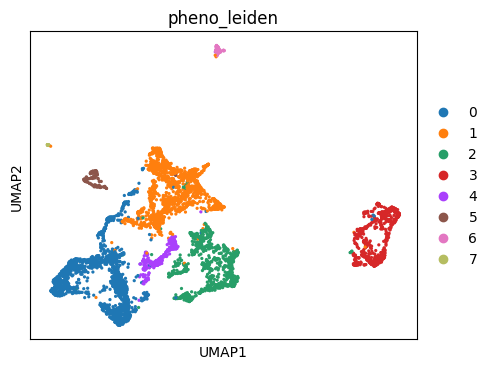

In [75]:
with plt.rc_context({'figure.figsize': (5,4)}): 
    sc.pl.umap(adataN, color = ['pheno_leiden'])

In [76]:
keepneurons = [0,1,4,2,5]
keepneuro = np.isin(adataN.obs['pheno_leiden'], keepneurons)

nonzero_neurons = np.sum(adataN.X[keepneuro, :], axis = 0) != 0

In [77]:
adataN2 = sc.AnnData(adataN.X[keepneuro, :][:, nonzero_neurons].copy(), 
                            obs = adataN.obs.loc[keepneuro, :], 
                            var = adataN.var.loc[nonzero_neurons, :])

adataN2.layers['norm_counts'] = adataN.layers['norm_counts'][keepneuro, :][:, nonzero_neurons].copy()
adataN2.layers['raw_data'] = adataN.layers['raw_data'][keepneuro, :][:, nonzero_neurons].copy()

In [78]:
adataN2

AnnData object with n_obs × n_vars = 4664 × 15995
    obs: 'barcode_sequence', 'hash_id', 'htoByMax', 'mouse', 'unmapped', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mito_frac', 'pheno_leiden', 'Neurons_markers', 'Microglia _markers', 'Astrocytes_markers', 'Oligodendrocytes_markers', 'Fibroblast-like cells_markers', 'Vascular epithelial cells_markers', 'Vascular endothelial Cells_markers', 'Pericytes_markers', 'Vascular smooth muscle cells_markers', 'Neuroblast-like neurons_markers', 'Ependymal cells_markers', 'Cell Type', 'anterior', 'posterior', 'glu', 'gad2', 'Neurotranstmitter', 'remoteChen', 'earlyRao', 'lateRao', 't2', 't6', 'r21', 'r22', 'r81', 'r82', 'r151', 'r152', 'cc'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_c

In [696]:
adataN2 = sc.read('/Users/andrea/Desktop/datasInUse/adataN2TH.h5ad')

## HVG, PCA, UMAP, Clustering

In [304]:
sc.pp.highly_variable_genes(adataN2, layer = 'raw_data', n_top_genes = 1000, flavor = 'seurat_v3')

In [305]:
adataN2.uns['id_hvg'] = np.where(adataN2.var['highly_variable'])[0]

In [306]:
# PCA
sc.tl.pca(adataN2, n_comps=100, use_highly_variable=None)

In [307]:
# ensure that loadings of only HVG are kept track of
adataN2.uns['loadings'] = adataN2.varm['PCs'][adataN2.var['highly_variable'], :]

In [308]:
#30 components enough to explain variance 
adataN2.obsm['X_pca'] = adataN2.obsm['X_pca'][:, 0:25]

# we want to update the loadings adata.uns['loadings'] and 
#adata.varm['PCs'] to reflect only the top 30 principal components
adataN2.varm['PCs'] = adataN2.varm['PCs'][:, 0:25]
adataN2.uns['loadings'] = adataN2.uns['loadings'][:, 0:25]

In [290]:
sc.pp.neighbors(adataN2, n_neighbors=30, use_rep='X_pca', metric='euclidean', key_added='neighbors_30')

In [291]:
# UMAP, FDL using the nearest neighbors
sc.tl.umap(adataN2, neighbors_key = 'neighbors_30', min_dist=0.2)

/opt/anaconda3/envs/sc_analysis/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/anaconda3/envs/sc_analysis/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


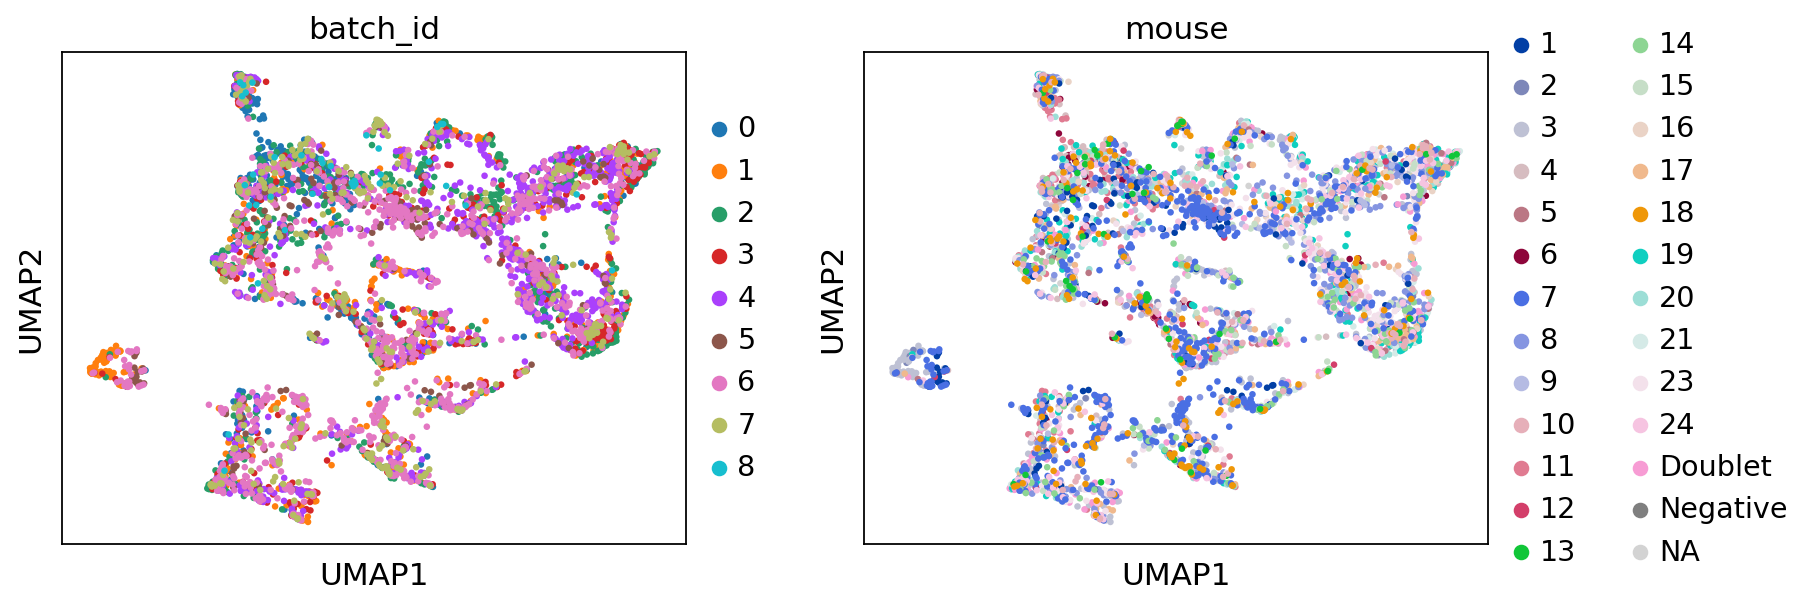

In [292]:
#%matplotlib inline

with plt.rc_context({'figure.figsize': (5,4)}): 
    sc.pl.umap(adataN2, color = ['batch_id','mouse'],s=35)

In [293]:
#clustering
sc.external.tl.phenograph(adataN2, clustering_algo='leiden', k=30, jaccard=True, primary_metric='euclidean', 
                          resolution_parameter = 0.07)

#smaller res_param fewer clusters

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.04583287239074707 seconds
Jaccard graph constructed in 1.7148473262786865 seconds
Running Leiden optimization
Leiden completed in 0.16482019424438477 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 3.162769079208374 seconds


In [294]:
adataN2.obsp['pheno_jaccard_ig'] = scipy.sparse.csr_matrix(adataN2.obsp['pheno_jaccard_ig'])